In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 738)
(3944610, 8)
validation
(464344, 738)
(464344, 8)
test
(574820, 738)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 12:00 - loss: 2.3318 - STD: 0.0846 - MAE: 0.2192

  4/395 [..............................] - ETA: 9s - loss: 2.1620 - STD: 0.0602 - MAE: 0.2169   

  7/395 [..............................] - ETA: 9s - loss: 2.1265 - STD: 0.0533 - MAE: 0.2168

 10/395 [..............................] - ETA: 9s - loss: 2.1131 - STD: 0.0516 - MAE: 0.2167

 13/395 [..............................] - ETA: 9s - loss: 2.1020 - STD: 0.0495 - MAE: 0.2166

 16/395 [>.............................] - ETA: 9s - loss: 2.0922 - STD: 0.0463 - MAE: 0.2166

 19/395 [>.............................] - ETA: 9s - loss: 2.0857 - STD: 0.0437 - MAE: 0.2166

 22/395 [>.............................] - ETA: 8s - loss: 2.0808 - STD: 0.0425 - MAE: 0.2166

 25/395 [>.............................] - ETA: 8s - loss: 2.0762 - STD: 0.0417 - MAE: 0.2165

 28/395 [=>............................] - ETA: 8s - loss: 2.0712 - STD: 0.0405 - MAE: 0.2165

 31/395 [=>............................] - ETA: 8s - loss: 2.0660 - STD: 0.0398 - MAE: 0.2164

 34/395 [=>............................] - ETA: 8s - loss: 2.0605 - STD: 0.0400 - MAE: 0.2162

 37/395 [=>............................] - ETA: 8s - loss: 2.0540 - STD: 0.0404 - MAE: 0.2159

 40/395 [==>...........................] - ETA: 8s - loss: 2.0466 - STD: 0.0411 - MAE: 0.2156

 43/395 [==>...........................] - ETA: 8s - loss: 2.0389 - STD: 0.0421 - MAE: 0.2153

 46/395 [==>...........................] - ETA: 8s - loss: 2.0303 - STD: 0.0432 - MAE: 0.2149

 49/395 [==>...........................] - ETA: 8s - loss: 2.0215 - STD: 0.0444 - MAE: 0.2145

 52/395 [==>...........................] - ETA: 8s - loss: 2.0121 - STD: 0.0459 - MAE: 0.2140

 55/395 [===>..........................] - ETA: 8s - loss: 2.0030 - STD: 0.0473 - MAE: 0.2136

 58/395 [===>..........................] - ETA: 8s - loss: 1.9935 - STD: 0.0487 - MAE: 0.2131

 61/395 [===>..........................] - ETA: 7s - loss: 1.9835 - STD: 0.0502 - MAE: 0.2126

 64/395 [===>..........................] - ETA: 7s - loss: 1.9729 - STD: 0.0517 - MAE: 0.2121

 67/395 [====>.........................] - ETA: 7s - loss: 1.9615 - STD: 0.0532 - MAE: 0.2115

 70/395 [====>.........................] - ETA: 7s - loss: 1.9489 - STD: 0.0548 - MAE: 0.2109

 73/395 [====>.........................] - ETA: 7s - loss: 1.9349 - STD: 0.0565 - MAE: 0.2102

 75/395 [====>.........................] - ETA: 7s - loss: 1.9254 - STD: 0.0578 - MAE: 0.2097

 78/395 [====>.........................] - ETA: 7s - loss: 1.9110 - STD: 0.0599 - MAE: 0.2089

 81/395 [=====>........................] - ETA: 7s - loss: 1.8963 - STD: 0.0620 - MAE: 0.2080

 83/395 [=====>........................] - ETA: 7s - loss: 1.8867 - STD: 0.0635 - MAE: 0.2074

 86/395 [=====>........................] - ETA: 7s - loss: 1.8725 - STD: 0.0657 - MAE: 0.2066

 89/395 [=====>........................] - ETA: 7s - loss: 1.8584 - STD: 0.0679 - MAE: 0.2057

 92/395 [=====>........................] - ETA: 7s - loss: 1.8447 - STD: 0.0700 - MAE: 0.2048

 95/395 [======>.......................] - ETA: 7s - loss: 1.8316 - STD: 0.0721 - MAE: 0.2040

 98/395 [======>.......................] - ETA: 7s - loss: 1.8187 - STD: 0.0741 - MAE: 0.2031

101/395 [======>.......................] - ETA: 7s - loss: 1.8064 - STD: 0.0761 - MAE: 0.2023

104/395 [======>.......................] - ETA: 6s - loss: 1.7947 - STD: 0.0780 - MAE: 0.2015

107/395 [=======>......................] - ETA: 6s - loss: 1.7833 - STD: 0.0798 - MAE: 0.2008

109/395 [=======>......................] - ETA: 6s - loss: 1.7758 - STD: 0.0810 - MAE: 0.2003

112/395 [=======>......................] - ETA: 6s - loss: 1.7649 - STD: 0.0828 - MAE: 0.1995

115/395 [=======>......................] - ETA: 6s - loss: 1.7544 - STD: 0.0845 - MAE: 0.1987

118/395 [=======>......................] - ETA: 6s - loss: 1.7444 - STD: 0.0862 - MAE: 0.1980

121/395 [========>.....................] - ETA: 6s - loss: 1.7346 - STD: 0.0878 - MAE: 0.1973

124/395 [========>.....................] - ETA: 6s - loss: 1.7252 - STD: 0.0894 - MAE: 0.1966

127/395 [========>.....................] - ETA: 6s - loss: 1.7160 - STD: 0.0909 - MAE: 0.1960

130/395 [========>.....................] - ETA: 6s - loss: 1.7070 - STD: 0.0924 - MAE: 0.1953

133/395 [=========>....................] - ETA: 6s - loss: 1.6983 - STD: 0.0939 - MAE: 0.1946

136/395 [=========>....................] - ETA: 6s - loss: 1.6900 - STD: 0.0953 - MAE: 0.1940

139/395 [=========>....................] - ETA: 6s - loss: 1.6821 - STD: 0.0966 - MAE: 0.1934

142/395 [=========>....................] - ETA: 6s - loss: 1.6744 - STD: 0.0980 - MAE: 0.1928

145/395 [==========>...................] - ETA: 5s - loss: 1.6669 - STD: 0.0993 - MAE: 0.1923

148/395 [==========>...................] - ETA: 5s - loss: 1.6597 - STD: 0.1005 - MAE: 0.1917

151/395 [==========>...................] - ETA: 5s - loss: 1.6527 - STD: 0.1017 - MAE: 0.1912

153/395 [==========>...................] - ETA: 5s - loss: 1.6481 - STD: 0.1025 - MAE: 0.1908

156/395 [==========>...................] - ETA: 5s - loss: 1.6411 - STD: 0.1036 - MAE: 0.1903

158/395 [===========>..................] - ETA: 5s - loss: 1.6368 - STD: 0.1044 - MAE: 0.1900

161/395 [===========>..................] - ETA: 5s - loss: 1.6304 - STD: 0.1055 - MAE: 0.1895

164/395 [===========>..................] - ETA: 5s - loss: 1.6241 - STD: 0.1066 - MAE: 0.1890

167/395 [===========>..................] - ETA: 5s - loss: 1.6183 - STD: 0.1076 - MAE: 0.1885

169/395 [===========>..................] - ETA: 5s - loss: 1.6143 - STD: 0.1083 - MAE: 0.1882

172/395 [============>.................] - ETA: 5s - loss: 1.6085 - STD: 0.1093 - MAE: 0.1877

175/395 [============>.................] - ETA: 5s - loss: 1.6029 - STD: 0.1103 - MAE: 0.1873

178/395 [============>.................] - ETA: 5s - loss: 1.5972 - STD: 0.1112 - MAE: 0.1868

181/395 [============>.................] - ETA: 5s - loss: 1.5917 - STD: 0.1122 - MAE: 0.1864

184/395 [============>.................] - ETA: 5s - loss: 1.5864 - STD: 0.1131 - MAE: 0.1859

187/395 [=============>................] - ETA: 4s - loss: 1.5812 - STD: 0.1140 - MAE: 0.1855

190/395 [=============>................] - ETA: 4s - loss: 1.5761 - STD: 0.1149 - MAE: 0.1851

193/395 [=============>................] - ETA: 4s - loss: 1.5711 - STD: 0.1157 - MAE: 0.1847

196/395 [=============>................] - ETA: 4s - loss: 1.5661 - STD: 0.1166 - MAE: 0.1843

199/395 [==============>...............] - ETA: 4s - loss: 1.5613 - STD: 0.1174 - MAE: 0.1839

202/395 [==============>...............] - ETA: 4s - loss: 1.5565 - STD: 0.1182 - MAE: 0.1835

205/395 [==============>...............] - ETA: 4s - loss: 1.5518 - STD: 0.1190 - MAE: 0.1831

208/395 [==============>...............] - ETA: 4s - loss: 1.5473 - STD: 0.1197 - MAE: 0.1828

211/395 [===============>..............] - ETA: 4s - loss: 1.5428 - STD: 0.1205 - MAE: 0.1824

214/395 [===============>..............] - ETA: 4s - loss: 1.5383 - STD: 0.1213 - MAE: 0.1820

217/395 [===============>..............] - ETA: 4s - loss: 1.5339 - STD: 0.1220 - MAE: 0.1817

220/395 [===============>..............] - ETA: 4s - loss: 1.5297 - STD: 0.1227 - MAE: 0.1813

222/395 [===============>..............] - ETA: 4s - loss: 1.5269 - STD: 0.1232 - MAE: 0.1811

225/395 [================>.............] - ETA: 4s - loss: 1.5231 - STD: 0.1239 - MAE: 0.1807

228/395 [================>.............] - ETA: 3s - loss: 1.5191 - STD: 0.1246 - MAE: 0.1804

231/395 [================>.............] - ETA: 3s - loss: 1.5153 - STD: 0.1252 - MAE: 0.1801

234/395 [================>.............] - ETA: 3s - loss: 1.5115 - STD: 0.1259 - MAE: 0.1798

236/395 [================>.............] - ETA: 3s - loss: 1.5089 - STD: 0.1263 - MAE: 0.1796

239/395 [=================>............] - ETA: 3s - loss: 1.5051 - STD: 0.1270 - MAE: 0.1792

242/395 [=================>............] - ETA: 3s - loss: 1.5016 - STD: 0.1276 - MAE: 0.1789

245/395 [=================>............] - ETA: 3s - loss: 1.4980 - STD: 0.1282 - MAE: 0.1786

248/395 [=================>............] - ETA: 3s - loss: 1.4946 - STD: 0.1288 - MAE: 0.1783

251/395 [==================>...........] - ETA: 3s - loss: 1.4912 - STD: 0.1294 - MAE: 0.1780

254/395 [==================>...........] - ETA: 3s - loss: 1.4880 - STD: 0.1300 - MAE: 0.1778

257/395 [==================>...........] - ETA: 3s - loss: 1.4847 - STD: 0.1305 - MAE: 0.1775

260/395 [==================>...........] - ETA: 3s - loss: 1.4813 - STD: 0.1311 - MAE: 0.1772

263/395 [==================>...........] - ETA: 3s - loss: 1.4780 - STD: 0.1316 - MAE: 0.1769

266/395 [===================>..........] - ETA: 3s - loss: 1.4747 - STD: 0.1322 - MAE: 0.1766

269/395 [===================>..........] - ETA: 3s - loss: 1.4716 - STD: 0.1327 - MAE: 0.1764

272/395 [===================>..........] - ETA: 2s - loss: 1.4684 - STD: 0.1333 - MAE: 0.1761

275/395 [===================>..........] - ETA: 2s - loss: 1.4653 - STD: 0.1338 - MAE: 0.1758

278/395 [====================>.........] - ETA: 2s - loss: 1.4623 - STD: 0.1343 - MAE: 0.1756

281/395 [====================>.........] - ETA: 2s - loss: 1.4595 - STD: 0.1348 - MAE: 0.1753

284/395 [====================>.........] - ETA: 2s - loss: 1.4566 - STD: 0.1353 - MAE: 0.1751

287/395 [====================>.........] - ETA: 2s - loss: 1.4536 - STD: 0.1358 - MAE: 0.1748

288/395 [====================>.........] - ETA: 2s - loss: 1.4532 - STD: 0.1360 - MAE: 0.1747

291/395 [=====================>........] - ETA: 2s - loss: 1.4502 - STD: 0.1365 - MAE: 0.1745

294/395 [=====================>........] - ETA: 2s - loss: 1.4474 - STD: 0.1369 - MAE: 0.1742

297/395 [=====================>........] - ETA: 2s - loss: 1.4447 - STD: 0.1374 - MAE: 0.1740

300/395 [=====================>........] - ETA: 2s - loss: 1.4420 - STD: 0.1378 - MAE: 0.1738

303/395 [======================>.......] - ETA: 2s - loss: 1.4393 - STD: 0.1383 - MAE: 0.1735

306/395 [======================>.......] - ETA: 2s - loss: 1.4366 - STD: 0.1387 - MAE: 0.1733

309/395 [======================>.......] - ETA: 2s - loss: 1.4340 - STD: 0.1392 - MAE: 0.1731

312/395 [======================>.......] - ETA: 2s - loss: 1.4315 - STD: 0.1396 - MAE: 0.1728

315/395 [======================>.......] - ETA: 2s - loss: 1.4289 - STD: 0.1400 - MAE: 0.1726

318/395 [=======================>......] - ETA: 2s - loss: 1.4263 - STD: 0.1405 - MAE: 0.1724

321/395 [=======================>......] - ETA: 1s - loss: 1.4238 - STD: 0.1409 - MAE: 0.1722

324/395 [=======================>......] - ETA: 1s - loss: 1.4214 - STD: 0.1413 - MAE: 0.1719

327/395 [=======================>......] - ETA: 1s - loss: 1.4192 - STD: 0.1417 - MAE: 0.1717

330/395 [========================>.....] - ETA: 1s - loss: 1.4168 - STD: 0.1421 - MAE: 0.1715

333/395 [========================>.....] - ETA: 1s - loss: 1.4145 - STD: 0.1425 - MAE: 0.1713

336/395 [========================>.....] - ETA: 1s - loss: 1.4123 - STD: 0.1429 - MAE: 0.1711

339/395 [========================>.....] - ETA: 1s - loss: 1.4099 - STD: 0.1432 - MAE: 0.1709

342/395 [========================>.....] - ETA: 1s - loss: 1.4075 - STD: 0.1436 - MAE: 0.1707

345/395 [=========================>....] - ETA: 1s - loss: 1.4052 - STD: 0.1440 - MAE: 0.1705

348/395 [=========================>....] - ETA: 1s - loss: 1.4030 - STD: 0.1444 - MAE: 0.1703

351/395 [=========================>....] - ETA: 1s - loss: 1.4009 - STD: 0.1447 - MAE: 0.1701

354/395 [=========================>....] - ETA: 1s - loss: 1.3987 - STD: 0.1451 - MAE: 0.1699

357/395 [==========================>...] - ETA: 1s - loss: 1.3964 - STD: 0.1455 - MAE: 0.1697

360/395 [==========================>...] - ETA: 0s - loss: 1.3942 - STD: 0.1458 - MAE: 0.1695

363/395 [==========================>...] - ETA: 0s - loss: 1.3921 - STD: 0.1462 - MAE: 0.1694

366/395 [==========================>...] - ETA: 0s - loss: 1.3900 - STD: 0.1465 - MAE: 0.1692

369/395 [===========================>..] - ETA: 0s - loss: 1.3879 - STD: 0.1468 - MAE: 0.1690

372/395 [===========================>..] - ETA: 0s - loss: 1.3859 - STD: 0.1472 - MAE: 0.1688

375/395 [===========================>..] - ETA: 0s - loss: 1.3838 - STD: 0.1475 - MAE: 0.1686

378/395 [===========================>..] - ETA: 0s - loss: 1.3818 - STD: 0.1478 - MAE: 0.1684

381/395 [===========================>..] - ETA: 0s - loss: 1.3797 - STD: 0.1482 - MAE: 0.1683

384/395 [============================>.] - ETA: 0s - loss: 1.3777 - STD: 0.1485 - MAE: 0.1681

386/395 [============================>.] - ETA: 0s - loss: 1.3763 - STD: 0.1487 - MAE: 0.1680

389/395 [============================>.] - ETA: 0s - loss: 1.3743 - STD: 0.1490 - MAE: 0.1678

392/395 [============================>.] - ETA: 0s - loss: 1.3725 - STD: 0.1493 - MAE: 0.1676

395/395 [==============================] - ETA: 0s - loss: 1.3705 - STD: 0.1496 - MAE: 0.1674

395/395 [==============================] - 14s 30ms/step - loss: 1.3705 - STD: 0.1496 - MAE: 0.1674 - val_loss: 1.2074 - val_STD: 0.1917 - val_MAE: 0.1453


Epoch 2/10000


  1/395 [..............................] - ETA: 21s - loss: 1.1142 - STD: 0.1905 - MAE: 0.1445

  4/395 [..............................] - ETA: 9s - loss: 1.1087 - STD: 0.1915 - MAE: 0.1437 

  7/395 [..............................] - ETA: 9s - loss: 1.1125 - STD: 0.1912 - MAE: 0.1442

 10/395 [..............................] - ETA: 9s - loss: 1.1151 - STD: 0.1909 - MAE: 0.1444

 13/395 [..............................] - ETA: 9s - loss: 1.1156 - STD: 0.1910 - MAE: 0.1444

 16/395 [>.............................] - ETA: 9s - loss: 1.1147 - STD: 0.1911 - MAE: 0.1444

 19/395 [>.............................] - ETA: 9s - loss: 1.1188 - STD: 0.1910 - MAE: 0.1446

 22/395 [>.............................] - ETA: 9s - loss: 1.1191 - STD: 0.1910 - MAE: 0.1447

 25/395 [>.............................] - ETA: 8s - loss: 1.1193 - STD: 0.1911 - MAE: 0.1446

 28/395 [=>............................] - ETA: 8s - loss: 1.1186 - STD: 0.1912 - MAE: 0.1445

 31/395 [=>............................] - ETA: 8s - loss: 1.1178 - STD: 0.1913 - MAE: 0.1444

 34/395 [=>............................] - ETA: 8s - loss: 1.1176 - STD: 0.1913 - MAE: 0.1444

 37/395 [=>............................] - ETA: 8s - loss: 1.1169 - STD: 0.1913 - MAE: 0.1444

 40/395 [==>...........................] - ETA: 8s - loss: 1.1161 - STD: 0.1913 - MAE: 0.1443

 43/395 [==>...........................] - ETA: 8s - loss: 1.1160 - STD: 0.1914 - MAE: 0.1443

 46/395 [==>...........................] - ETA: 8s - loss: 1.1158 - STD: 0.1915 - MAE: 0.1442

 49/395 [==>...........................] - ETA: 8s - loss: 1.1149 - STD: 0.1915 - MAE: 0.1442

 52/395 [==>...........................] - ETA: 8s - loss: 1.1148 - STD: 0.1916 - MAE: 0.1441

 55/395 [===>..........................] - ETA: 8s - loss: 1.1144 - STD: 0.1916 - MAE: 0.1441

 58/395 [===>..........................] - ETA: 8s - loss: 1.1137 - STD: 0.1917 - MAE: 0.1441

 61/395 [===>..........................] - ETA: 8s - loss: 1.1131 - STD: 0.1917 - MAE: 0.1440

 64/395 [===>..........................] - ETA: 7s - loss: 1.1125 - STD: 0.1918 - MAE: 0.1439

 67/395 [====>.........................] - ETA: 7s - loss: 1.1121 - STD: 0.1919 - MAE: 0.1439

 70/395 [====>.........................] - ETA: 7s - loss: 1.1114 - STD: 0.1920 - MAE: 0.1438

 73/395 [====>.........................] - ETA: 7s - loss: 1.1109 - STD: 0.1920 - MAE: 0.1438

 76/395 [====>.........................] - ETA: 7s - loss: 1.1099 - STD: 0.1921 - MAE: 0.1437

 79/395 [=====>........................] - ETA: 7s - loss: 1.1089 - STD: 0.1922 - MAE: 0.1436

 82/395 [=====>........................] - ETA: 7s - loss: 1.1083 - STD: 0.1922 - MAE: 0.1435

 85/395 [=====>........................] - ETA: 7s - loss: 1.1076 - STD: 0.1923 - MAE: 0.1435

 88/395 [=====>........................] - ETA: 7s - loss: 1.1069 - STD: 0.1924 - MAE: 0.1434

 91/395 [=====>........................] - ETA: 7s - loss: 1.1057 - STD: 0.1925 - MAE: 0.1433

 94/395 [======>.......................] - ETA: 7s - loss: 1.1054 - STD: 0.1926 - MAE: 0.1433

 97/395 [======>.......................] - ETA: 7s - loss: 1.1047 - STD: 0.1927 - MAE: 0.1432

100/395 [======>.......................] - ETA: 7s - loss: 1.1043 - STD: 0.1927 - MAE: 0.1431

103/395 [======>.......................] - ETA: 6s - loss: 1.1036 - STD: 0.1928 - MAE: 0.1431

106/395 [=======>......................] - ETA: 6s - loss: 1.1031 - STD: 0.1929 - MAE: 0.1430

109/395 [=======>......................] - ETA: 6s - loss: 1.1023 - STD: 0.1930 - MAE: 0.1429

112/395 [=======>......................] - ETA: 6s - loss: 1.1021 - STD: 0.1931 - MAE: 0.1429

115/395 [=======>......................] - ETA: 6s - loss: 1.1015 - STD: 0.1932 - MAE: 0.1428

118/395 [=======>......................] - ETA: 6s - loss: 1.1008 - STD: 0.1933 - MAE: 0.1427

121/395 [========>.....................] - ETA: 6s - loss: 1.0999 - STD: 0.1933 - MAE: 0.1427

124/395 [========>.....................] - ETA: 6s - loss: 1.0992 - STD: 0.1934 - MAE: 0.1426

127/395 [========>.....................] - ETA: 6s - loss: 1.0983 - STD: 0.1935 - MAE: 0.1425

130/395 [========>.....................] - ETA: 6s - loss: 1.0975 - STD: 0.1936 - MAE: 0.1424

133/395 [=========>....................] - ETA: 6s - loss: 1.0966 - STD: 0.1937 - MAE: 0.1423

136/395 [=========>....................] - ETA: 6s - loss: 1.0960 - STD: 0.1938 - MAE: 0.1423

139/395 [=========>....................] - ETA: 6s - loss: 1.0951 - STD: 0.1938 - MAE: 0.1422

142/395 [=========>....................] - ETA: 6s - loss: 1.0942 - STD: 0.1939 - MAE: 0.1421

145/395 [==========>...................] - ETA: 5s - loss: 1.0934 - STD: 0.1940 - MAE: 0.1420

148/395 [==========>...................] - ETA: 5s - loss: 1.0927 - STD: 0.1941 - MAE: 0.1419

151/395 [==========>...................] - ETA: 5s - loss: 1.0920 - STD: 0.1942 - MAE: 0.1419

154/395 [==========>...................] - ETA: 5s - loss: 1.0917 - STD: 0.1943 - MAE: 0.1418

157/395 [==========>...................] - ETA: 5s - loss: 1.0909 - STD: 0.1944 - MAE: 0.1417

160/395 [===========>..................] - ETA: 5s - loss: 1.0907 - STD: 0.1945 - MAE: 0.1417

163/395 [===========>..................] - ETA: 5s - loss: 1.0901 - STD: 0.1946 - MAE: 0.1416

166/395 [===========>..................] - ETA: 5s - loss: 1.0895 - STD: 0.1947 - MAE: 0.1415

169/395 [===========>..................] - ETA: 5s - loss: 1.0887 - STD: 0.1947 - MAE: 0.1415

172/395 [============>.................] - ETA: 5s - loss: 1.0880 - STD: 0.1948 - MAE: 0.1414

175/395 [============>.................] - ETA: 5s - loss: 1.0873 - STD: 0.1949 - MAE: 0.1413

178/395 [============>.................] - ETA: 5s - loss: 1.0866 - STD: 0.1950 - MAE: 0.1413

181/395 [============>.................] - ETA: 5s - loss: 1.0862 - STD: 0.1951 - MAE: 0.1412

184/395 [============>.................] - ETA: 5s - loss: 1.0856 - STD: 0.1952 - MAE: 0.1411

187/395 [=============>................] - ETA: 4s - loss: 1.0852 - STD: 0.1953 - MAE: 0.1411

190/395 [=============>................] - ETA: 4s - loss: 1.0848 - STD: 0.1953 - MAE: 0.1410

192/395 [=============>................] - ETA: 4s - loss: 1.0845 - STD: 0.1954 - MAE: 0.1410

195/395 [=============>................] - ETA: 4s - loss: 1.0838 - STD: 0.1955 - MAE: 0.1409

198/395 [==============>...............] - ETA: 4s - loss: 1.0831 - STD: 0.1955 - MAE: 0.1408

201/395 [==============>...............] - ETA: 4s - loss: 1.0825 - STD: 0.1956 - MAE: 0.1408

203/395 [==============>...............] - ETA: 4s - loss: 1.0821 - STD: 0.1957 - MAE: 0.1407

206/395 [==============>...............] - ETA: 4s - loss: 1.0815 - STD: 0.1958 - MAE: 0.1407

209/395 [==============>...............] - ETA: 4s - loss: 1.0808 - STD: 0.1958 - MAE: 0.1406

212/395 [===============>..............] - ETA: 4s - loss: 1.0801 - STD: 0.1959 - MAE: 0.1405

215/395 [===============>..............] - ETA: 4s - loss: 1.0796 - STD: 0.1960 - MAE: 0.1405

218/395 [===============>..............] - ETA: 4s - loss: 1.0790 - STD: 0.1961 - MAE: 0.1404

221/395 [===============>..............] - ETA: 4s - loss: 1.0783 - STD: 0.1961 - MAE: 0.1403

224/395 [================>.............] - ETA: 4s - loss: 1.0775 - STD: 0.1962 - MAE: 0.1403

227/395 [================>.............] - ETA: 4s - loss: 1.0768 - STD: 0.1963 - MAE: 0.1402

230/395 [================>.............] - ETA: 3s - loss: 1.0763 - STD: 0.1964 - MAE: 0.1401

233/395 [================>.............] - ETA: 3s - loss: 1.0760 - STD: 0.1965 - MAE: 0.1401

236/395 [================>.............] - ETA: 3s - loss: 1.0754 - STD: 0.1966 - MAE: 0.1400

239/395 [=================>............] - ETA: 3s - loss: 1.0748 - STD: 0.1966 - MAE: 0.1399

242/395 [=================>............] - ETA: 3s - loss: 1.0742 - STD: 0.1967 - MAE: 0.1399

245/395 [=================>............] - ETA: 3s - loss: 1.0736 - STD: 0.1968 - MAE: 0.1398

248/395 [=================>............] - ETA: 3s - loss: 1.0730 - STD: 0.1969 - MAE: 0.1397

251/395 [==================>...........] - ETA: 3s - loss: 1.0724 - STD: 0.1970 - MAE: 0.1397

254/395 [==================>...........] - ETA: 3s - loss: 1.0719 - STD: 0.1970 - MAE: 0.1396

257/395 [==================>...........] - ETA: 3s - loss: 1.0713 - STD: 0.1971 - MAE: 0.1396

260/395 [==================>...........] - ETA: 3s - loss: 1.0710 - STD: 0.1972 - MAE: 0.1395

263/395 [==================>...........] - ETA: 3s - loss: 1.0705 - STD: 0.1973 - MAE: 0.1395

266/395 [===================>..........] - ETA: 3s - loss: 1.0700 - STD: 0.1973 - MAE: 0.1394

269/395 [===================>..........] - ETA: 3s - loss: 1.0696 - STD: 0.1974 - MAE: 0.1393

271/395 [===================>..........] - ETA: 2s - loss: 1.0692 - STD: 0.1975 - MAE: 0.1393

274/395 [===================>..........] - ETA: 2s - loss: 1.0689 - STD: 0.1975 - MAE: 0.1393

277/395 [====================>.........] - ETA: 2s - loss: 1.0683 - STD: 0.1976 - MAE: 0.1392

280/395 [====================>.........] - ETA: 2s - loss: 1.0680 - STD: 0.1977 - MAE: 0.1392

283/395 [====================>.........] - ETA: 2s - loss: 1.0675 - STD: 0.1978 - MAE: 0.1391

286/395 [====================>.........] - ETA: 2s - loss: 1.0670 - STD: 0.1978 - MAE: 0.1390

289/395 [====================>.........] - ETA: 2s - loss: 1.0663 - STD: 0.1979 - MAE: 0.1390

292/395 [=====================>........] - ETA: 2s - loss: 1.0657 - STD: 0.1980 - MAE: 0.1389

295/395 [=====================>........] - ETA: 2s - loss: 1.0651 - STD: 0.1980 - MAE: 0.1389

297/395 [=====================>........] - ETA: 2s - loss: 1.0647 - STD: 0.1981 - MAE: 0.1388

300/395 [=====================>........] - ETA: 2s - loss: 1.0641 - STD: 0.1982 - MAE: 0.1387

302/395 [=====================>........] - ETA: 2s - loss: 1.0637 - STD: 0.1982 - MAE: 0.1387

304/395 [======================>.......] - ETA: 2s - loss: 1.0634 - STD: 0.1983 - MAE: 0.1387

307/395 [======================>.......] - ETA: 2s - loss: 1.0630 - STD: 0.1983 - MAE: 0.1386

310/395 [======================>.......] - ETA: 2s - loss: 1.0626 - STD: 0.1984 - MAE: 0.1386

312/395 [======================>.......] - ETA: 1s - loss: 1.0624 - STD: 0.1985 - MAE: 0.1385

314/395 [======================>.......] - ETA: 1s - loss: 1.0622 - STD: 0.1985 - MAE: 0.1385

317/395 [=======================>......] - ETA: 1s - loss: 1.0618 - STD: 0.1986 - MAE: 0.1385

320/395 [=======================>......] - ETA: 1s - loss: 1.0614 - STD: 0.1987 - MAE: 0.1384

323/395 [=======================>......] - ETA: 1s - loss: 1.0609 - STD: 0.1987 - MAE: 0.1383

326/395 [=======================>......] - ETA: 1s - loss: 1.0605 - STD: 0.1988 - MAE: 0.1383

329/395 [=======================>......] - ETA: 1s - loss: 1.0600 - STD: 0.1989 - MAE: 0.1382

332/395 [========================>.....] - ETA: 1s - loss: 1.0595 - STD: 0.1989 - MAE: 0.1382

335/395 [========================>.....] - ETA: 1s - loss: 1.0590 - STD: 0.1990 - MAE: 0.1381

338/395 [========================>.....] - ETA: 1s - loss: 1.0585 - STD: 0.1991 - MAE: 0.1381

341/395 [========================>.....] - ETA: 1s - loss: 1.0579 - STD: 0.1991 - MAE: 0.1380

344/395 [=========================>....] - ETA: 1s - loss: 1.0575 - STD: 0.1992 - MAE: 0.1380

347/395 [=========================>....] - ETA: 1s - loss: 1.0571 - STD: 0.1993 - MAE: 0.1379

350/395 [=========================>....] - ETA: 1s - loss: 1.0566 - STD: 0.1993 - MAE: 0.1379

353/395 [=========================>....] - ETA: 1s - loss: 1.0559 - STD: 0.1994 - MAE: 0.1378

356/395 [==========================>...] - ETA: 0s - loss: 1.0553 - STD: 0.1995 - MAE: 0.1377

359/395 [==========================>...] - ETA: 0s - loss: 1.0548 - STD: 0.1995 - MAE: 0.1377

362/395 [==========================>...] - ETA: 0s - loss: 1.0543 - STD: 0.1996 - MAE: 0.1376

365/395 [==========================>...] - ETA: 0s - loss: 1.0538 - STD: 0.1997 - MAE: 0.1376

368/395 [==========================>...] - ETA: 0s - loss: 1.0532 - STD: 0.1997 - MAE: 0.1375

371/395 [===========================>..] - ETA: 0s - loss: 1.0527 - STD: 0.1998 - MAE: 0.1375

374/395 [===========================>..] - ETA: 0s - loss: 1.0523 - STD: 0.1999 - MAE: 0.1374

377/395 [===========================>..] - ETA: 0s - loss: 1.0518 - STD: 0.1999 - MAE: 0.1373

380/395 [===========================>..] - ETA: 0s - loss: 1.0513 - STD: 0.2000 - MAE: 0.1373

383/395 [============================>.] - ETA: 0s - loss: 1.0508 - STD: 0.2001 - MAE: 0.1372

386/395 [============================>.] - ETA: 0s - loss: 1.0503 - STD: 0.2001 - MAE: 0.1372

389/395 [============================>.] - ETA: 0s - loss: 1.0501 - STD: 0.2002 - MAE: 0.1371

392/395 [============================>.] - ETA: 0s - loss: 1.0496 - STD: 0.2003 - MAE: 0.1371

395/395 [==============================] - ETA: 0s - loss: 1.0492 - STD: 0.2003 - MAE: 0.1370

395/395 [==============================] - 10s 26ms/step - loss: 1.0492 - STD: 0.2003 - MAE: 0.1370 - val_loss: 1.0901 - val_STD: 0.2108 - val_MAE: 0.1317


Epoch 3/10000


  1/395 [..............................] - ETA: 22s - loss: 0.9965 - STD: 0.2091 - MAE: 0.1306

  3/395 [..............................] - ETA: 10s - loss: 0.9994 - STD: 0.2086 - MAE: 0.1310

  6/395 [..............................] - ETA: 9s - loss: 0.9906 - STD: 0.2090 - MAE: 0.1302 

  9/395 [..............................] - ETA: 9s - loss: 0.9899 - STD: 0.2088 - MAE: 0.1303

 12/395 [..............................] - ETA: 9s - loss: 0.9893 - STD: 0.2087 - MAE: 0.1303

 15/395 [>.............................] - ETA: 9s - loss: 0.9879 - STD: 0.2087 - MAE: 0.1302

 18/395 [>.............................] - ETA: 9s - loss: 0.9855 - STD: 0.2088 - MAE: 0.1300

 21/395 [>.............................] - ETA: 9s - loss: 0.9880 - STD: 0.2088 - MAE: 0.1301

 24/395 [>.............................] - ETA: 9s - loss: 0.9874 - STD: 0.2089 - MAE: 0.1301

 27/395 [=>............................] - ETA: 8s - loss: 0.9878 - STD: 0.2090 - MAE: 0.1301

 30/395 [=>............................] - ETA: 8s - loss: 0.9892 - STD: 0.2090 - MAE: 0.1302

 33/395 [=>............................] - ETA: 8s - loss: 0.9889 - STD: 0.2090 - MAE: 0.1301

 36/395 [=>............................] - ETA: 8s - loss: 0.9880 - STD: 0.2091 - MAE: 0.1300

 39/395 [=>............................] - ETA: 8s - loss: 0.9861 - STD: 0.2091 - MAE: 0.1299

 42/395 [==>...........................] - ETA: 8s - loss: 0.9861 - STD: 0.2092 - MAE: 0.1299

 45/395 [==>...........................] - ETA: 8s - loss: 0.9854 - STD: 0.2092 - MAE: 0.1298

 48/395 [==>...........................] - ETA: 8s - loss: 0.9847 - STD: 0.2092 - MAE: 0.1298

 51/395 [==>...........................] - ETA: 8s - loss: 0.9844 - STD: 0.2092 - MAE: 0.1298

 54/395 [===>..........................] - ETA: 8s - loss: 0.9840 - STD: 0.2093 - MAE: 0.1297

 57/395 [===>..........................] - ETA: 8s - loss: 0.9846 - STD: 0.2093 - MAE: 0.1297

 60/395 [===>..........................] - ETA: 8s - loss: 0.9854 - STD: 0.2094 - MAE: 0.1297

 63/395 [===>..........................] - ETA: 7s - loss: 0.9858 - STD: 0.2095 - MAE: 0.1297

 66/395 [====>.........................] - ETA: 7s - loss: 0.9858 - STD: 0.2096 - MAE: 0.1297

 69/395 [====>.........................] - ETA: 7s - loss: 0.9855 - STD: 0.2096 - MAE: 0.1296

 71/395 [====>.........................] - ETA: 7s - loss: 0.9852 - STD: 0.2097 - MAE: 0.1296

 73/395 [====>.........................] - ETA: 7s - loss: 0.9848 - STD: 0.2097 - MAE: 0.1296

 76/395 [====>.........................] - ETA: 7s - loss: 0.9841 - STD: 0.2097 - MAE: 0.1295

 79/395 [=====>........................] - ETA: 7s - loss: 0.9832 - STD: 0.2098 - MAE: 0.1294

 82/395 [=====>........................] - ETA: 7s - loss: 0.9828 - STD: 0.2099 - MAE: 0.1294

 85/395 [=====>........................] - ETA: 7s - loss: 0.9829 - STD: 0.2099 - MAE: 0.1294

 88/395 [=====>........................] - ETA: 7s - loss: 0.9825 - STD: 0.2100 - MAE: 0.1293

 91/395 [=====>........................] - ETA: 7s - loss: 0.9823 - STD: 0.2100 - MAE: 0.1293

 94/395 [======>.......................] - ETA: 7s - loss: 0.9821 - STD: 0.2100 - MAE: 0.1293

 97/395 [======>.......................] - ETA: 7s - loss: 0.9816 - STD: 0.2101 - MAE: 0.1292

100/395 [======>.......................] - ETA: 7s - loss: 0.9816 - STD: 0.2101 - MAE: 0.1292

103/395 [======>.......................] - ETA: 6s - loss: 0.9812 - STD: 0.2101 - MAE: 0.1292

106/395 [=======>......................] - ETA: 6s - loss: 0.9809 - STD: 0.2101 - MAE: 0.1292

109/395 [=======>......................] - ETA: 6s - loss: 0.9805 - STD: 0.2102 - MAE: 0.1291

112/395 [=======>......................] - ETA: 6s - loss: 0.9814 - STD: 0.2102 - MAE: 0.1292

115/395 [=======>......................] - ETA: 6s - loss: 0.9816 - STD: 0.2103 - MAE: 0.1291

118/395 [=======>......................] - ETA: 6s - loss: 0.9814 - STD: 0.2103 - MAE: 0.1291

121/395 [========>.....................] - ETA: 6s - loss: 0.9810 - STD: 0.2103 - MAE: 0.1291

124/395 [========>.....................] - ETA: 6s - loss: 0.9807 - STD: 0.2104 - MAE: 0.1290

127/395 [========>.....................] - ETA: 6s - loss: 0.9804 - STD: 0.2104 - MAE: 0.1290

130/395 [========>.....................] - ETA: 6s - loss: 0.9799 - STD: 0.2104 - MAE: 0.1290

133/395 [=========>....................] - ETA: 6s - loss: 0.9795 - STD: 0.2104 - MAE: 0.1289

136/395 [=========>....................] - ETA: 6s - loss: 0.9793 - STD: 0.2104 - MAE: 0.1289

139/395 [=========>....................] - ETA: 6s - loss: 0.9795 - STD: 0.2105 - MAE: 0.1289

142/395 [=========>....................] - ETA: 6s - loss: 0.9796 - STD: 0.2105 - MAE: 0.1289

145/395 [==========>...................] - ETA: 5s - loss: 0.9796 - STD: 0.2105 - MAE: 0.1289

148/395 [==========>...................] - ETA: 5s - loss: 0.9796 - STD: 0.2106 - MAE: 0.1289

151/395 [==========>...................] - ETA: 5s - loss: 0.9799 - STD: 0.2106 - MAE: 0.1289

154/395 [==========>...................] - ETA: 5s - loss: 0.9796 - STD: 0.2107 - MAE: 0.1288

157/395 [==========>...................] - ETA: 5s - loss: 0.9792 - STD: 0.2107 - MAE: 0.1288

160/395 [===========>..................] - ETA: 5s - loss: 0.9791 - STD: 0.2107 - MAE: 0.1288

163/395 [===========>..................] - ETA: 5s - loss: 0.9787 - STD: 0.2108 - MAE: 0.1287

166/395 [===========>..................] - ETA: 5s - loss: 0.9784 - STD: 0.2108 - MAE: 0.1287

169/395 [===========>..................] - ETA: 5s - loss: 0.9778 - STD: 0.2108 - MAE: 0.1287

172/395 [============>.................] - ETA: 5s - loss: 0.9775 - STD: 0.2109 - MAE: 0.1286

175/395 [============>.................] - ETA: 5s - loss: 0.9771 - STD: 0.2109 - MAE: 0.1286

178/395 [============>.................] - ETA: 5s - loss: 0.9767 - STD: 0.2109 - MAE: 0.1285

181/395 [============>.................] - ETA: 5s - loss: 0.9763 - STD: 0.2110 - MAE: 0.1285

184/395 [============>.................] - ETA: 5s - loss: 0.9758 - STD: 0.2110 - MAE: 0.1285

187/395 [=============>................] - ETA: 4s - loss: 0.9756 - STD: 0.2111 - MAE: 0.1284

190/395 [=============>................] - ETA: 4s - loss: 0.9754 - STD: 0.2111 - MAE: 0.1284

193/395 [=============>................] - ETA: 4s - loss: 0.9751 - STD: 0.2112 - MAE: 0.1284

196/395 [=============>................] - ETA: 4s - loss: 0.9749 - STD: 0.2112 - MAE: 0.1283

199/395 [==============>...............] - ETA: 4s - loss: 0.9745 - STD: 0.2112 - MAE: 0.1283

202/395 [==============>...............] - ETA: 4s - loss: 0.9741 - STD: 0.2113 - MAE: 0.1282

205/395 [==============>...............] - ETA: 4s - loss: 0.9738 - STD: 0.2113 - MAE: 0.1282

208/395 [==============>...............] - ETA: 4s - loss: 0.9739 - STD: 0.2113 - MAE: 0.1282

211/395 [===============>..............] - ETA: 4s - loss: 0.9736 - STD: 0.2114 - MAE: 0.1282

214/395 [===============>..............] - ETA: 4s - loss: 0.9732 - STD: 0.2114 - MAE: 0.1281

217/395 [===============>..............] - ETA: 4s - loss: 0.9729 - STD: 0.2115 - MAE: 0.1281

220/395 [===============>..............] - ETA: 4s - loss: 0.9726 - STD: 0.2115 - MAE: 0.1281

223/395 [===============>..............] - ETA: 4s - loss: 0.9723 - STD: 0.2115 - MAE: 0.1280

226/395 [================>.............] - ETA: 4s - loss: 0.9719 - STD: 0.2116 - MAE: 0.1280

229/395 [================>.............] - ETA: 3s - loss: 0.9717 - STD: 0.2116 - MAE: 0.1280

232/395 [================>.............] - ETA: 3s - loss: 0.9713 - STD: 0.2117 - MAE: 0.1279

235/395 [================>.............] - ETA: 3s - loss: 0.9708 - STD: 0.2117 - MAE: 0.1279

238/395 [=================>............] - ETA: 3s - loss: 0.9704 - STD: 0.2117 - MAE: 0.1278

241/395 [=================>............] - ETA: 3s - loss: 0.9702 - STD: 0.2118 - MAE: 0.1278

243/395 [=================>............] - ETA: 3s - loss: 0.9700 - STD: 0.2118 - MAE: 0.1278

246/395 [=================>............] - ETA: 3s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1278

249/395 [=================>............] - ETA: 3s - loss: 0.9695 - STD: 0.2119 - MAE: 0.1277

252/395 [==================>...........] - ETA: 3s - loss: 0.9693 - STD: 0.2119 - MAE: 0.1277

255/395 [==================>...........] - ETA: 3s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1277

258/395 [==================>...........] - ETA: 3s - loss: 0.9688 - STD: 0.2120 - MAE: 0.1276

261/395 [==================>...........] - ETA: 3s - loss: 0.9685 - STD: 0.2120 - MAE: 0.1276

264/395 [===================>..........] - ETA: 3s - loss: 0.9681 - STD: 0.2121 - MAE: 0.1276

267/395 [===================>..........] - ETA: 3s - loss: 0.9679 - STD: 0.2121 - MAE: 0.1275

270/395 [===================>..........] - ETA: 2s - loss: 0.9675 - STD: 0.2121 - MAE: 0.1275

273/395 [===================>..........] - ETA: 2s - loss: 0.9673 - STD: 0.2122 - MAE: 0.1275

276/395 [===================>..........] - ETA: 2s - loss: 0.9671 - STD: 0.2122 - MAE: 0.1274

279/395 [====================>.........] - ETA: 2s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1274

282/395 [====================>.........] - ETA: 2s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1274

285/395 [====================>.........] - ETA: 2s - loss: 0.9669 - STD: 0.2123 - MAE: 0.1274

288/395 [====================>.........] - ETA: 2s - loss: 0.9666 - STD: 0.2124 - MAE: 0.1273

291/395 [=====================>........] - ETA: 2s - loss: 0.9664 - STD: 0.2124 - MAE: 0.1273

294/395 [=====================>........] - ETA: 2s - loss: 0.9662 - STD: 0.2124 - MAE: 0.1273

297/395 [=====================>........] - ETA: 2s - loss: 0.9659 - STD: 0.2125 - MAE: 0.1273

300/395 [=====================>........] - ETA: 2s - loss: 0.9656 - STD: 0.2125 - MAE: 0.1272

303/395 [======================>.......] - ETA: 2s - loss: 0.9652 - STD: 0.2125 - MAE: 0.1272

306/395 [======================>.......] - ETA: 2s - loss: 0.9650 - STD: 0.2126 - MAE: 0.1272

309/395 [======================>.......] - ETA: 2s - loss: 0.9649 - STD: 0.2126 - MAE: 0.1271

312/395 [======================>.......] - ETA: 1s - loss: 0.9648 - STD: 0.2126 - MAE: 0.1271

315/395 [======================>.......] - ETA: 1s - loss: 0.9648 - STD: 0.2127 - MAE: 0.1271

318/395 [=======================>......] - ETA: 1s - loss: 0.9646 - STD: 0.2127 - MAE: 0.1271

321/395 [=======================>......] - ETA: 1s - loss: 0.9645 - STD: 0.2127 - MAE: 0.1271

324/395 [=======================>......] - ETA: 1s - loss: 0.9643 - STD: 0.2128 - MAE: 0.1270

327/395 [=======================>......] - ETA: 1s - loss: 0.9640 - STD: 0.2128 - MAE: 0.1270

330/395 [========================>.....] - ETA: 1s - loss: 0.9639 - STD: 0.2128 - MAE: 0.1270

333/395 [========================>.....] - ETA: 1s - loss: 0.9637 - STD: 0.2128 - MAE: 0.1270

336/395 [========================>.....] - ETA: 1s - loss: 0.9635 - STD: 0.2128 - MAE: 0.1270

339/395 [========================>.....] - ETA: 1s - loss: 0.9633 - STD: 0.2129 - MAE: 0.1269

342/395 [========================>.....] - ETA: 1s - loss: 0.9631 - STD: 0.2129 - MAE: 0.1269

345/395 [=========================>....] - ETA: 1s - loss: 0.9628 - STD: 0.2129 - MAE: 0.1269

348/395 [=========================>....] - ETA: 1s - loss: 0.9626 - STD: 0.2130 - MAE: 0.1268

350/395 [=========================>....] - ETA: 1s - loss: 0.9625 - STD: 0.2130 - MAE: 0.1268

353/395 [=========================>....] - ETA: 1s - loss: 0.9621 - STD: 0.2130 - MAE: 0.1268

356/395 [==========================>...] - ETA: 0s - loss: 0.9618 - STD: 0.2130 - MAE: 0.1268

359/395 [==========================>...] - ETA: 0s - loss: 0.9615 - STD: 0.2131 - MAE: 0.1267

362/395 [==========================>...] - ETA: 0s - loss: 0.9612 - STD: 0.2131 - MAE: 0.1267

365/395 [==========================>...] - ETA: 0s - loss: 0.9609 - STD: 0.2131 - MAE: 0.1267

368/395 [==========================>...] - ETA: 0s - loss: 0.9607 - STD: 0.2132 - MAE: 0.1266

371/395 [===========================>..] - ETA: 0s - loss: 0.9605 - STD: 0.2132 - MAE: 0.1266

374/395 [===========================>..] - ETA: 0s - loss: 0.9603 - STD: 0.2132 - MAE: 0.1266

377/395 [===========================>..] - ETA: 0s - loss: 0.9601 - STD: 0.2133 - MAE: 0.1266

380/395 [===========================>..] - ETA: 0s - loss: 0.9598 - STD: 0.2133 - MAE: 0.1265

383/395 [============================>.] - ETA: 0s - loss: 0.9596 - STD: 0.2133 - MAE: 0.1265

386/395 [============================>.] - ETA: 0s - loss: 0.9592 - STD: 0.2134 - MAE: 0.1265

389/395 [============================>.] - ETA: 0s - loss: 0.9590 - STD: 0.2134 - MAE: 0.1264

392/395 [============================>.] - ETA: 0s - loss: 0.9587 - STD: 0.2134 - MAE: 0.1264

395/395 [==============================] - ETA: 0s - loss: 0.9586 - STD: 0.2135 - MAE: 0.1264

395/395 [==============================] - 10s 26ms/step - loss: 0.9586 - STD: 0.2135 - MAE: 0.1264 - val_loss: 1.0873 - val_STD: 0.2178 - val_MAE: 0.1293


Epoch 4/10000


  1/395 [..............................] - ETA: 23s - loss: 0.9633 - STD: 0.2173 - MAE: 0.1252

  4/395 [..............................] - ETA: 9s - loss: 0.9425 - STD: 0.2176 - MAE: 0.1235 

  7/395 [..............................] - ETA: 9s - loss: 0.9667 - STD: 0.2178 - MAE: 0.1249

 10/395 [..............................] - ETA: 9s - loss: 0.9572 - STD: 0.2178 - MAE: 0.1244

 13/395 [..............................] - ETA: 8s - loss: 0.9520 - STD: 0.2178 - MAE: 0.1241

 16/395 [>.............................] - ETA: 8s - loss: 0.9498 - STD: 0.2177 - MAE: 0.1241

 19/395 [>.............................] - ETA: 8s - loss: 0.9463 - STD: 0.2174 - MAE: 0.1240

 22/395 [>.............................] - ETA: 8s - loss: 0.9426 - STD: 0.2174 - MAE: 0.1237

 25/395 [>.............................] - ETA: 8s - loss: 0.9404 - STD: 0.2173 - MAE: 0.1236

 28/395 [=>............................] - ETA: 8s - loss: 0.9385 - STD: 0.2173 - MAE: 0.1235

 31/395 [=>............................] - ETA: 8s - loss: 0.9376 - STD: 0.2174 - MAE: 0.1234

 34/395 [=>............................] - ETA: 8s - loss: 0.9366 - STD: 0.2174 - MAE: 0.1234

 37/395 [=>............................] - ETA: 8s - loss: 0.9365 - STD: 0.2175 - MAE: 0.1233

 40/395 [==>...........................] - ETA: 8s - loss: 0.9377 - STD: 0.2176 - MAE: 0.1234

 43/395 [==>...........................] - ETA: 8s - loss: 0.9368 - STD: 0.2176 - MAE: 0.1233

 46/395 [==>...........................] - ETA: 8s - loss: 0.9349 - STD: 0.2176 - MAE: 0.1232

 49/395 [==>...........................] - ETA: 8s - loss: 0.9335 - STD: 0.2176 - MAE: 0.1231

 52/395 [==>...........................] - ETA: 8s - loss: 0.9331 - STD: 0.2177 - MAE: 0.1230

 55/395 [===>..........................] - ETA: 8s - loss: 0.9327 - STD: 0.2176 - MAE: 0.1230

 58/395 [===>..........................] - ETA: 8s - loss: 0.9318 - STD: 0.2177 - MAE: 0.1230

 60/395 [===>..........................] - ETA: 7s - loss: 0.9312 - STD: 0.2177 - MAE: 0.1229

 62/395 [===>..........................] - ETA: 7s - loss: 0.9304 - STD: 0.2177 - MAE: 0.1229

 65/395 [===>..........................] - ETA: 7s - loss: 0.9294 - STD: 0.2178 - MAE: 0.1228

 68/395 [====>.........................] - ETA: 7s - loss: 0.9284 - STD: 0.2179 - MAE: 0.1227

 71/395 [====>.........................] - ETA: 7s - loss: 0.9283 - STD: 0.2179 - MAE: 0.1227

 74/395 [====>.........................] - ETA: 7s - loss: 0.9277 - STD: 0.2180 - MAE: 0.1226

 77/395 [====>.........................] - ETA: 7s - loss: 0.9293 - STD: 0.2180 - MAE: 0.1227

 80/395 [=====>........................] - ETA: 7s - loss: 0.9299 - STD: 0.2181 - MAE: 0.1227

 83/395 [=====>........................] - ETA: 7s - loss: 0.9309 - STD: 0.2181 - MAE: 0.1227

 86/395 [=====>........................] - ETA: 7s - loss: 0.9311 - STD: 0.2182 - MAE: 0.1227

 89/395 [=====>........................] - ETA: 7s - loss: 0.9313 - STD: 0.2182 - MAE: 0.1227

 92/395 [=====>........................] - ETA: 7s - loss: 0.9318 - STD: 0.2182 - MAE: 0.1228

 94/395 [======>.......................] - ETA: 7s - loss: 0.9319 - STD: 0.2181 - MAE: 0.1228

 97/395 [======>.......................] - ETA: 7s - loss: 0.9315 - STD: 0.2181 - MAE: 0.1228

100/395 [======>.......................] - ETA: 7s - loss: 0.9309 - STD: 0.2181 - MAE: 0.1227

103/395 [======>.......................] - ETA: 6s - loss: 0.9306 - STD: 0.2181 - MAE: 0.1227

106/395 [=======>......................] - ETA: 6s - loss: 0.9305 - STD: 0.2181 - MAE: 0.1227

109/395 [=======>......................] - ETA: 6s - loss: 0.9302 - STD: 0.2181 - MAE: 0.1227

112/395 [=======>......................] - ETA: 6s - loss: 0.9298 - STD: 0.2181 - MAE: 0.1227

115/395 [=======>......................] - ETA: 6s - loss: 0.9296 - STD: 0.2181 - MAE: 0.1227

118/395 [=======>......................] - ETA: 6s - loss: 0.9292 - STD: 0.2181 - MAE: 0.1227

121/395 [========>.....................] - ETA: 6s - loss: 0.9289 - STD: 0.2181 - MAE: 0.1226

124/395 [========>.....................] - ETA: 6s - loss: 0.9286 - STD: 0.2181 - MAE: 0.1226

127/395 [========>.....................] - ETA: 6s - loss: 0.9283 - STD: 0.2182 - MAE: 0.1226

130/395 [========>.....................] - ETA: 6s - loss: 0.9280 - STD: 0.2182 - MAE: 0.1225

133/395 [=========>....................] - ETA: 6s - loss: 0.9277 - STD: 0.2182 - MAE: 0.1225

136/395 [=========>....................] - ETA: 6s - loss: 0.9278 - STD: 0.2182 - MAE: 0.1225

139/395 [=========>....................] - ETA: 6s - loss: 0.9276 - STD: 0.2183 - MAE: 0.1225

142/395 [=========>....................] - ETA: 6s - loss: 0.9274 - STD: 0.2183 - MAE: 0.1225

145/395 [==========>...................] - ETA: 5s - loss: 0.9273 - STD: 0.2183 - MAE: 0.1225

148/395 [==========>...................] - ETA: 5s - loss: 0.9272 - STD: 0.2183 - MAE: 0.1224

151/395 [==========>...................] - ETA: 5s - loss: 0.9271 - STD: 0.2183 - MAE: 0.1224

154/395 [==========>...................] - ETA: 5s - loss: 0.9270 - STD: 0.2184 - MAE: 0.1224

156/395 [==========>...................] - ETA: 5s - loss: 0.9269 - STD: 0.2184 - MAE: 0.1224

159/395 [===========>..................] - ETA: 5s - loss: 0.9266 - STD: 0.2184 - MAE: 0.1224

161/395 [===========>..................] - ETA: 5s - loss: 0.9265 - STD: 0.2184 - MAE: 0.1223

164/395 [===========>..................] - ETA: 5s - loss: 0.9263 - STD: 0.2184 - MAE: 0.1223

167/395 [===========>..................] - ETA: 5s - loss: 0.9260 - STD: 0.2184 - MAE: 0.1223

170/395 [===========>..................] - ETA: 5s - loss: 0.9258 - STD: 0.2185 - MAE: 0.1223

173/395 [============>.................] - ETA: 5s - loss: 0.9255 - STD: 0.2185 - MAE: 0.1223

176/395 [============>.................] - ETA: 5s - loss: 0.9253 - STD: 0.2185 - MAE: 0.1222

179/395 [============>.................] - ETA: 5s - loss: 0.9249 - STD: 0.2185 - MAE: 0.1222

182/395 [============>.................] - ETA: 5s - loss: 0.9247 - STD: 0.2185 - MAE: 0.1222

185/395 [=============>................] - ETA: 4s - loss: 0.9244 - STD: 0.2185 - MAE: 0.1222

188/395 [=============>................] - ETA: 4s - loss: 0.9242 - STD: 0.2185 - MAE: 0.1222

191/395 [=============>................] - ETA: 4s - loss: 0.9239 - STD: 0.2186 - MAE: 0.1221

194/395 [=============>................] - ETA: 4s - loss: 0.9244 - STD: 0.2186 - MAE: 0.1221

197/395 [=============>................] - ETA: 4s - loss: 0.9244 - STD: 0.2186 - MAE: 0.1221

200/395 [==============>...............] - ETA: 4s - loss: 0.9245 - STD: 0.2187 - MAE: 0.1221

202/395 [==============>...............] - ETA: 4s - loss: 0.9243 - STD: 0.2187 - MAE: 0.1221

205/395 [==============>...............] - ETA: 4s - loss: 0.9245 - STD: 0.2187 - MAE: 0.1221

208/395 [==============>...............] - ETA: 4s - loss: 0.9247 - STD: 0.2187 - MAE: 0.1221

211/395 [===============>..............] - ETA: 4s - loss: 0.9250 - STD: 0.2187 - MAE: 0.1221

214/395 [===============>..............] - ETA: 4s - loss: 0.9249 - STD: 0.2187 - MAE: 0.1221

217/395 [===============>..............] - ETA: 4s - loss: 0.9248 - STD: 0.2187 - MAE: 0.1221

220/395 [===============>..............] - ETA: 4s - loss: 0.9246 - STD: 0.2187 - MAE: 0.1221

223/395 [===============>..............] - ETA: 4s - loss: 0.9244 - STD: 0.2187 - MAE: 0.1221

226/395 [================>.............] - ETA: 4s - loss: 0.9240 - STD: 0.2187 - MAE: 0.1221

229/395 [================>.............] - ETA: 3s - loss: 0.9237 - STD: 0.2188 - MAE: 0.1220

232/395 [================>.............] - ETA: 3s - loss: 0.9234 - STD: 0.2188 - MAE: 0.1220

235/395 [================>.............] - ETA: 3s - loss: 0.9231 - STD: 0.2188 - MAE: 0.1220

238/395 [=================>............] - ETA: 3s - loss: 0.9227 - STD: 0.2188 - MAE: 0.1219

241/395 [=================>............] - ETA: 3s - loss: 0.9225 - STD: 0.2188 - MAE: 0.1219

244/395 [=================>............] - ETA: 3s - loss: 0.9222 - STD: 0.2189 - MAE: 0.1219

247/395 [=================>............] - ETA: 3s - loss: 0.9220 - STD: 0.2189 - MAE: 0.1219

249/395 [=================>............] - ETA: 3s - loss: 0.9218 - STD: 0.2189 - MAE: 0.1219

252/395 [==================>...........] - ETA: 3s - loss: 0.9217 - STD: 0.2189 - MAE: 0.1218

255/395 [==================>...........] - ETA: 3s - loss: 0.9216 - STD: 0.2190 - MAE: 0.1218

258/395 [==================>...........] - ETA: 3s - loss: 0.9214 - STD: 0.2190 - MAE: 0.1218

261/395 [==================>...........] - ETA: 3s - loss: 0.9214 - STD: 0.2190 - MAE: 0.1218

264/395 [===================>..........] - ETA: 3s - loss: 0.9214 - STD: 0.2190 - MAE: 0.1218

267/395 [===================>..........] - ETA: 3s - loss: 0.9212 - STD: 0.2190 - MAE: 0.1218

270/395 [===================>..........] - ETA: 2s - loss: 0.9210 - STD: 0.2191 - MAE: 0.1217

273/395 [===================>..........] - ETA: 2s - loss: 0.9208 - STD: 0.2191 - MAE: 0.1217

276/395 [===================>..........] - ETA: 2s - loss: 0.9206 - STD: 0.2191 - MAE: 0.1217

279/395 [====================>.........] - ETA: 2s - loss: 0.9205 - STD: 0.2191 - MAE: 0.1217

282/395 [====================>.........] - ETA: 2s - loss: 0.9203 - STD: 0.2191 - MAE: 0.1217

285/395 [====================>.........] - ETA: 2s - loss: 0.9201 - STD: 0.2192 - MAE: 0.1216

288/395 [====================>.........] - ETA: 2s - loss: 0.9199 - STD: 0.2192 - MAE: 0.1216

291/395 [=====================>........] - ETA: 2s - loss: 0.9196 - STD: 0.2192 - MAE: 0.1216

294/395 [=====================>........] - ETA: 2s - loss: 0.9194 - STD: 0.2192 - MAE: 0.1216

297/395 [=====================>........] - ETA: 2s - loss: 0.9193 - STD: 0.2192 - MAE: 0.1216

300/395 [=====================>........] - ETA: 2s - loss: 0.9192 - STD: 0.2192 - MAE: 0.1215

303/395 [======================>.......] - ETA: 2s - loss: 0.9190 - STD: 0.2193 - MAE: 0.1215

306/395 [======================>.......] - ETA: 2s - loss: 0.9189 - STD: 0.2193 - MAE: 0.1215

309/395 [======================>.......] - ETA: 2s - loss: 0.9187 - STD: 0.2193 - MAE: 0.1215

312/395 [======================>.......] - ETA: 1s - loss: 0.9185 - STD: 0.2193 - MAE: 0.1215

315/395 [======================>.......] - ETA: 1s - loss: 0.9183 - STD: 0.2194 - MAE: 0.1214

318/395 [=======================>......] - ETA: 1s - loss: 0.9181 - STD: 0.2194 - MAE: 0.1214

321/395 [=======================>......] - ETA: 1s - loss: 0.9180 - STD: 0.2194 - MAE: 0.1214

324/395 [=======================>......] - ETA: 1s - loss: 0.9178 - STD: 0.2194 - MAE: 0.1214

327/395 [=======================>......] - ETA: 1s - loss: 0.9180 - STD: 0.2195 - MAE: 0.1214

330/395 [========================>.....] - ETA: 1s - loss: 0.9180 - STD: 0.2195 - MAE: 0.1214

333/395 [========================>.....] - ETA: 1s - loss: 0.9180 - STD: 0.2195 - MAE: 0.1214

336/395 [========================>.....] - ETA: 1s - loss: 0.9178 - STD: 0.2195 - MAE: 0.1213

339/395 [========================>.....] - ETA: 1s - loss: 0.9176 - STD: 0.2195 - MAE: 0.1213

342/395 [========================>.....] - ETA: 1s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1213

345/395 [=========================>....] - ETA: 1s - loss: 0.9173 - STD: 0.2196 - MAE: 0.1213

348/395 [=========================>....] - ETA: 1s - loss: 0.9171 - STD: 0.2196 - MAE: 0.1213

351/395 [=========================>....] - ETA: 1s - loss: 0.9170 - STD: 0.2196 - MAE: 0.1213

354/395 [=========================>....] - ETA: 0s - loss: 0.9169 - STD: 0.2196 - MAE: 0.1212

357/395 [==========================>...] - ETA: 0s - loss: 0.9167 - STD: 0.2196 - MAE: 0.1212

360/395 [==========================>...] - ETA: 0s - loss: 0.9166 - STD: 0.2196 - MAE: 0.1212

363/395 [==========================>...] - ETA: 0s - loss: 0.9164 - STD: 0.2197 - MAE: 0.1212

366/395 [==========================>...] - ETA: 0s - loss: 0.9162 - STD: 0.2197 - MAE: 0.1212

369/395 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2197 - MAE: 0.1211

372/395 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2197 - MAE: 0.1211

375/395 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1211

378/395 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1211

381/395 [===========================>..] - ETA: 0s - loss: 0.9158 - STD: 0.2198 - MAE: 0.1211

384/395 [============================>.] - ETA: 0s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1211

387/395 [============================>.] - ETA: 0s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1211

390/395 [============================>.] - ETA: 0s - loss: 0.9156 - STD: 0.2198 - MAE: 0.1211

393/395 [============================>.] - ETA: 0s - loss: 0.9155 - STD: 0.2199 - MAE: 0.1211

395/395 [==============================] - 10s 26ms/step - loss: 0.9154 - STD: 0.2199 - MAE: 0.1210 - val_loss: 1.0669 - val_STD: 0.2215 - val_MAE: 0.1264


Epoch 5/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9064 - STD: 0.2221 - MAE: 0.1195

  3/395 [..............................] - ETA: 9s - loss: 0.9013 - STD: 0.2223 - MAE: 0.1191 

  6/395 [..............................] - ETA: 9s - loss: 0.8939 - STD: 0.2221 - MAE: 0.1187

  9/395 [..............................] - ETA: 9s - loss: 0.8919 - STD: 0.2219 - MAE: 0.1187

 12/395 [..............................] - ETA: 9s - loss: 0.8893 - STD: 0.2218 - MAE: 0.1185

 14/395 [>.............................] - ETA: 9s - loss: 0.8886 - STD: 0.2218 - MAE: 0.1185

 17/395 [>.............................] - ETA: 9s - loss: 0.8900 - STD: 0.2217 - MAE: 0.1186

 20/395 [>.............................] - ETA: 9s - loss: 0.8904 - STD: 0.2217 - MAE: 0.1187

 23/395 [>.............................] - ETA: 8s - loss: 0.8904 - STD: 0.2219 - MAE: 0.1186

 26/395 [>.............................] - ETA: 8s - loss: 0.8895 - STD: 0.2221 - MAE: 0.1185

 29/395 [=>............................] - ETA: 8s - loss: 0.8894 - STD: 0.2222 - MAE: 0.1184

 32/395 [=>............................] - ETA: 8s - loss: 0.8889 - STD: 0.2223 - MAE: 0.1183

 35/395 [=>............................] - ETA: 8s - loss: 0.8884 - STD: 0.2224 - MAE: 0.1183

 38/395 [=>............................] - ETA: 8s - loss: 0.8901 - STD: 0.2224 - MAE: 0.1184

 41/395 [==>...........................] - ETA: 8s - loss: 0.8902 - STD: 0.2224 - MAE: 0.1183

 44/395 [==>...........................] - ETA: 8s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1184

 47/395 [==>...........................] - ETA: 8s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1184

 50/395 [==>...........................] - ETA: 8s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1184

 53/395 [===>..........................] - ETA: 8s - loss: 0.8911 - STD: 0.2225 - MAE: 0.1184

 56/395 [===>..........................] - ETA: 8s - loss: 0.8918 - STD: 0.2226 - MAE: 0.1184

 59/395 [===>..........................] - ETA: 8s - loss: 0.8922 - STD: 0.2226 - MAE: 0.1184

 62/395 [===>..........................] - ETA: 8s - loss: 0.8923 - STD: 0.2226 - MAE: 0.1184

 65/395 [===>..........................] - ETA: 7s - loss: 0.8930 - STD: 0.2226 - MAE: 0.1185

 68/395 [====>.........................] - ETA: 7s - loss: 0.8928 - STD: 0.2226 - MAE: 0.1184

 71/395 [====>.........................] - ETA: 7s - loss: 0.8926 - STD: 0.2226 - MAE: 0.1184

 73/395 [====>.........................] - ETA: 7s - loss: 0.8925 - STD: 0.2226 - MAE: 0.1184

 76/395 [====>.........................] - ETA: 7s - loss: 0.8921 - STD: 0.2226 - MAE: 0.1184

 79/395 [=====>........................] - ETA: 7s - loss: 0.8924 - STD: 0.2227 - MAE: 0.1184

 82/395 [=====>........................] - ETA: 7s - loss: 0.8920 - STD: 0.2227 - MAE: 0.1184

 85/395 [=====>........................] - ETA: 7s - loss: 0.8930 - STD: 0.2227 - MAE: 0.1184

 87/395 [=====>........................] - ETA: 7s - loss: 0.8929 - STD: 0.2227 - MAE: 0.1184

 90/395 [=====>........................] - ETA: 7s - loss: 0.8932 - STD: 0.2227 - MAE: 0.1184

 93/395 [======>.......................] - ETA: 7s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1184

 96/395 [======>.......................] - ETA: 7s - loss: 0.8940 - STD: 0.2227 - MAE: 0.1185

 99/395 [======>.......................] - ETA: 7s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1185

101/395 [======>.......................] - ETA: 7s - loss: 0.8942 - STD: 0.2227 - MAE: 0.1185

104/395 [======>.......................] - ETA: 6s - loss: 0.8944 - STD: 0.2227 - MAE: 0.1185

107/395 [=======>......................] - ETA: 6s - loss: 0.8950 - STD: 0.2227 - MAE: 0.1186

110/395 [=======>......................] - ETA: 6s - loss: 0.8948 - STD: 0.2227 - MAE: 0.1185

113/395 [=======>......................] - ETA: 6s - loss: 0.8944 - STD: 0.2227 - MAE: 0.1185

116/395 [=======>......................] - ETA: 6s - loss: 0.8941 - STD: 0.2227 - MAE: 0.1185

119/395 [========>.....................] - ETA: 6s - loss: 0.8939 - STD: 0.2227 - MAE: 0.1185

122/395 [========>.....................] - ETA: 6s - loss: 0.8940 - STD: 0.2227 - MAE: 0.1185

125/395 [========>.....................] - ETA: 6s - loss: 0.8946 - STD: 0.2228 - MAE: 0.1185

128/395 [========>.....................] - ETA: 6s - loss: 0.8947 - STD: 0.2228 - MAE: 0.1185

131/395 [========>.....................] - ETA: 6s - loss: 0.8945 - STD: 0.2228 - MAE: 0.1185

134/395 [=========>....................] - ETA: 6s - loss: 0.8944 - STD: 0.2228 - MAE: 0.1185

137/395 [=========>....................] - ETA: 6s - loss: 0.8942 - STD: 0.2228 - MAE: 0.1185

140/395 [=========>....................] - ETA: 6s - loss: 0.8940 - STD: 0.2228 - MAE: 0.1185

143/395 [=========>....................] - ETA: 6s - loss: 0.8936 - STD: 0.2228 - MAE: 0.1184

145/395 [==========>...................] - ETA: 5s - loss: 0.8936 - STD: 0.2228 - MAE: 0.1184

148/395 [==========>...................] - ETA: 5s - loss: 0.8933 - STD: 0.2228 - MAE: 0.1184

151/395 [==========>...................] - ETA: 5s - loss: 0.8931 - STD: 0.2228 - MAE: 0.1184

154/395 [==========>...................] - ETA: 5s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1184

157/395 [==========>...................] - ETA: 5s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1184

160/395 [===========>..................] - ETA: 5s - loss: 0.8924 - STD: 0.2228 - MAE: 0.1184

163/395 [===========>..................] - ETA: 5s - loss: 0.8922 - STD: 0.2228 - MAE: 0.1183

166/395 [===========>..................] - ETA: 5s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1183

169/395 [===========>..................] - ETA: 5s - loss: 0.8918 - STD: 0.2229 - MAE: 0.1183

172/395 [============>.................] - ETA: 5s - loss: 0.8915 - STD: 0.2229 - MAE: 0.1183

175/395 [============>.................] - ETA: 5s - loss: 0.8915 - STD: 0.2229 - MAE: 0.1183

178/395 [============>.................] - ETA: 5s - loss: 0.8914 - STD: 0.2229 - MAE: 0.1182

181/395 [============>.................] - ETA: 5s - loss: 0.8914 - STD: 0.2230 - MAE: 0.1182

184/395 [============>.................] - ETA: 5s - loss: 0.8911 - STD: 0.2230 - MAE: 0.1182

187/395 [=============>................] - ETA: 4s - loss: 0.8910 - STD: 0.2230 - MAE: 0.1182

190/395 [=============>................] - ETA: 4s - loss: 0.8910 - STD: 0.2230 - MAE: 0.1182

193/395 [=============>................] - ETA: 4s - loss: 0.8908 - STD: 0.2230 - MAE: 0.1182

196/395 [=============>................] - ETA: 4s - loss: 0.8907 - STD: 0.2230 - MAE: 0.1181

199/395 [==============>...............] - ETA: 4s - loss: 0.8904 - STD: 0.2230 - MAE: 0.1181

202/395 [==============>...............] - ETA: 4s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1181

205/395 [==============>...............] - ETA: 4s - loss: 0.8903 - STD: 0.2231 - MAE: 0.1181

208/395 [==============>...............] - ETA: 4s - loss: 0.8901 - STD: 0.2231 - MAE: 0.1181

211/395 [===============>..............] - ETA: 4s - loss: 0.8900 - STD: 0.2231 - MAE: 0.1181

214/395 [===============>..............] - ETA: 4s - loss: 0.8899 - STD: 0.2232 - MAE: 0.1180

217/395 [===============>..............] - ETA: 4s - loss: 0.8897 - STD: 0.2232 - MAE: 0.1180

220/395 [===============>..............] - ETA: 4s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1180

223/395 [===============>..............] - ETA: 4s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1180

226/395 [================>.............] - ETA: 4s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1180

229/395 [================>.............] - ETA: 3s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1180

232/395 [================>.............] - ETA: 3s - loss: 0.8896 - STD: 0.2232 - MAE: 0.1180

235/395 [================>.............] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1180

238/395 [=================>............] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1180

241/395 [=================>............] - ETA: 3s - loss: 0.8896 - STD: 0.2233 - MAE: 0.1180

244/395 [=================>............] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1180

247/395 [=================>............] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1179

250/395 [=================>............] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1180

253/395 [==================>...........] - ETA: 3s - loss: 0.8895 - STD: 0.2233 - MAE: 0.1179

256/395 [==================>...........] - ETA: 3s - loss: 0.8892 - STD: 0.2233 - MAE: 0.1179

259/395 [==================>...........] - ETA: 3s - loss: 0.8891 - STD: 0.2233 - MAE: 0.1179

262/395 [==================>...........] - ETA: 3s - loss: 0.8889 - STD: 0.2233 - MAE: 0.1179

265/395 [===================>..........] - ETA: 3s - loss: 0.8887 - STD: 0.2234 - MAE: 0.1179

268/395 [===================>..........] - ETA: 3s - loss: 0.8886 - STD: 0.2234 - MAE: 0.1179

271/395 [===================>..........] - ETA: 2s - loss: 0.8887 - STD: 0.2234 - MAE: 0.1179

274/395 [===================>..........] - ETA: 2s - loss: 0.8887 - STD: 0.2234 - MAE: 0.1178

277/395 [====================>.........] - ETA: 2s - loss: 0.8885 - STD: 0.2234 - MAE: 0.1178

280/395 [====================>.........] - ETA: 2s - loss: 0.8885 - STD: 0.2234 - MAE: 0.1178

283/395 [====================>.........] - ETA: 2s - loss: 0.8883 - STD: 0.2235 - MAE: 0.1178

286/395 [====================>.........] - ETA: 2s - loss: 0.8880 - STD: 0.2235 - MAE: 0.1178

289/395 [====================>.........] - ETA: 2s - loss: 0.8879 - STD: 0.2235 - MAE: 0.1178

292/395 [=====================>........] - ETA: 2s - loss: 0.8879 - STD: 0.2235 - MAE: 0.1178

295/395 [=====================>........] - ETA: 2s - loss: 0.8877 - STD: 0.2235 - MAE: 0.1177

298/395 [=====================>........] - ETA: 2s - loss: 0.8876 - STD: 0.2236 - MAE: 0.1177

301/395 [=====================>........] - ETA: 2s - loss: 0.8876 - STD: 0.2236 - MAE: 0.1177

304/395 [======================>.......] - ETA: 2s - loss: 0.8874 - STD: 0.2236 - MAE: 0.1177

307/395 [======================>.......] - ETA: 2s - loss: 0.8874 - STD: 0.2236 - MAE: 0.1177

310/395 [======================>.......] - ETA: 2s - loss: 0.8871 - STD: 0.2236 - MAE: 0.1177

313/395 [======================>.......] - ETA: 1s - loss: 0.8868 - STD: 0.2236 - MAE: 0.1176

316/395 [=======================>......] - ETA: 1s - loss: 0.8866 - STD: 0.2236 - MAE: 0.1176

319/395 [=======================>......] - ETA: 1s - loss: 0.8863 - STD: 0.2237 - MAE: 0.1176

322/395 [=======================>......] - ETA: 1s - loss: 0.8861 - STD: 0.2237 - MAE: 0.1176

325/395 [=======================>......] - ETA: 1s - loss: 0.8859 - STD: 0.2237 - MAE: 0.1176

328/395 [=======================>......] - ETA: 1s - loss: 0.8857 - STD: 0.2237 - MAE: 0.1175

331/395 [========================>.....] - ETA: 1s - loss: 0.8855 - STD: 0.2237 - MAE: 0.1175

334/395 [========================>.....] - ETA: 1s - loss: 0.8853 - STD: 0.2237 - MAE: 0.1175

337/395 [========================>.....] - ETA: 1s - loss: 0.8853 - STD: 0.2238 - MAE: 0.1175

340/395 [========================>.....] - ETA: 1s - loss: 0.8853 - STD: 0.2238 - MAE: 0.1175

343/395 [=========================>....] - ETA: 1s - loss: 0.8851 - STD: 0.2238 - MAE: 0.1175

345/395 [=========================>....] - ETA: 1s - loss: 0.8850 - STD: 0.2238 - MAE: 0.1175

347/395 [=========================>....] - ETA: 1s - loss: 0.8849 - STD: 0.2238 - MAE: 0.1174

350/395 [=========================>....] - ETA: 1s - loss: 0.8848 - STD: 0.2238 - MAE: 0.1174

353/395 [=========================>....] - ETA: 1s - loss: 0.8847 - STD: 0.2238 - MAE: 0.1174

356/395 [==========================>...] - ETA: 0s - loss: 0.8845 - STD: 0.2239 - MAE: 0.1174

359/395 [==========================>...] - ETA: 0s - loss: 0.8843 - STD: 0.2239 - MAE: 0.1174

362/395 [==========================>...] - ETA: 0s - loss: 0.8843 - STD: 0.2239 - MAE: 0.1174

365/395 [==========================>...] - ETA: 0s - loss: 0.8841 - STD: 0.2239 - MAE: 0.1173

368/395 [==========================>...] - ETA: 0s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1173

370/395 [===========================>..] - ETA: 0s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1173

373/395 [===========================>..] - ETA: 0s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1173

376/395 [===========================>..] - ETA: 0s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1173

379/395 [===========================>..] - ETA: 0s - loss: 0.8841 - STD: 0.2240 - MAE: 0.1173

382/395 [============================>.] - ETA: 0s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1173

385/395 [============================>.] - ETA: 0s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1173

388/395 [============================>.] - ETA: 0s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1173

391/395 [============================>.] - ETA: 0s - loss: 0.8838 - STD: 0.2241 - MAE: 0.1173

394/395 [============================>.] - ETA: 0s - loss: 0.8837 - STD: 0.2241 - MAE: 0.1172

395/395 [==============================] - 10s 26ms/step - loss: 0.8836 - STD: 0.2241 - MAE: 0.1172 - val_loss: 1.1239 - val_STD: 0.2222 - val_MAE: 0.1267


Epoch 6/10000


  1/395 [..............................] - ETA: 22s - loss: 0.8720 - STD: 0.2232 - MAE: 0.1170

  3/395 [..............................] - ETA: 10s - loss: 0.8719 - STD: 0.2257 - MAE: 0.1158

  5/395 [..............................] - ETA: 10s - loss: 0.8742 - STD: 0.2259 - MAE: 0.1159

  8/395 [..............................] - ETA: 9s - loss: 0.8852 - STD: 0.2262 - MAE: 0.1164 

 10/395 [..............................] - ETA: 9s - loss: 0.8841 - STD: 0.2262 - MAE: 0.1163

 13/395 [..............................] - ETA: 9s - loss: 0.8862 - STD: 0.2258 - MAE: 0.1166

 16/395 [>.............................] - ETA: 9s - loss: 0.8889 - STD: 0.2256 - MAE: 0.1168

 18/395 [>.............................] - ETA: 9s - loss: 0.8870 - STD: 0.2256 - MAE: 0.1167

 20/395 [>.............................] - ETA: 9s - loss: 0.8860 - STD: 0.2257 - MAE: 0.1166

 23/395 [>.............................] - ETA: 9s - loss: 0.8820 - STD: 0.2255 - MAE: 0.1164

 26/395 [>.............................] - ETA: 9s - loss: 0.8800 - STD: 0.2254 - MAE: 0.1164

 29/395 [=>............................] - ETA: 9s - loss: 0.8779 - STD: 0.2253 - MAE: 0.1163

 32/395 [=>............................] - ETA: 8s - loss: 0.8768 - STD: 0.2253 - MAE: 0.1162

 35/395 [=>............................] - ETA: 8s - loss: 0.8756 - STD: 0.2254 - MAE: 0.1161

 38/395 [=>............................] - ETA: 8s - loss: 0.8751 - STD: 0.2255 - MAE: 0.1160

 41/395 [==>...........................] - ETA: 8s - loss: 0.8747 - STD: 0.2256 - MAE: 0.1160

 44/395 [==>...........................] - ETA: 8s - loss: 0.8745 - STD: 0.2256 - MAE: 0.1160

 47/395 [==>...........................] - ETA: 8s - loss: 0.8733 - STD: 0.2256 - MAE: 0.1159

 50/395 [==>...........................] - ETA: 8s - loss: 0.8727 - STD: 0.2257 - MAE: 0.1158

 53/395 [===>..........................] - ETA: 8s - loss: 0.8724 - STD: 0.2258 - MAE: 0.1157

 56/395 [===>..........................] - ETA: 8s - loss: 0.8725 - STD: 0.2258 - MAE: 0.1158

 59/395 [===>..........................] - ETA: 8s - loss: 0.8723 - STD: 0.2258 - MAE: 0.1157

 62/395 [===>..........................] - ETA: 7s - loss: 0.8715 - STD: 0.2258 - MAE: 0.1157

 65/395 [===>..........................] - ETA: 7s - loss: 0.8708 - STD: 0.2259 - MAE: 0.1156

 68/395 [====>.........................] - ETA: 7s - loss: 0.8704 - STD: 0.2259 - MAE: 0.1156

 71/395 [====>.........................] - ETA: 7s - loss: 0.8701 - STD: 0.2259 - MAE: 0.1155

 74/395 [====>.........................] - ETA: 7s - loss: 0.8702 - STD: 0.2260 - MAE: 0.1155

 77/395 [====>.........................] - ETA: 7s - loss: 0.8705 - STD: 0.2260 - MAE: 0.1155

 79/395 [=====>........................] - ETA: 7s - loss: 0.8705 - STD: 0.2260 - MAE: 0.1155

 82/395 [=====>........................] - ETA: 7s - loss: 0.8703 - STD: 0.2260 - MAE: 0.1155

 85/395 [=====>........................] - ETA: 7s - loss: 0.8695 - STD: 0.2260 - MAE: 0.1155

 88/395 [=====>........................] - ETA: 7s - loss: 0.8693 - STD: 0.2260 - MAE: 0.1155

 91/395 [=====>........................] - ETA: 7s - loss: 0.8689 - STD: 0.2261 - MAE: 0.1154

 94/395 [======>.......................] - ETA: 7s - loss: 0.8687 - STD: 0.2261 - MAE: 0.1154

 97/395 [======>.......................] - ETA: 7s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1153

100/395 [======>.......................] - ETA: 7s - loss: 0.8687 - STD: 0.2262 - MAE: 0.1154

103/395 [======>.......................] - ETA: 6s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1153

106/395 [=======>......................] - ETA: 6s - loss: 0.8683 - STD: 0.2263 - MAE: 0.1153

109/395 [=======>......................] - ETA: 6s - loss: 0.8680 - STD: 0.2263 - MAE: 0.1153

112/395 [=======>......................] - ETA: 6s - loss: 0.8680 - STD: 0.2263 - MAE: 0.1153

115/395 [=======>......................] - ETA: 6s - loss: 0.8688 - STD: 0.2263 - MAE: 0.1153

118/395 [=======>......................] - ETA: 6s - loss: 0.8689 - STD: 0.2263 - MAE: 0.1153

121/395 [========>.....................] - ETA: 6s - loss: 0.8692 - STD: 0.2263 - MAE: 0.1153

124/395 [========>.....................] - ETA: 6s - loss: 0.8691 - STD: 0.2263 - MAE: 0.1154

127/395 [========>.....................] - ETA: 6s - loss: 0.8688 - STD: 0.2263 - MAE: 0.1153

130/395 [========>.....................] - ETA: 6s - loss: 0.8688 - STD: 0.2263 - MAE: 0.1153

133/395 [=========>....................] - ETA: 6s - loss: 0.8683 - STD: 0.2263 - MAE: 0.1153

136/395 [=========>....................] - ETA: 6s - loss: 0.8679 - STD: 0.2263 - MAE: 0.1153

139/395 [=========>....................] - ETA: 6s - loss: 0.8676 - STD: 0.2263 - MAE: 0.1152

142/395 [=========>....................] - ETA: 6s - loss: 0.8672 - STD: 0.2263 - MAE: 0.1152

145/395 [==========>...................] - ETA: 5s - loss: 0.8667 - STD: 0.2263 - MAE: 0.1152

147/395 [==========>...................] - ETA: 5s - loss: 0.8665 - STD: 0.2264 - MAE: 0.1151

150/395 [==========>...................] - ETA: 5s - loss: 0.8659 - STD: 0.2264 - MAE: 0.1151

153/395 [==========>...................] - ETA: 5s - loss: 0.8659 - STD: 0.2264 - MAE: 0.1151

156/395 [==========>...................] - ETA: 5s - loss: 0.8656 - STD: 0.2264 - MAE: 0.1151

159/395 [===========>..................] - ETA: 5s - loss: 0.8656 - STD: 0.2264 - MAE: 0.1150

162/395 [===========>..................] - ETA: 5s - loss: 0.8653 - STD: 0.2265 - MAE: 0.1150

165/395 [===========>..................] - ETA: 5s - loss: 0.8652 - STD: 0.2265 - MAE: 0.1150

168/395 [===========>..................] - ETA: 5s - loss: 0.8654 - STD: 0.2265 - MAE: 0.1150

171/395 [===========>..................] - ETA: 5s - loss: 0.8655 - STD: 0.2265 - MAE: 0.1150

174/395 [============>.................] - ETA: 5s - loss: 0.8652 - STD: 0.2265 - MAE: 0.1150

177/395 [============>.................] - ETA: 5s - loss: 0.8650 - STD: 0.2265 - MAE: 0.1150

180/395 [============>.................] - ETA: 5s - loss: 0.8647 - STD: 0.2266 - MAE: 0.1149

183/395 [============>.................] - ETA: 5s - loss: 0.8644 - STD: 0.2266 - MAE: 0.1149

186/395 [=============>................] - ETA: 4s - loss: 0.8645 - STD: 0.2266 - MAE: 0.1149

189/395 [=============>................] - ETA: 4s - loss: 0.8642 - STD: 0.2266 - MAE: 0.1149

192/395 [=============>................] - ETA: 4s - loss: 0.8639 - STD: 0.2266 - MAE: 0.1149

195/395 [=============>................] - ETA: 4s - loss: 0.8637 - STD: 0.2266 - MAE: 0.1148

198/395 [==============>...............] - ETA: 4s - loss: 0.8636 - STD: 0.2267 - MAE: 0.1148

201/395 [==============>...............] - ETA: 4s - loss: 0.8634 - STD: 0.2267 - MAE: 0.1148

204/395 [==============>...............] - ETA: 4s - loss: 0.8633 - STD: 0.2267 - MAE: 0.1148

207/395 [==============>...............] - ETA: 4s - loss: 0.8631 - STD: 0.2267 - MAE: 0.1148

210/395 [==============>...............] - ETA: 4s - loss: 0.8630 - STD: 0.2267 - MAE: 0.1148

213/395 [===============>..............] - ETA: 4s - loss: 0.8626 - STD: 0.2268 - MAE: 0.1147

216/395 [===============>..............] - ETA: 4s - loss: 0.8624 - STD: 0.2268 - MAE: 0.1147

219/395 [===============>..............] - ETA: 4s - loss: 0.8621 - STD: 0.2268 - MAE: 0.1147

222/395 [===============>..............] - ETA: 4s - loss: 0.8619 - STD: 0.2268 - MAE: 0.1147

225/395 [================>.............] - ETA: 4s - loss: 0.8617 - STD: 0.2268 - MAE: 0.1146

228/395 [================>.............] - ETA: 3s - loss: 0.8615 - STD: 0.2268 - MAE: 0.1146

231/395 [================>.............] - ETA: 3s - loss: 0.8613 - STD: 0.2269 - MAE: 0.1146

234/395 [================>.............] - ETA: 3s - loss: 0.8611 - STD: 0.2269 - MAE: 0.1146

237/395 [=================>............] - ETA: 3s - loss: 0.8609 - STD: 0.2269 - MAE: 0.1145

239/395 [=================>............] - ETA: 3s - loss: 0.8608 - STD: 0.2269 - MAE: 0.1145

242/395 [=================>............] - ETA: 3s - loss: 0.8605 - STD: 0.2269 - MAE: 0.1145

245/395 [=================>............] - ETA: 3s - loss: 0.8604 - STD: 0.2270 - MAE: 0.1145

248/395 [=================>............] - ETA: 3s - loss: 0.8603 - STD: 0.2270 - MAE: 0.1145

251/395 [==================>...........] - ETA: 3s - loss: 0.8602 - STD: 0.2270 - MAE: 0.1145

254/395 [==================>...........] - ETA: 3s - loss: 0.8601 - STD: 0.2270 - MAE: 0.1144

257/395 [==================>...........] - ETA: 3s - loss: 0.8601 - STD: 0.2270 - MAE: 0.1144

260/395 [==================>...........] - ETA: 3s - loss: 0.8600 - STD: 0.2270 - MAE: 0.1144

263/395 [==================>...........] - ETA: 3s - loss: 0.8598 - STD: 0.2271 - MAE: 0.1144

266/395 [===================>..........] - ETA: 3s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1144

268/395 [===================>..........] - ETA: 3s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1144

271/395 [===================>..........] - ETA: 2s - loss: 0.8595 - STD: 0.2271 - MAE: 0.1144

274/395 [===================>..........] - ETA: 2s - loss: 0.8595 - STD: 0.2271 - MAE: 0.1144

277/395 [====================>.........] - ETA: 2s - loss: 0.8597 - STD: 0.2271 - MAE: 0.1144

280/395 [====================>.........] - ETA: 2s - loss: 0.8596 - STD: 0.2272 - MAE: 0.1144

283/395 [====================>.........] - ETA: 2s - loss: 0.8595 - STD: 0.2272 - MAE: 0.1143

286/395 [====================>.........] - ETA: 2s - loss: 0.8594 - STD: 0.2272 - MAE: 0.1143

289/395 [====================>.........] - ETA: 2s - loss: 0.8593 - STD: 0.2272 - MAE: 0.1143

291/395 [=====================>........] - ETA: 2s - loss: 0.8592 - STD: 0.2272 - MAE: 0.1143

294/395 [=====================>........] - ETA: 2s - loss: 0.8591 - STD: 0.2272 - MAE: 0.1143

297/395 [=====================>........] - ETA: 2s - loss: 0.8590 - STD: 0.2272 - MAE: 0.1143

300/395 [=====================>........] - ETA: 2s - loss: 0.8589 - STD: 0.2272 - MAE: 0.1143

303/395 [======================>.......] - ETA: 2s - loss: 0.8587 - STD: 0.2272 - MAE: 0.1142

306/395 [======================>.......] - ETA: 2s - loss: 0.8588 - STD: 0.2273 - MAE: 0.1142

309/395 [======================>.......] - ETA: 2s - loss: 0.8588 - STD: 0.2273 - MAE: 0.1142

312/395 [======================>.......] - ETA: 1s - loss: 0.8587 - STD: 0.2273 - MAE: 0.1142

315/395 [======================>.......] - ETA: 1s - loss: 0.8587 - STD: 0.2273 - MAE: 0.1142

318/395 [=======================>......] - ETA: 1s - loss: 0.8587 - STD: 0.2273 - MAE: 0.1142

321/395 [=======================>......] - ETA: 1s - loss: 0.8587 - STD: 0.2273 - MAE: 0.1142

324/395 [=======================>......] - ETA: 1s - loss: 0.8585 - STD: 0.2273 - MAE: 0.1142

327/395 [=======================>......] - ETA: 1s - loss: 0.8589 - STD: 0.2273 - MAE: 0.1142

330/395 [========================>.....] - ETA: 1s - loss: 0.8590 - STD: 0.2273 - MAE: 0.1142

333/395 [========================>.....] - ETA: 1s - loss: 0.8592 - STD: 0.2273 - MAE: 0.1142

336/395 [========================>.....] - ETA: 1s - loss: 0.8592 - STD: 0.2273 - MAE: 0.1142

339/395 [========================>.....] - ETA: 1s - loss: 0.8590 - STD: 0.2274 - MAE: 0.1142

342/395 [========================>.....] - ETA: 1s - loss: 0.8588 - STD: 0.2274 - MAE: 0.1142

345/395 [=========================>....] - ETA: 1s - loss: 0.8586 - STD: 0.2274 - MAE: 0.1142

348/395 [=========================>....] - ETA: 1s - loss: 0.8585 - STD: 0.2274 - MAE: 0.1142

351/395 [=========================>....] - ETA: 1s - loss: 0.8585 - STD: 0.2274 - MAE: 0.1142

354/395 [=========================>....] - ETA: 0s - loss: 0.8585 - STD: 0.2274 - MAE: 0.1142

357/395 [==========================>...] - ETA: 0s - loss: 0.8583 - STD: 0.2274 - MAE: 0.1142

360/395 [==========================>...] - ETA: 0s - loss: 0.8581 - STD: 0.2274 - MAE: 0.1141

363/395 [==========================>...] - ETA: 0s - loss: 0.8579 - STD: 0.2274 - MAE: 0.1141

366/395 [==========================>...] - ETA: 0s - loss: 0.8578 - STD: 0.2274 - MAE: 0.1141

369/395 [===========================>..] - ETA: 0s - loss: 0.8576 - STD: 0.2274 - MAE: 0.1141

372/395 [===========================>..] - ETA: 0s - loss: 0.8575 - STD: 0.2274 - MAE: 0.1141

375/395 [===========================>..] - ETA: 0s - loss: 0.8575 - STD: 0.2275 - MAE: 0.1141

378/395 [===========================>..] - ETA: 0s - loss: 0.8573 - STD: 0.2275 - MAE: 0.1141

381/395 [===========================>..] - ETA: 0s - loss: 0.8573 - STD: 0.2275 - MAE: 0.1140

384/395 [============================>.] - ETA: 0s - loss: 0.8571 - STD: 0.2275 - MAE: 0.1140

387/395 [============================>.] - ETA: 0s - loss: 0.8568 - STD: 0.2275 - MAE: 0.1140

390/395 [============================>.] - ETA: 0s - loss: 0.8566 - STD: 0.2275 - MAE: 0.1140

393/395 [============================>.] - ETA: 0s - loss: 0.8565 - STD: 0.2275 - MAE: 0.1140

395/395 [==============================] - 10s 26ms/step - loss: 0.8564 - STD: 0.2275 - MAE: 0.1140 - val_loss: 1.0008 - val_STD: 0.2266 - val_MAE: 0.1216


Epoch 7/10000


  1/395 [..............................] - ETA: 18s - loss: 0.8519 - STD: 0.2306 - MAE: 0.1119

  4/395 [..............................] - ETA: 8s - loss: 0.8550 - STD: 0.2300 - MAE: 0.1127 

  7/395 [..............................] - ETA: 8s - loss: 0.8561 - STD: 0.2305 - MAE: 0.1125

 10/395 [..............................] - ETA: 8s - loss: 0.8501 - STD: 0.2301 - MAE: 0.1124

 13/395 [..............................] - ETA: 8s - loss: 0.8541 - STD: 0.2300 - MAE: 0.1127

 16/395 [>.............................] - ETA: 8s - loss: 0.8490 - STD: 0.2300 - MAE: 0.1124

 19/395 [>.............................] - ETA: 7s - loss: 0.8474 - STD: 0.2297 - MAE: 0.1124

 22/395 [>.............................] - ETA: 7s - loss: 0.8454 - STD: 0.2296 - MAE: 0.1123

 25/395 [>.............................] - ETA: 7s - loss: 0.8468 - STD: 0.2296 - MAE: 0.1124

 28/395 [=>............................] - ETA: 7s - loss: 0.8455 - STD: 0.2297 - MAE: 0.1123

 31/395 [=>............................] - ETA: 7s - loss: 0.8456 - STD: 0.2297 - MAE: 0.1123

 34/395 [=>............................] - ETA: 7s - loss: 0.8458 - STD: 0.2298 - MAE: 0.1123

 37/395 [=>............................] - ETA: 7s - loss: 0.8461 - STD: 0.2297 - MAE: 0.1123

 40/395 [==>...........................] - ETA: 7s - loss: 0.8466 - STD: 0.2297 - MAE: 0.1123

 43/395 [==>...........................] - ETA: 7s - loss: 0.8472 - STD: 0.2297 - MAE: 0.1124

 46/395 [==>...........................] - ETA: 7s - loss: 0.8488 - STD: 0.2298 - MAE: 0.1124

 49/395 [==>...........................] - ETA: 7s - loss: 0.8489 - STD: 0.2298 - MAE: 0.1124

 52/395 [==>...........................] - ETA: 7s - loss: 0.8493 - STD: 0.2297 - MAE: 0.1125

 55/395 [===>..........................] - ETA: 7s - loss: 0.8496 - STD: 0.2297 - MAE: 0.1125

 58/395 [===>..........................] - ETA: 7s - loss: 0.8495 - STD: 0.2296 - MAE: 0.1126

 61/395 [===>..........................] - ETA: 7s - loss: 0.8493 - STD: 0.2297 - MAE: 0.1126

 64/395 [===>..........................] - ETA: 6s - loss: 0.8486 - STD: 0.2296 - MAE: 0.1125

 67/395 [====>.........................] - ETA: 6s - loss: 0.8480 - STD: 0.2296 - MAE: 0.1125

 70/395 [====>.........................] - ETA: 6s - loss: 0.8471 - STD: 0.2295 - MAE: 0.1125

 73/395 [====>.........................] - ETA: 6s - loss: 0.8467 - STD: 0.2295 - MAE: 0.1125

 76/395 [====>.........................] - ETA: 6s - loss: 0.8464 - STD: 0.2295 - MAE: 0.1125

 79/395 [=====>........................] - ETA: 6s - loss: 0.8458 - STD: 0.2295 - MAE: 0.1124

 82/395 [=====>........................] - ETA: 6s - loss: 0.8452 - STD: 0.2295 - MAE: 0.1124

 85/395 [=====>........................] - ETA: 6s - loss: 0.8448 - STD: 0.2295 - MAE: 0.1123

 88/395 [=====>........................] - ETA: 6s - loss: 0.8441 - STD: 0.2295 - MAE: 0.1123

 91/395 [=====>........................] - ETA: 6s - loss: 0.8435 - STD: 0.2295 - MAE: 0.1123

 94/395 [======>.......................] - ETA: 6s - loss: 0.8440 - STD: 0.2295 - MAE: 0.1123

 97/395 [======>.......................] - ETA: 6s - loss: 0.8444 - STD: 0.2296 - MAE: 0.1123

100/395 [======>.......................] - ETA: 6s - loss: 0.8450 - STD: 0.2296 - MAE: 0.1123

103/395 [======>.......................] - ETA: 6s - loss: 0.8444 - STD: 0.2296 - MAE: 0.1123

106/395 [=======>......................] - ETA: 6s - loss: 0.8445 - STD: 0.2296 - MAE: 0.1123

109/395 [=======>......................] - ETA: 6s - loss: 0.8443 - STD: 0.2296 - MAE: 0.1123

112/395 [=======>......................] - ETA: 5s - loss: 0.8441 - STD: 0.2296 - MAE: 0.1122

115/395 [=======>......................] - ETA: 5s - loss: 0.8439 - STD: 0.2296 - MAE: 0.1122

118/395 [=======>......................] - ETA: 5s - loss: 0.8437 - STD: 0.2296 - MAE: 0.1122

121/395 [========>.....................] - ETA: 5s - loss: 0.8437 - STD: 0.2296 - MAE: 0.1122

124/395 [========>.....................] - ETA: 5s - loss: 0.8434 - STD: 0.2296 - MAE: 0.1122

127/395 [========>.....................] - ETA: 5s - loss: 0.8427 - STD: 0.2296 - MAE: 0.1122

130/395 [========>.....................] - ETA: 5s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1121

133/395 [=========>....................] - ETA: 5s - loss: 0.8419 - STD: 0.2296 - MAE: 0.1121

136/395 [=========>....................] - ETA: 5s - loss: 0.8419 - STD: 0.2297 - MAE: 0.1121

139/395 [=========>....................] - ETA: 5s - loss: 0.8414 - STD: 0.2297 - MAE: 0.1120

142/395 [=========>....................] - ETA: 5s - loss: 0.8410 - STD: 0.2297 - MAE: 0.1120

145/395 [==========>...................] - ETA: 5s - loss: 0.8408 - STD: 0.2297 - MAE: 0.1120

148/395 [==========>...................] - ETA: 5s - loss: 0.8405 - STD: 0.2298 - MAE: 0.1120

151/395 [==========>...................] - ETA: 5s - loss: 0.8404 - STD: 0.2298 - MAE: 0.1119

154/395 [==========>...................] - ETA: 5s - loss: 0.8403 - STD: 0.2298 - MAE: 0.1119

157/395 [==========>...................] - ETA: 5s - loss: 0.8402 - STD: 0.2298 - MAE: 0.1119

160/395 [===========>..................] - ETA: 4s - loss: 0.8402 - STD: 0.2298 - MAE: 0.1119

163/395 [===========>..................] - ETA: 4s - loss: 0.8402 - STD: 0.2299 - MAE: 0.1119

166/395 [===========>..................] - ETA: 4s - loss: 0.8403 - STD: 0.2299 - MAE: 0.1119

169/395 [===========>..................] - ETA: 4s - loss: 0.8401 - STD: 0.2299 - MAE: 0.1119

172/395 [============>.................] - ETA: 4s - loss: 0.8400 - STD: 0.2299 - MAE: 0.1119

175/395 [============>.................] - ETA: 4s - loss: 0.8397 - STD: 0.2299 - MAE: 0.1118

178/395 [============>.................] - ETA: 4s - loss: 0.8396 - STD: 0.2299 - MAE: 0.1118

181/395 [============>.................] - ETA: 4s - loss: 0.8392 - STD: 0.2299 - MAE: 0.1118

184/395 [============>.................] - ETA: 4s - loss: 0.8391 - STD: 0.2299 - MAE: 0.1118

187/395 [=============>................] - ETA: 4s - loss: 0.8389 - STD: 0.2299 - MAE: 0.1118

190/395 [=============>................] - ETA: 4s - loss: 0.8386 - STD: 0.2300 - MAE: 0.1117

193/395 [=============>................] - ETA: 4s - loss: 0.8386 - STD: 0.2300 - MAE: 0.1117

196/395 [=============>................] - ETA: 4s - loss: 0.8384 - STD: 0.2300 - MAE: 0.1117

199/395 [==============>...............] - ETA: 4s - loss: 0.8383 - STD: 0.2300 - MAE: 0.1117

202/395 [==============>...............] - ETA: 4s - loss: 0.8382 - STD: 0.2300 - MAE: 0.1117

205/395 [==============>...............] - ETA: 4s - loss: 0.8380 - STD: 0.2300 - MAE: 0.1117

208/395 [==============>...............] - ETA: 3s - loss: 0.8377 - STD: 0.2300 - MAE: 0.1116

211/395 [===============>..............] - ETA: 3s - loss: 0.8374 - STD: 0.2301 - MAE: 0.1116

214/395 [===============>..............] - ETA: 3s - loss: 0.8372 - STD: 0.2301 - MAE: 0.1116

217/395 [===============>..............] - ETA: 3s - loss: 0.8369 - STD: 0.2301 - MAE: 0.1116

220/395 [===============>..............] - ETA: 3s - loss: 0.8368 - STD: 0.2301 - MAE: 0.1115

223/395 [===============>..............] - ETA: 3s - loss: 0.8372 - STD: 0.2302 - MAE: 0.1116

226/395 [================>.............] - ETA: 3s - loss: 0.8378 - STD: 0.2302 - MAE: 0.1116

229/395 [================>.............] - ETA: 3s - loss: 0.8381 - STD: 0.2302 - MAE: 0.1116

232/395 [================>.............] - ETA: 3s - loss: 0.8382 - STD: 0.2302 - MAE: 0.1116

235/395 [================>.............] - ETA: 3s - loss: 0.8385 - STD: 0.2302 - MAE: 0.1116

238/395 [=================>............] - ETA: 3s - loss: 0.8386 - STD: 0.2302 - MAE: 0.1116

241/395 [=================>............] - ETA: 3s - loss: 0.8387 - STD: 0.2302 - MAE: 0.1116

244/395 [=================>............] - ETA: 3s - loss: 0.8387 - STD: 0.2302 - MAE: 0.1116

247/395 [=================>............] - ETA: 3s - loss: 0.8389 - STD: 0.2302 - MAE: 0.1116

250/395 [=================>............] - ETA: 3s - loss: 0.8390 - STD: 0.2302 - MAE: 0.1117

253/395 [==================>...........] - ETA: 3s - loss: 0.8389 - STD: 0.2302 - MAE: 0.1116

256/395 [==================>...........] - ETA: 2s - loss: 0.8387 - STD: 0.2302 - MAE: 0.1116

259/395 [==================>...........] - ETA: 2s - loss: 0.8385 - STD: 0.2302 - MAE: 0.1116

262/395 [==================>...........] - ETA: 2s - loss: 0.8382 - STD: 0.2302 - MAE: 0.1116

265/395 [===================>..........] - ETA: 2s - loss: 0.8380 - STD: 0.2302 - MAE: 0.1116

268/395 [===================>..........] - ETA: 2s - loss: 0.8378 - STD: 0.2302 - MAE: 0.1116

271/395 [===================>..........] - ETA: 2s - loss: 0.8375 - STD: 0.2302 - MAE: 0.1115

274/395 [===================>..........] - ETA: 2s - loss: 0.8374 - STD: 0.2302 - MAE: 0.1115

277/395 [====================>.........] - ETA: 2s - loss: 0.8370 - STD: 0.2303 - MAE: 0.1115

280/395 [====================>.........] - ETA: 2s - loss: 0.8369 - STD: 0.2303 - MAE: 0.1115

283/395 [====================>.........] - ETA: 2s - loss: 0.8367 - STD: 0.2303 - MAE: 0.1115

286/395 [====================>.........] - ETA: 2s - loss: 0.8365 - STD: 0.2303 - MAE: 0.1114

289/395 [====================>.........] - ETA: 2s - loss: 0.8364 - STD: 0.2303 - MAE: 0.1114

292/395 [=====================>........] - ETA: 2s - loss: 0.8362 - STD: 0.2303 - MAE: 0.1114

295/395 [=====================>........] - ETA: 2s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1114

298/395 [=====================>........] - ETA: 2s - loss: 0.8361 - STD: 0.2304 - MAE: 0.1114

301/395 [=====================>........] - ETA: 1s - loss: 0.8360 - STD: 0.2304 - MAE: 0.1114

304/395 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2304 - MAE: 0.1114

307/395 [======================>.......] - ETA: 1s - loss: 0.8359 - STD: 0.2304 - MAE: 0.1114

310/395 [======================>.......] - ETA: 1s - loss: 0.8358 - STD: 0.2304 - MAE: 0.1113

313/395 [======================>.......] - ETA: 1s - loss: 0.8357 - STD: 0.2304 - MAE: 0.1113

316/395 [=======================>......] - ETA: 1s - loss: 0.8355 - STD: 0.2304 - MAE: 0.1113

319/395 [=======================>......] - ETA: 1s - loss: 0.8354 - STD: 0.2304 - MAE: 0.1113

322/395 [=======================>......] - ETA: 1s - loss: 0.8352 - STD: 0.2305 - MAE: 0.1113

325/395 [=======================>......] - ETA: 1s - loss: 0.8350 - STD: 0.2305 - MAE: 0.1113

328/395 [=======================>......] - ETA: 1s - loss: 0.8348 - STD: 0.2305 - MAE: 0.1112

331/395 [========================>.....] - ETA: 1s - loss: 0.8344 - STD: 0.2305 - MAE: 0.1112

334/395 [========================>.....] - ETA: 1s - loss: 0.8343 - STD: 0.2305 - MAE: 0.1112

337/395 [========================>.....] - ETA: 1s - loss: 0.8341 - STD: 0.2305 - MAE: 0.1112

340/395 [========================>.....] - ETA: 1s - loss: 0.8339 - STD: 0.2305 - MAE: 0.1112

343/395 [=========================>....] - ETA: 1s - loss: 0.8338 - STD: 0.2306 - MAE: 0.1111

346/395 [=========================>....] - ETA: 1s - loss: 0.8336 - STD: 0.2306 - MAE: 0.1111

349/395 [=========================>....] - ETA: 0s - loss: 0.8334 - STD: 0.2306 - MAE: 0.1111

352/395 [=========================>....] - ETA: 0s - loss: 0.8334 - STD: 0.2306 - MAE: 0.1111

355/395 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2306 - MAE: 0.1111

358/395 [==========================>...] - ETA: 0s - loss: 0.8334 - STD: 0.2306 - MAE: 0.1111

361/395 [==========================>...] - ETA: 0s - loss: 0.8332 - STD: 0.2307 - MAE: 0.1111

364/395 [==========================>...] - ETA: 0s - loss: 0.8332 - STD: 0.2307 - MAE: 0.1110

367/395 [==========================>...] - ETA: 0s - loss: 0.8330 - STD: 0.2307 - MAE: 0.1110

370/395 [===========================>..] - ETA: 0s - loss: 0.8329 - STD: 0.2307 - MAE: 0.1110

373/395 [===========================>..] - ETA: 0s - loss: 0.8328 - STD: 0.2307 - MAE: 0.1110

376/395 [===========================>..] - ETA: 0s - loss: 0.8328 - STD: 0.2307 - MAE: 0.1110

379/395 [===========================>..] - ETA: 0s - loss: 0.8328 - STD: 0.2307 - MAE: 0.1110

382/395 [============================>.] - ETA: 0s - loss: 0.8328 - STD: 0.2308 - MAE: 0.1110

385/395 [============================>.] - ETA: 0s - loss: 0.8326 - STD: 0.2308 - MAE: 0.1110

388/395 [============================>.] - ETA: 0s - loss: 0.8325 - STD: 0.2308 - MAE: 0.1110

391/395 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2308 - MAE: 0.1109

394/395 [============================>.] - ETA: 0s - loss: 0.8323 - STD: 0.2308 - MAE: 0.1109

395/395 [==============================] - 9s 23ms/step - loss: 0.8323 - STD: 0.2308 - MAE: 0.1109 - val_loss: 1.0589 - val_STD: 0.2277 - val_MAE: 0.1226


Epoch 8/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8469 - STD: 0.2315 - MAE: 0.1115

  4/395 [..............................] - ETA: 8s - loss: 0.8435 - STD: 0.2318 - MAE: 0.1111 

  7/395 [..............................] - ETA: 8s - loss: 0.8407 - STD: 0.2319 - MAE: 0.1109

 10/395 [..............................] - ETA: 8s - loss: 0.8463 - STD: 0.2323 - MAE: 0.1111

 13/395 [..............................] - ETA: 8s - loss: 0.8419 - STD: 0.2323 - MAE: 0.1109

 16/395 [>.............................] - ETA: 8s - loss: 0.8433 - STD: 0.2323 - MAE: 0.1110

 19/395 [>.............................] - ETA: 8s - loss: 0.8430 - STD: 0.2322 - MAE: 0.1110

 22/395 [>.............................] - ETA: 7s - loss: 0.8416 - STD: 0.2322 - MAE: 0.1109

 25/395 [>.............................] - ETA: 7s - loss: 0.8401 - STD: 0.2322 - MAE: 0.1107

 28/395 [=>............................] - ETA: 7s - loss: 0.8387 - STD: 0.2320 - MAE: 0.1107

 31/395 [=>............................] - ETA: 7s - loss: 0.8369 - STD: 0.2320 - MAE: 0.1107

 34/395 [=>............................] - ETA: 7s - loss: 0.8351 - STD: 0.2319 - MAE: 0.1106

 37/395 [=>............................] - ETA: 7s - loss: 0.8346 - STD: 0.2318 - MAE: 0.1106

 40/395 [==>...........................] - ETA: 7s - loss: 0.8332 - STD: 0.2319 - MAE: 0.1105

 43/395 [==>...........................] - ETA: 7s - loss: 0.8322 - STD: 0.2319 - MAE: 0.1104

 46/395 [==>...........................] - ETA: 7s - loss: 0.8304 - STD: 0.2319 - MAE: 0.1103

 49/395 [==>...........................] - ETA: 7s - loss: 0.8290 - STD: 0.2320 - MAE: 0.1102

 52/395 [==>...........................] - ETA: 7s - loss: 0.8277 - STD: 0.2320 - MAE: 0.1101

 55/395 [===>..........................] - ETA: 7s - loss: 0.8269 - STD: 0.2320 - MAE: 0.1100

 58/395 [===>..........................] - ETA: 7s - loss: 0.8262 - STD: 0.2321 - MAE: 0.1099

 61/395 [===>..........................] - ETA: 7s - loss: 0.8257 - STD: 0.2321 - MAE: 0.1099

 64/395 [===>..........................] - ETA: 7s - loss: 0.8254 - STD: 0.2321 - MAE: 0.1099

 67/395 [====>.........................] - ETA: 6s - loss: 0.8251 - STD: 0.2321 - MAE: 0.1098

 70/395 [====>.........................] - ETA: 6s - loss: 0.8247 - STD: 0.2322 - MAE: 0.1098

 73/395 [====>.........................] - ETA: 6s - loss: 0.8243 - STD: 0.2322 - MAE: 0.1097

 76/395 [====>.........................] - ETA: 6s - loss: 0.8240 - STD: 0.2322 - MAE: 0.1097

 79/395 [=====>........................] - ETA: 6s - loss: 0.8239 - STD: 0.2323 - MAE: 0.1097

 82/395 [=====>........................] - ETA: 6s - loss: 0.8241 - STD: 0.2322 - MAE: 0.1097

 85/395 [=====>........................] - ETA: 6s - loss: 0.8240 - STD: 0.2323 - MAE: 0.1097

 88/395 [=====>........................] - ETA: 6s - loss: 0.8238 - STD: 0.2323 - MAE: 0.1097

 91/395 [=====>........................] - ETA: 6s - loss: 0.8238 - STD: 0.2323 - MAE: 0.1096

 94/395 [======>.......................] - ETA: 6s - loss: 0.8234 - STD: 0.2324 - MAE: 0.1096

 97/395 [======>.......................] - ETA: 6s - loss: 0.8229 - STD: 0.2324 - MAE: 0.1096

100/395 [======>.......................] - ETA: 6s - loss: 0.8226 - STD: 0.2324 - MAE: 0.1096

103/395 [======>.......................] - ETA: 6s - loss: 0.8223 - STD: 0.2324 - MAE: 0.1095

106/395 [=======>......................] - ETA: 6s - loss: 0.8217 - STD: 0.2324 - MAE: 0.1095

109/395 [=======>......................] - ETA: 6s - loss: 0.8215 - STD: 0.2325 - MAE: 0.1095

112/395 [=======>......................] - ETA: 6s - loss: 0.8212 - STD: 0.2325 - MAE: 0.1094

115/395 [=======>......................] - ETA: 5s - loss: 0.8209 - STD: 0.2325 - MAE: 0.1094

118/395 [=======>......................] - ETA: 5s - loss: 0.8204 - STD: 0.2325 - MAE: 0.1094

121/395 [========>.....................] - ETA: 5s - loss: 0.8199 - STD: 0.2325 - MAE: 0.1093

124/395 [========>.....................] - ETA: 5s - loss: 0.8193 - STD: 0.2325 - MAE: 0.1093

127/395 [========>.....................] - ETA: 5s - loss: 0.8190 - STD: 0.2326 - MAE: 0.1093

130/395 [========>.....................] - ETA: 5s - loss: 0.8187 - STD: 0.2326 - MAE: 0.1092

133/395 [=========>....................] - ETA: 5s - loss: 0.8188 - STD: 0.2326 - MAE: 0.1092

136/395 [=========>....................] - ETA: 5s - loss: 0.8188 - STD: 0.2326 - MAE: 0.1092

139/395 [=========>....................] - ETA: 5s - loss: 0.8189 - STD: 0.2326 - MAE: 0.1092

142/395 [=========>....................] - ETA: 5s - loss: 0.8189 - STD: 0.2327 - MAE: 0.1092

145/395 [==========>...................] - ETA: 5s - loss: 0.8190 - STD: 0.2327 - MAE: 0.1092

148/395 [==========>...................] - ETA: 5s - loss: 0.8187 - STD: 0.2327 - MAE: 0.1092

151/395 [==========>...................] - ETA: 5s - loss: 0.8186 - STD: 0.2327 - MAE: 0.1092

154/395 [==========>...................] - ETA: 5s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1091

157/395 [==========>...................] - ETA: 5s - loss: 0.8177 - STD: 0.2328 - MAE: 0.1091

160/395 [===========>..................] - ETA: 4s - loss: 0.8174 - STD: 0.2328 - MAE: 0.1091

163/395 [===========>..................] - ETA: 4s - loss: 0.8170 - STD: 0.2328 - MAE: 0.1090

166/395 [===========>..................] - ETA: 4s - loss: 0.8168 - STD: 0.2328 - MAE: 0.1090

169/395 [===========>..................] - ETA: 4s - loss: 0.8167 - STD: 0.2328 - MAE: 0.1090

172/395 [============>.................] - ETA: 4s - loss: 0.8170 - STD: 0.2328 - MAE: 0.1090

175/395 [============>.................] - ETA: 4s - loss: 0.8169 - STD: 0.2328 - MAE: 0.1090

178/395 [============>.................] - ETA: 4s - loss: 0.8169 - STD: 0.2329 - MAE: 0.1090

181/395 [============>.................] - ETA: 4s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1090

184/395 [============>.................] - ETA: 4s - loss: 0.8166 - STD: 0.2329 - MAE: 0.1090

187/395 [=============>................] - ETA: 4s - loss: 0.8165 - STD: 0.2329 - MAE: 0.1090

190/395 [=============>................] - ETA: 4s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

193/395 [=============>................] - ETA: 4s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1089

196/395 [=============>................] - ETA: 4s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

199/395 [==============>...............] - ETA: 4s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

202/395 [==============>...............] - ETA: 4s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1089

205/395 [==============>...............] - ETA: 4s - loss: 0.8161 - STD: 0.2330 - MAE: 0.1089

208/395 [==============>...............] - ETA: 3s - loss: 0.8160 - STD: 0.2330 - MAE: 0.1089

211/395 [===============>..............] - ETA: 3s - loss: 0.8160 - STD: 0.2330 - MAE: 0.1089

214/395 [===============>..............] - ETA: 3s - loss: 0.8158 - STD: 0.2330 - MAE: 0.1089

217/395 [===============>..............] - ETA: 3s - loss: 0.8157 - STD: 0.2330 - MAE: 0.1088

220/395 [===============>..............] - ETA: 3s - loss: 0.8155 - STD: 0.2330 - MAE: 0.1088

223/395 [===============>..............] - ETA: 3s - loss: 0.8153 - STD: 0.2330 - MAE: 0.1088

226/395 [================>.............] - ETA: 3s - loss: 0.8151 - STD: 0.2330 - MAE: 0.1088

229/395 [================>.............] - ETA: 3s - loss: 0.8149 - STD: 0.2330 - MAE: 0.1088

232/395 [================>.............] - ETA: 3s - loss: 0.8146 - STD: 0.2330 - MAE: 0.1088

235/395 [================>.............] - ETA: 3s - loss: 0.8144 - STD: 0.2331 - MAE: 0.1087

238/395 [=================>............] - ETA: 3s - loss: 0.8142 - STD: 0.2331 - MAE: 0.1087

241/395 [=================>............] - ETA: 3s - loss: 0.8140 - STD: 0.2331 - MAE: 0.1087

244/395 [=================>............] - ETA: 3s - loss: 0.8138 - STD: 0.2331 - MAE: 0.1087

247/395 [=================>............] - ETA: 3s - loss: 0.8137 - STD: 0.2331 - MAE: 0.1087

250/395 [=================>............] - ETA: 3s - loss: 0.8136 - STD: 0.2331 - MAE: 0.1087

253/395 [==================>...........] - ETA: 3s - loss: 0.8134 - STD: 0.2332 - MAE: 0.1086

256/395 [==================>...........] - ETA: 2s - loss: 0.8131 - STD: 0.2332 - MAE: 0.1086

259/395 [==================>...........] - ETA: 2s - loss: 0.8129 - STD: 0.2332 - MAE: 0.1086

262/395 [==================>...........] - ETA: 2s - loss: 0.8128 - STD: 0.2332 - MAE: 0.1086

265/395 [===================>..........] - ETA: 2s - loss: 0.8126 - STD: 0.2332 - MAE: 0.1086

268/395 [===================>..........] - ETA: 2s - loss: 0.8123 - STD: 0.2332 - MAE: 0.1085

271/395 [===================>..........] - ETA: 2s - loss: 0.8123 - STD: 0.2333 - MAE: 0.1085

274/395 [===================>..........] - ETA: 2s - loss: 0.8121 - STD: 0.2333 - MAE: 0.1085

277/395 [====================>.........] - ETA: 2s - loss: 0.8120 - STD: 0.2333 - MAE: 0.1085

280/395 [====================>.........] - ETA: 2s - loss: 0.8119 - STD: 0.2333 - MAE: 0.1085

283/395 [====================>.........] - ETA: 2s - loss: 0.8117 - STD: 0.2333 - MAE: 0.1084

286/395 [====================>.........] - ETA: 2s - loss: 0.8116 - STD: 0.2334 - MAE: 0.1084

289/395 [====================>.........] - ETA: 2s - loss: 0.8115 - STD: 0.2334 - MAE: 0.1084

292/395 [=====================>........] - ETA: 2s - loss: 0.8113 - STD: 0.2334 - MAE: 0.1084

295/395 [=====================>........] - ETA: 2s - loss: 0.8111 - STD: 0.2334 - MAE: 0.1084

298/395 [=====================>........] - ETA: 2s - loss: 0.8111 - STD: 0.2334 - MAE: 0.1084

301/395 [=====================>........] - ETA: 1s - loss: 0.8109 - STD: 0.2334 - MAE: 0.1084

304/395 [======================>.......] - ETA: 1s - loss: 0.8107 - STD: 0.2334 - MAE: 0.1083

307/395 [======================>.......] - ETA: 1s - loss: 0.8107 - STD: 0.2334 - MAE: 0.1083

310/395 [======================>.......] - ETA: 1s - loss: 0.8106 - STD: 0.2335 - MAE: 0.1083

313/395 [======================>.......] - ETA: 1s - loss: 0.8106 - STD: 0.2335 - MAE: 0.1083

316/395 [=======================>......] - ETA: 1s - loss: 0.8105 - STD: 0.2335 - MAE: 0.1083

319/395 [=======================>......] - ETA: 1s - loss: 0.8108 - STD: 0.2335 - MAE: 0.1083

322/395 [=======================>......] - ETA: 1s - loss: 0.8109 - STD: 0.2335 - MAE: 0.1083

325/395 [=======================>......] - ETA: 1s - loss: 0.8109 - STD: 0.2335 - MAE: 0.1083

328/395 [=======================>......] - ETA: 1s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1083

331/395 [========================>.....] - ETA: 1s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1083

334/395 [========================>.....] - ETA: 1s - loss: 0.8108 - STD: 0.2336 - MAE: 0.1083

337/395 [========================>.....] - ETA: 1s - loss: 0.8107 - STD: 0.2336 - MAE: 0.1083

340/395 [========================>.....] - ETA: 1s - loss: 0.8108 - STD: 0.2336 - MAE: 0.1083

343/395 [=========================>....] - ETA: 1s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1083

346/395 [=========================>....] - ETA: 1s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1083

349/395 [=========================>....] - ETA: 0s - loss: 0.8108 - STD: 0.2336 - MAE: 0.1083

352/395 [=========================>....] - ETA: 0s - loss: 0.8107 - STD: 0.2336 - MAE: 0.1083

355/395 [=========================>....] - ETA: 0s - loss: 0.8106 - STD: 0.2336 - MAE: 0.1082

358/395 [==========================>...] - ETA: 0s - loss: 0.8104 - STD: 0.2336 - MAE: 0.1082

361/395 [==========================>...] - ETA: 0s - loss: 0.8107 - STD: 0.2336 - MAE: 0.1082

364/395 [==========================>...] - ETA: 0s - loss: 0.8108 - STD: 0.2336 - MAE: 0.1083

367/395 [==========================>...] - ETA: 0s - loss: 0.8109 - STD: 0.2337 - MAE: 0.1082

370/395 [===========================>..] - ETA: 0s - loss: 0.8111 - STD: 0.2337 - MAE: 0.1083

373/395 [===========================>..] - ETA: 0s - loss: 0.8112 - STD: 0.2337 - MAE: 0.1083

376/395 [===========================>..] - ETA: 0s - loss: 0.8114 - STD: 0.2337 - MAE: 0.1083

379/395 [===========================>..] - ETA: 0s - loss: 0.8115 - STD: 0.2337 - MAE: 0.1083

382/395 [============================>.] - ETA: 0s - loss: 0.8114 - STD: 0.2337 - MAE: 0.1083

385/395 [============================>.] - ETA: 0s - loss: 0.8113 - STD: 0.2337 - MAE: 0.1083

388/395 [============================>.] - ETA: 0s - loss: 0.8113 - STD: 0.2337 - MAE: 0.1083

391/395 [============================>.] - ETA: 0s - loss: 0.8111 - STD: 0.2337 - MAE: 0.1083

394/395 [============================>.] - ETA: 0s - loss: 0.8110 - STD: 0.2337 - MAE: 0.1083

395/395 [==============================] - 9s 23ms/step - loss: 0.8110 - STD: 0.2337 - MAE: 0.1083 - val_loss: 1.0148 - val_STD: 0.2289 - val_MAE: 0.1204


Epoch 9/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7831 - STD: 0.2347 - MAE: 0.1058

  4/395 [..............................] - ETA: 8s - loss: 0.7975 - STD: 0.2344 - MAE: 0.1070 

  7/395 [..............................] - ETA: 8s - loss: 0.7978 - STD: 0.2342 - MAE: 0.1071

 10/395 [..............................] - ETA: 8s - loss: 0.7982 - STD: 0.2341 - MAE: 0.1072

 13/395 [..............................] - ETA: 8s - loss: 0.7967 - STD: 0.2342 - MAE: 0.1070

 16/395 [>.............................] - ETA: 7s - loss: 0.7964 - STD: 0.2344 - MAE: 0.1069

 19/395 [>.............................] - ETA: 7s - loss: 0.7946 - STD: 0.2344 - MAE: 0.1068

 22/395 [>.............................] - ETA: 7s - loss: 0.7949 - STD: 0.2343 - MAE: 0.1068

 25/395 [>.............................] - ETA: 7s - loss: 0.7944 - STD: 0.2344 - MAE: 0.1068

 28/395 [=>............................] - ETA: 7s - loss: 0.7938 - STD: 0.2345 - MAE: 0.1067

 31/395 [=>............................] - ETA: 7s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

 34/395 [=>............................] - ETA: 7s - loss: 0.7929 - STD: 0.2347 - MAE: 0.1065

 37/395 [=>............................] - ETA: 7s - loss: 0.7936 - STD: 0.2348 - MAE: 0.1066

 40/395 [==>...........................] - ETA: 7s - loss: 0.7945 - STD: 0.2349 - MAE: 0.1066

 43/395 [==>...........................] - ETA: 7s - loss: 0.7942 - STD: 0.2349 - MAE: 0.1066

 46/395 [==>...........................] - ETA: 7s - loss: 0.7933 - STD: 0.2350 - MAE: 0.1065

 49/395 [==>...........................] - ETA: 7s - loss: 0.7929 - STD: 0.2350 - MAE: 0.1064

 52/395 [==>...........................] - ETA: 7s - loss: 0.7934 - STD: 0.2351 - MAE: 0.1064

 55/395 [===>..........................] - ETA: 7s - loss: 0.7937 - STD: 0.2352 - MAE: 0.1064

 58/395 [===>..........................] - ETA: 7s - loss: 0.7940 - STD: 0.2352 - MAE: 0.1064

 61/395 [===>..........................] - ETA: 7s - loss: 0.7944 - STD: 0.2352 - MAE: 0.1065

 64/395 [===>..........................] - ETA: 6s - loss: 0.7941 - STD: 0.2352 - MAE: 0.1064

 67/395 [====>.........................] - ETA: 6s - loss: 0.7938 - STD: 0.2353 - MAE: 0.1064

 70/395 [====>.........................] - ETA: 6s - loss: 0.7934 - STD: 0.2353 - MAE: 0.1064

 73/395 [====>.........................] - ETA: 6s - loss: 0.7931 - STD: 0.2353 - MAE: 0.1064

 76/395 [====>.........................] - ETA: 6s - loss: 0.7930 - STD: 0.2353 - MAE: 0.1063

 79/395 [=====>........................] - ETA: 6s - loss: 0.7929 - STD: 0.2353 - MAE: 0.1063

 82/395 [=====>........................] - ETA: 6s - loss: 0.7932 - STD: 0.2354 - MAE: 0.1063

 85/395 [=====>........................] - ETA: 6s - loss: 0.7931 - STD: 0.2354 - MAE: 0.1063

 88/395 [=====>........................] - ETA: 6s - loss: 0.7935 - STD: 0.2354 - MAE: 0.1063

 91/395 [=====>........................] - ETA: 6s - loss: 0.7936 - STD: 0.2354 - MAE: 0.1063

 94/395 [======>.......................] - ETA: 6s - loss: 0.7935 - STD: 0.2354 - MAE: 0.1063

 97/395 [======>.......................] - ETA: 6s - loss: 0.7932 - STD: 0.2355 - MAE: 0.1063

100/395 [======>.......................] - ETA: 6s - loss: 0.7927 - STD: 0.2355 - MAE: 0.1062

103/395 [======>.......................] - ETA: 6s - loss: 0.7924 - STD: 0.2355 - MAE: 0.1062

106/395 [=======>......................] - ETA: 6s - loss: 0.7922 - STD: 0.2355 - MAE: 0.1062

109/395 [=======>......................] - ETA: 6s - loss: 0.7918 - STD: 0.2355 - MAE: 0.1062

112/395 [=======>......................] - ETA: 5s - loss: 0.7915 - STD: 0.2355 - MAE: 0.1061

115/395 [=======>......................] - ETA: 5s - loss: 0.7912 - STD: 0.2356 - MAE: 0.1061

118/395 [=======>......................] - ETA: 5s - loss: 0.7911 - STD: 0.2356 - MAE: 0.1061

121/395 [========>.....................] - ETA: 5s - loss: 0.7910 - STD: 0.2356 - MAE: 0.1061

124/395 [========>.....................] - ETA: 5s - loss: 0.7910 - STD: 0.2357 - MAE: 0.1061

127/395 [========>.....................] - ETA: 5s - loss: 0.7909 - STD: 0.2357 - MAE: 0.1060

130/395 [========>.....................] - ETA: 5s - loss: 0.7910 - STD: 0.2357 - MAE: 0.1060

133/395 [=========>....................] - ETA: 5s - loss: 0.7908 - STD: 0.2357 - MAE: 0.1060

136/395 [=========>....................] - ETA: 5s - loss: 0.7905 - STD: 0.2357 - MAE: 0.1060

139/395 [=========>....................] - ETA: 5s - loss: 0.7902 - STD: 0.2357 - MAE: 0.1060

142/395 [=========>....................] - ETA: 5s - loss: 0.7902 - STD: 0.2357 - MAE: 0.1060

145/395 [==========>...................] - ETA: 5s - loss: 0.7902 - STD: 0.2357 - MAE: 0.1060

148/395 [==========>...................] - ETA: 5s - loss: 0.7900 - STD: 0.2358 - MAE: 0.1059

151/395 [==========>...................] - ETA: 5s - loss: 0.7900 - STD: 0.2358 - MAE: 0.1059

154/395 [==========>...................] - ETA: 5s - loss: 0.7896 - STD: 0.2358 - MAE: 0.1059

157/395 [==========>...................] - ETA: 5s - loss: 0.7895 - STD: 0.2358 - MAE: 0.1059

160/395 [===========>..................] - ETA: 4s - loss: 0.7894 - STD: 0.2359 - MAE: 0.1058

163/395 [===========>..................] - ETA: 4s - loss: 0.7895 - STD: 0.2359 - MAE: 0.1058

166/395 [===========>..................] - ETA: 4s - loss: 0.7898 - STD: 0.2359 - MAE: 0.1059

169/395 [===========>..................] - ETA: 4s - loss: 0.7900 - STD: 0.2359 - MAE: 0.1059

172/395 [============>.................] - ETA: 4s - loss: 0.7908 - STD: 0.2359 - MAE: 0.1059

175/395 [============>.................] - ETA: 4s - loss: 0.7909 - STD: 0.2359 - MAE: 0.1059

178/395 [============>.................] - ETA: 4s - loss: 0.7908 - STD: 0.2359 - MAE: 0.1059

181/395 [============>.................] - ETA: 4s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1059

184/395 [============>.................] - ETA: 4s - loss: 0.7911 - STD: 0.2359 - MAE: 0.1059

187/395 [=============>................] - ETA: 4s - loss: 0.7911 - STD: 0.2359 - MAE: 0.1059

190/395 [=============>................] - ETA: 4s - loss: 0.7913 - STD: 0.2359 - MAE: 0.1059

193/395 [=============>................] - ETA: 4s - loss: 0.7911 - STD: 0.2359 - MAE: 0.1059

196/395 [=============>................] - ETA: 4s - loss: 0.7908 - STD: 0.2359 - MAE: 0.1059

199/395 [==============>...............] - ETA: 4s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1059

202/395 [==============>...............] - ETA: 4s - loss: 0.7906 - STD: 0.2359 - MAE: 0.1059

205/395 [==============>...............] - ETA: 4s - loss: 0.7903 - STD: 0.2360 - MAE: 0.1058

208/395 [==============>...............] - ETA: 3s - loss: 0.7901 - STD: 0.2360 - MAE: 0.1058

211/395 [===============>..............] - ETA: 3s - loss: 0.7900 - STD: 0.2360 - MAE: 0.1058

214/395 [===============>..............] - ETA: 3s - loss: 0.7899 - STD: 0.2360 - MAE: 0.1058

217/395 [===============>..............] - ETA: 3s - loss: 0.7895 - STD: 0.2360 - MAE: 0.1058

220/395 [===============>..............] - ETA: 3s - loss: 0.7892 - STD: 0.2360 - MAE: 0.1057

223/395 [===============>..............] - ETA: 3s - loss: 0.7891 - STD: 0.2360 - MAE: 0.1057

226/395 [================>.............] - ETA: 3s - loss: 0.7890 - STD: 0.2360 - MAE: 0.1057

229/395 [================>.............] - ETA: 3s - loss: 0.7891 - STD: 0.2360 - MAE: 0.1057

232/395 [================>.............] - ETA: 3s - loss: 0.7892 - STD: 0.2361 - MAE: 0.1057

235/395 [================>.............] - ETA: 3s - loss: 0.7893 - STD: 0.2361 - MAE: 0.1057

238/395 [=================>............] - ETA: 3s - loss: 0.7892 - STD: 0.2361 - MAE: 0.1057

241/395 [=================>............] - ETA: 3s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1057

244/395 [=================>............] - ETA: 3s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1057

247/395 [=================>............] - ETA: 3s - loss: 0.7890 - STD: 0.2361 - MAE: 0.1057

250/395 [=================>............] - ETA: 3s - loss: 0.7890 - STD: 0.2361 - MAE: 0.1057

253/395 [==================>...........] - ETA: 3s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1057

256/395 [==================>...........] - ETA: 2s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1057

259/395 [==================>...........] - ETA: 2s - loss: 0.7891 - STD: 0.2361 - MAE: 0.1057

262/395 [==================>...........] - ETA: 2s - loss: 0.7889 - STD: 0.2361 - MAE: 0.1057

265/395 [===================>..........] - ETA: 2s - loss: 0.7890 - STD: 0.2361 - MAE: 0.1057

268/395 [===================>..........] - ETA: 2s - loss: 0.7889 - STD: 0.2361 - MAE: 0.1057

271/395 [===================>..........] - ETA: 2s - loss: 0.7887 - STD: 0.2362 - MAE: 0.1056

274/395 [===================>..........] - ETA: 2s - loss: 0.7886 - STD: 0.2362 - MAE: 0.1056

277/395 [====================>.........] - ETA: 2s - loss: 0.7886 - STD: 0.2362 - MAE: 0.1056

280/395 [====================>.........] - ETA: 2s - loss: 0.7883 - STD: 0.2362 - MAE: 0.1056

283/395 [====================>.........] - ETA: 2s - loss: 0.7883 - STD: 0.2362 - MAE: 0.1056

286/395 [====================>.........] - ETA: 2s - loss: 0.7881 - STD: 0.2362 - MAE: 0.1056

289/395 [====================>.........] - ETA: 2s - loss: 0.7880 - STD: 0.2362 - MAE: 0.1056

292/395 [=====================>........] - ETA: 2s - loss: 0.7879 - STD: 0.2362 - MAE: 0.1056

295/395 [=====================>........] - ETA: 2s - loss: 0.7877 - STD: 0.2362 - MAE: 0.1055

298/395 [=====================>........] - ETA: 2s - loss: 0.7876 - STD: 0.2362 - MAE: 0.1055

301/395 [=====================>........] - ETA: 1s - loss: 0.7877 - STD: 0.2362 - MAE: 0.1056

304/395 [======================>.......] - ETA: 1s - loss: 0.7878 - STD: 0.2362 - MAE: 0.1055

307/395 [======================>.......] - ETA: 1s - loss: 0.7876 - STD: 0.2363 - MAE: 0.1055

310/395 [======================>.......] - ETA: 1s - loss: 0.7875 - STD: 0.2363 - MAE: 0.1055

313/395 [======================>.......] - ETA: 1s - loss: 0.7873 - STD: 0.2363 - MAE: 0.1055

316/395 [=======================>......] - ETA: 1s - loss: 0.7871 - STD: 0.2363 - MAE: 0.1055

319/395 [=======================>......] - ETA: 1s - loss: 0.7870 - STD: 0.2363 - MAE: 0.1055

322/395 [=======================>......] - ETA: 1s - loss: 0.7868 - STD: 0.2363 - MAE: 0.1054

325/395 [=======================>......] - ETA: 1s - loss: 0.7867 - STD: 0.2363 - MAE: 0.1054

328/395 [=======================>......] - ETA: 1s - loss: 0.7866 - STD: 0.2364 - MAE: 0.1054

331/395 [========================>.....] - ETA: 1s - loss: 0.7865 - STD: 0.2364 - MAE: 0.1054

334/395 [========================>.....] - ETA: 1s - loss: 0.7864 - STD: 0.2364 - MAE: 0.1054

337/395 [========================>.....] - ETA: 1s - loss: 0.7863 - STD: 0.2364 - MAE: 0.1054

340/395 [========================>.....] - ETA: 1s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1054

343/395 [=========================>....] - ETA: 1s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1054

346/395 [=========================>....] - ETA: 1s - loss: 0.7860 - STD: 0.2364 - MAE: 0.1054

349/395 [=========================>....] - ETA: 0s - loss: 0.7859 - STD: 0.2364 - MAE: 0.1053

352/395 [=========================>....] - ETA: 0s - loss: 0.7857 - STD: 0.2365 - MAE: 0.1053

355/395 [=========================>....] - ETA: 0s - loss: 0.7856 - STD: 0.2365 - MAE: 0.1053

358/395 [==========================>...] - ETA: 0s - loss: 0.7856 - STD: 0.2365 - MAE: 0.1053

361/395 [==========================>...] - ETA: 0s - loss: 0.7854 - STD: 0.2365 - MAE: 0.1053

364/395 [==========================>...] - ETA: 0s - loss: 0.7852 - STD: 0.2365 - MAE: 0.1053

367/395 [==========================>...] - ETA: 0s - loss: 0.7852 - STD: 0.2365 - MAE: 0.1053

370/395 [===========================>..] - ETA: 0s - loss: 0.7850 - STD: 0.2365 - MAE: 0.1052

373/395 [===========================>..] - ETA: 0s - loss: 0.7848 - STD: 0.2365 - MAE: 0.1052

376/395 [===========================>..] - ETA: 0s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1052

379/395 [===========================>..] - ETA: 0s - loss: 0.7844 - STD: 0.2366 - MAE: 0.1052

382/395 [============================>.] - ETA: 0s - loss: 0.7843 - STD: 0.2366 - MAE: 0.1052

385/395 [============================>.] - ETA: 0s - loss: 0.7841 - STD: 0.2366 - MAE: 0.1051

388/395 [============================>.] - ETA: 0s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1051

391/395 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2366 - MAE: 0.1051

394/395 [============================>.] - ETA: 0s - loss: 0.7838 - STD: 0.2366 - MAE: 0.1051

395/395 [==============================] - 9s 23ms/step - loss: 0.7837 - STD: 0.2366 - MAE: 0.1051 - val_loss: 1.0382 - val_STD: 0.2333 - val_MAE: 0.1187


Epoch 10/10000


  1/395 [..............................] - ETA: 21s - loss: 0.7681 - STD: 0.2384 - MAE: 0.1035

  4/395 [..............................] - ETA: 8s - loss: 0.7652 - STD: 0.2392 - MAE: 0.1027 

  7/395 [..............................] - ETA: 8s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

 10/395 [..............................] - ETA: 8s - loss: 0.7754 - STD: 0.2390 - MAE: 0.1035

 13/395 [..............................] - ETA: 8s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1039

 16/395 [>.............................] - ETA: 8s - loss: 0.7817 - STD: 0.2389 - MAE: 0.1038

 19/395 [>.............................] - ETA: 7s - loss: 0.7825 - STD: 0.2389 - MAE: 0.1039

 22/395 [>.............................] - ETA: 7s - loss: 0.7826 - STD: 0.2390 - MAE: 0.1039

 25/395 [>.............................] - ETA: 7s - loss: 0.7843 - STD: 0.2390 - MAE: 0.1040

 28/395 [=>............................] - ETA: 7s - loss: 0.7882 - STD: 0.2392 - MAE: 0.1042

 31/395 [=>............................] - ETA: 7s - loss: 0.7947 - STD: 0.2392 - MAE: 0.1046

 34/395 [=>............................] - ETA: 7s - loss: 0.7966 - STD: 0.2392 - MAE: 0.1048

 37/395 [=>............................] - ETA: 7s - loss: 0.7954 - STD: 0.2391 - MAE: 0.1047

 40/395 [==>...........................] - ETA: 7s - loss: 0.7935 - STD: 0.2389 - MAE: 0.1047

 43/395 [==>...........................] - ETA: 7s - loss: 0.7922 - STD: 0.2388 - MAE: 0.1047

 46/395 [==>...........................] - ETA: 7s - loss: 0.7918 - STD: 0.2387 - MAE: 0.1047

 49/395 [==>...........................] - ETA: 7s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1046

 52/395 [==>...........................] - ETA: 7s - loss: 0.7901 - STD: 0.2386 - MAE: 0.1046

 55/395 [===>..........................] - ETA: 7s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1047

 58/395 [===>..........................] - ETA: 7s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1047

 61/395 [===>..........................] - ETA: 7s - loss: 0.7897 - STD: 0.2383 - MAE: 0.1047

 64/395 [===>..........................] - ETA: 7s - loss: 0.7899 - STD: 0.2383 - MAE: 0.1047

 67/395 [====>.........................] - ETA: 6s - loss: 0.7891 - STD: 0.2383 - MAE: 0.1047

 70/395 [====>.........................] - ETA: 6s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1047

 73/395 [====>.........................] - ETA: 6s - loss: 0.7876 - STD: 0.2382 - MAE: 0.1046

 76/395 [====>.........................] - ETA: 6s - loss: 0.7865 - STD: 0.2382 - MAE: 0.1046

 79/395 [=====>........................] - ETA: 6s - loss: 0.7856 - STD: 0.2382 - MAE: 0.1045

 82/395 [=====>........................] - ETA: 6s - loss: 0.7844 - STD: 0.2382 - MAE: 0.1044

 85/395 [=====>........................] - ETA: 6s - loss: 0.7836 - STD: 0.2382 - MAE: 0.1044

 88/395 [=====>........................] - ETA: 6s - loss: 0.7831 - STD: 0.2382 - MAE: 0.1043

 91/395 [=====>........................] - ETA: 6s - loss: 0.7827 - STD: 0.2382 - MAE: 0.1043

 94/395 [======>.......................] - ETA: 6s - loss: 0.7832 - STD: 0.2382 - MAE: 0.1043

 97/395 [======>.......................] - ETA: 6s - loss: 0.7833 - STD: 0.2382 - MAE: 0.1043

100/395 [======>.......................] - ETA: 6s - loss: 0.7831 - STD: 0.2382 - MAE: 0.1043

103/395 [======>.......................] - ETA: 6s - loss: 0.7825 - STD: 0.2382 - MAE: 0.1043

106/395 [=======>......................] - ETA: 6s - loss: 0.7820 - STD: 0.2382 - MAE: 0.1043

109/395 [=======>......................] - ETA: 6s - loss: 0.7814 - STD: 0.2382 - MAE: 0.1042

112/395 [=======>......................] - ETA: 5s - loss: 0.7810 - STD: 0.2382 - MAE: 0.1042

115/395 [=======>......................] - ETA: 5s - loss: 0.7806 - STD: 0.2382 - MAE: 0.1042

118/395 [=======>......................] - ETA: 5s - loss: 0.7803 - STD: 0.2382 - MAE: 0.1041

121/395 [========>.....................] - ETA: 5s - loss: 0.7800 - STD: 0.2383 - MAE: 0.1041

124/395 [========>.....................] - ETA: 5s - loss: 0.7796 - STD: 0.2383 - MAE: 0.1041

127/395 [========>.....................] - ETA: 5s - loss: 0.7790 - STD: 0.2383 - MAE: 0.1040

130/395 [========>.....................] - ETA: 5s - loss: 0.7788 - STD: 0.2383 - MAE: 0.1040

133/395 [=========>....................] - ETA: 5s - loss: 0.7786 - STD: 0.2383 - MAE: 0.1040

136/395 [=========>....................] - ETA: 5s - loss: 0.7784 - STD: 0.2383 - MAE: 0.1040

139/395 [=========>....................] - ETA: 5s - loss: 0.7781 - STD: 0.2383 - MAE: 0.1040

142/395 [=========>....................] - ETA: 5s - loss: 0.7777 - STD: 0.2383 - MAE: 0.1039

145/395 [==========>...................] - ETA: 5s - loss: 0.7772 - STD: 0.2383 - MAE: 0.1039

148/395 [==========>...................] - ETA: 5s - loss: 0.7769 - STD: 0.2383 - MAE: 0.1039

151/395 [==========>...................] - ETA: 5s - loss: 0.7767 - STD: 0.2383 - MAE: 0.1039

154/395 [==========>...................] - ETA: 5s - loss: 0.7764 - STD: 0.2383 - MAE: 0.1039

157/395 [==========>...................] - ETA: 5s - loss: 0.7762 - STD: 0.2383 - MAE: 0.1038

160/395 [===========>..................] - ETA: 4s - loss: 0.7758 - STD: 0.2384 - MAE: 0.1038

163/395 [===========>..................] - ETA: 4s - loss: 0.7753 - STD: 0.2384 - MAE: 0.1038

166/395 [===========>..................] - ETA: 4s - loss: 0.7754 - STD: 0.2384 - MAE: 0.1038

169/395 [===========>..................] - ETA: 4s - loss: 0.7753 - STD: 0.2384 - MAE: 0.1037

172/395 [============>.................] - ETA: 4s - loss: 0.7755 - STD: 0.2384 - MAE: 0.1037

175/395 [============>.................] - ETA: 4s - loss: 0.7757 - STD: 0.2384 - MAE: 0.1038

178/395 [============>.................] - ETA: 4s - loss: 0.7758 - STD: 0.2384 - MAE: 0.1038

181/395 [============>.................] - ETA: 4s - loss: 0.7757 - STD: 0.2385 - MAE: 0.1037

184/395 [============>.................] - ETA: 4s - loss: 0.7760 - STD: 0.2385 - MAE: 0.1038

187/395 [=============>................] - ETA: 4s - loss: 0.7760 - STD: 0.2385 - MAE: 0.1038

190/395 [=============>................] - ETA: 4s - loss: 0.7759 - STD: 0.2385 - MAE: 0.1037

193/395 [=============>................] - ETA: 4s - loss: 0.7759 - STD: 0.2385 - MAE: 0.1037

196/395 [=============>................] - ETA: 4s - loss: 0.7757 - STD: 0.2385 - MAE: 0.1037

199/395 [==============>...............] - ETA: 4s - loss: 0.7755 - STD: 0.2385 - MAE: 0.1037

202/395 [==============>...............] - ETA: 4s - loss: 0.7757 - STD: 0.2385 - MAE: 0.1037

205/395 [==============>...............] - ETA: 4s - loss: 0.7756 - STD: 0.2384 - MAE: 0.1037

208/395 [==============>...............] - ETA: 3s - loss: 0.7756 - STD: 0.2385 - MAE: 0.1037

211/395 [===============>..............] - ETA: 3s - loss: 0.7754 - STD: 0.2385 - MAE: 0.1037

214/395 [===============>..............] - ETA: 3s - loss: 0.7751 - STD: 0.2385 - MAE: 0.1037

217/395 [===============>..............] - ETA: 3s - loss: 0.7750 - STD: 0.2385 - MAE: 0.1037

220/395 [===============>..............] - ETA: 3s - loss: 0.7748 - STD: 0.2385 - MAE: 0.1037

223/395 [===============>..............] - ETA: 3s - loss: 0.7747 - STD: 0.2385 - MAE: 0.1037

226/395 [================>.............] - ETA: 3s - loss: 0.7745 - STD: 0.2385 - MAE: 0.1036

229/395 [================>.............] - ETA: 3s - loss: 0.7744 - STD: 0.2385 - MAE: 0.1036

232/395 [================>.............] - ETA: 3s - loss: 0.7743 - STD: 0.2385 - MAE: 0.1036

235/395 [================>.............] - ETA: 3s - loss: 0.7741 - STD: 0.2385 - MAE: 0.1036

238/395 [=================>............] - ETA: 3s - loss: 0.7740 - STD: 0.2385 - MAE: 0.1036

241/395 [=================>............] - ETA: 3s - loss: 0.7735 - STD: 0.2385 - MAE: 0.1035

244/395 [=================>............] - ETA: 3s - loss: 0.7734 - STD: 0.2386 - MAE: 0.1035

247/395 [=================>............] - ETA: 3s - loss: 0.7732 - STD: 0.2386 - MAE: 0.1035

250/395 [=================>............] - ETA: 3s - loss: 0.7730 - STD: 0.2386 - MAE: 0.1035

253/395 [==================>...........] - ETA: 3s - loss: 0.7728 - STD: 0.2386 - MAE: 0.1035

256/395 [==================>...........] - ETA: 2s - loss: 0.7730 - STD: 0.2386 - MAE: 0.1035

259/395 [==================>...........] - ETA: 2s - loss: 0.7730 - STD: 0.2386 - MAE: 0.1035

262/395 [==================>...........] - ETA: 2s - loss: 0.7733 - STD: 0.2386 - MAE: 0.1035

265/395 [===================>..........] - ETA: 2s - loss: 0.7733 - STD: 0.2386 - MAE: 0.1035

268/395 [===================>..........] - ETA: 2s - loss: 0.7733 - STD: 0.2387 - MAE: 0.1035

271/395 [===================>..........] - ETA: 2s - loss: 0.7732 - STD: 0.2387 - MAE: 0.1035

274/395 [===================>..........] - ETA: 2s - loss: 0.7729 - STD: 0.2387 - MAE: 0.1035

277/395 [====================>.........] - ETA: 2s - loss: 0.7727 - STD: 0.2387 - MAE: 0.1034

280/395 [====================>.........] - ETA: 2s - loss: 0.7726 - STD: 0.2387 - MAE: 0.1034

283/395 [====================>.........] - ETA: 2s - loss: 0.7724 - STD: 0.2387 - MAE: 0.1034

286/395 [====================>.........] - ETA: 2s - loss: 0.7722 - STD: 0.2387 - MAE: 0.1034

289/395 [====================>.........] - ETA: 2s - loss: 0.7720 - STD: 0.2387 - MAE: 0.1034

292/395 [=====================>........] - ETA: 2s - loss: 0.7717 - STD: 0.2387 - MAE: 0.1034

295/395 [=====================>........] - ETA: 2s - loss: 0.7716 - STD: 0.2387 - MAE: 0.1033

298/395 [=====================>........] - ETA: 2s - loss: 0.7714 - STD: 0.2387 - MAE: 0.1033

301/395 [=====================>........] - ETA: 1s - loss: 0.7714 - STD: 0.2387 - MAE: 0.1033

304/395 [======================>.......] - ETA: 1s - loss: 0.7712 - STD: 0.2388 - MAE: 0.1033

307/395 [======================>.......] - ETA: 1s - loss: 0.7711 - STD: 0.2388 - MAE: 0.1033

310/395 [======================>.......] - ETA: 1s - loss: 0.7710 - STD: 0.2388 - MAE: 0.1033

313/395 [======================>.......] - ETA: 1s - loss: 0.7710 - STD: 0.2388 - MAE: 0.1033

316/395 [=======================>......] - ETA: 1s - loss: 0.7711 - STD: 0.2388 - MAE: 0.1033

319/395 [=======================>......] - ETA: 1s - loss: 0.7710 - STD: 0.2388 - MAE: 0.1033

322/395 [=======================>......] - ETA: 1s - loss: 0.7712 - STD: 0.2388 - MAE: 0.1033

325/395 [=======================>......] - ETA: 1s - loss: 0.7711 - STD: 0.2388 - MAE: 0.1033

328/395 [=======================>......] - ETA: 1s - loss: 0.7710 - STD: 0.2388 - MAE: 0.1033

331/395 [========================>.....] - ETA: 1s - loss: 0.7709 - STD: 0.2388 - MAE: 0.1033

334/395 [========================>.....] - ETA: 1s - loss: 0.7706 - STD: 0.2388 - MAE: 0.1032

337/395 [========================>.....] - ETA: 1s - loss: 0.7705 - STD: 0.2388 - MAE: 0.1032

340/395 [========================>.....] - ETA: 1s - loss: 0.7705 - STD: 0.2389 - MAE: 0.1032

343/395 [=========================>....] - ETA: 1s - loss: 0.7704 - STD: 0.2389 - MAE: 0.1032

346/395 [=========================>....] - ETA: 1s - loss: 0.7703 - STD: 0.2389 - MAE: 0.1032

349/395 [=========================>....] - ETA: 0s - loss: 0.7703 - STD: 0.2389 - MAE: 0.1032

352/395 [=========================>....] - ETA: 0s - loss: 0.7703 - STD: 0.2389 - MAE: 0.1032

355/395 [=========================>....] - ETA: 0s - loss: 0.7704 - STD: 0.2389 - MAE: 0.1032

358/395 [==========================>...] - ETA: 0s - loss: 0.7704 - STD: 0.2389 - MAE: 0.1032

361/395 [==========================>...] - ETA: 0s - loss: 0.7703 - STD: 0.2389 - MAE: 0.1032

364/395 [==========================>...] - ETA: 0s - loss: 0.7703 - STD: 0.2389 - MAE: 0.1032

367/395 [==========================>...] - ETA: 0s - loss: 0.7702 - STD: 0.2390 - MAE: 0.1032

370/395 [===========================>..] - ETA: 0s - loss: 0.7703 - STD: 0.2390 - MAE: 0.1032

373/395 [===========================>..] - ETA: 0s - loss: 0.7702 - STD: 0.2390 - MAE: 0.1032

376/395 [===========================>..] - ETA: 0s - loss: 0.7701 - STD: 0.2390 - MAE: 0.1031

379/395 [===========================>..] - ETA: 0s - loss: 0.7700 - STD: 0.2390 - MAE: 0.1031

382/395 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2390 - MAE: 0.1031

385/395 [============================>.] - ETA: 0s - loss: 0.7696 - STD: 0.2390 - MAE: 0.1031

388/395 [============================>.] - ETA: 0s - loss: 0.7695 - STD: 0.2390 - MAE: 0.1031

391/395 [============================>.] - ETA: 0s - loss: 0.7693 - STD: 0.2390 - MAE: 0.1031

394/395 [============================>.] - ETA: 0s - loss: 0.7691 - STD: 0.2390 - MAE: 0.1031

395/395 [==============================] - 9s 23ms/step - loss: 0.7690 - STD: 0.2390 - MAE: 0.1031 - val_loss: 1.0241 - val_STD: 0.2349 - val_MAE: 0.1180


Epoch 11/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7415 - STD: 0.2410 - MAE: 0.1001

  4/395 [..............................] - ETA: 8s - loss: 0.7480 - STD: 0.2403 - MAE: 0.1010 

  7/395 [..............................] - ETA: 8s - loss: 0.7515 - STD: 0.2408 - MAE: 0.1010

 10/395 [..............................] - ETA: 8s - loss: 0.7563 - STD: 0.2408 - MAE: 0.1013

 13/395 [..............................] - ETA: 7s - loss: 0.7596 - STD: 0.2407 - MAE: 0.1016

 16/395 [>.............................] - ETA: 8s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1019

 19/395 [>.............................] - ETA: 7s - loss: 0.7639 - STD: 0.2404 - MAE: 0.1021

 22/395 [>.............................] - ETA: 7s - loss: 0.7626 - STD: 0.2402 - MAE: 0.1020

 25/395 [>.............................] - ETA: 7s - loss: 0.7604 - STD: 0.2403 - MAE: 0.1019

 28/395 [=>............................] - ETA: 7s - loss: 0.7608 - STD: 0.2403 - MAE: 0.1019

 31/395 [=>............................] - ETA: 7s - loss: 0.7590 - STD: 0.2403 - MAE: 0.1018

 34/395 [=>............................] - ETA: 7s - loss: 0.7578 - STD: 0.2404 - MAE: 0.1017

 37/395 [=>............................] - ETA: 7s - loss: 0.7566 - STD: 0.2404 - MAE: 0.1016

 40/395 [==>...........................] - ETA: 7s - loss: 0.7552 - STD: 0.2404 - MAE: 0.1015

 43/395 [==>...........................] - ETA: 7s - loss: 0.7561 - STD: 0.2404 - MAE: 0.1015

 46/395 [==>...........................] - ETA: 7s - loss: 0.7556 - STD: 0.2404 - MAE: 0.1015

 49/395 [==>...........................] - ETA: 7s - loss: 0.7549 - STD: 0.2404 - MAE: 0.1015

 52/395 [==>...........................] - ETA: 7s - loss: 0.7544 - STD: 0.2404 - MAE: 0.1014

 55/395 [===>..........................] - ETA: 7s - loss: 0.7537 - STD: 0.2404 - MAE: 0.1014

 58/395 [===>..........................] - ETA: 7s - loss: 0.7527 - STD: 0.2405 - MAE: 0.1013

 61/395 [===>..........................] - ETA: 7s - loss: 0.7521 - STD: 0.2405 - MAE: 0.1013

 64/395 [===>..........................] - ETA: 7s - loss: 0.7514 - STD: 0.2405 - MAE: 0.1012

 67/395 [====>.........................] - ETA: 6s - loss: 0.7507 - STD: 0.2406 - MAE: 0.1011

 70/395 [====>.........................] - ETA: 6s - loss: 0.7506 - STD: 0.2406 - MAE: 0.1011

 73/395 [====>.........................] - ETA: 6s - loss: 0.7505 - STD: 0.2407 - MAE: 0.1011

 76/395 [====>.........................] - ETA: 6s - loss: 0.7505 - STD: 0.2407 - MAE: 0.1010

 79/395 [=====>........................] - ETA: 6s - loss: 0.7501 - STD: 0.2407 - MAE: 0.1010

 82/395 [=====>........................] - ETA: 6s - loss: 0.7499 - STD: 0.2407 - MAE: 0.1010

 85/395 [=====>........................] - ETA: 6s - loss: 0.7498 - STD: 0.2408 - MAE: 0.1010

 88/395 [=====>........................] - ETA: 6s - loss: 0.7495 - STD: 0.2408 - MAE: 0.1009

 91/395 [=====>........................] - ETA: 6s - loss: 0.7494 - STD: 0.2408 - MAE: 0.1009

 94/395 [======>.......................] - ETA: 6s - loss: 0.7493 - STD: 0.2408 - MAE: 0.1009

 97/395 [======>.......................] - ETA: 6s - loss: 0.7492 - STD: 0.2409 - MAE: 0.1009

100/395 [======>.......................] - ETA: 6s - loss: 0.7495 - STD: 0.2409 - MAE: 0.1009

103/395 [======>.......................] - ETA: 6s - loss: 0.7497 - STD: 0.2409 - MAE: 0.1009

106/395 [=======>......................] - ETA: 6s - loss: 0.7498 - STD: 0.2409 - MAE: 0.1009

109/395 [=======>......................] - ETA: 6s - loss: 0.7497 - STD: 0.2409 - MAE: 0.1009

112/395 [=======>......................] - ETA: 5s - loss: 0.7495 - STD: 0.2409 - MAE: 0.1009

115/395 [=======>......................] - ETA: 5s - loss: 0.7491 - STD: 0.2409 - MAE: 0.1008

118/395 [=======>......................] - ETA: 5s - loss: 0.7489 - STD: 0.2410 - MAE: 0.1008

121/395 [========>.....................] - ETA: 5s - loss: 0.7488 - STD: 0.2410 - MAE: 0.1008

124/395 [========>.....................] - ETA: 5s - loss: 0.7485 - STD: 0.2410 - MAE: 0.1008

127/395 [========>.....................] - ETA: 5s - loss: 0.7484 - STD: 0.2410 - MAE: 0.1007

130/395 [========>.....................] - ETA: 5s - loss: 0.7480 - STD: 0.2410 - MAE: 0.1007

133/395 [=========>....................] - ETA: 5s - loss: 0.7479 - STD: 0.2410 - MAE: 0.1007

136/395 [=========>....................] - ETA: 5s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1007

139/395 [=========>....................] - ETA: 5s - loss: 0.7472 - STD: 0.2410 - MAE: 0.1007

142/395 [=========>....................] - ETA: 5s - loss: 0.7470 - STD: 0.2411 - MAE: 0.1006

145/395 [==========>...................] - ETA: 5s - loss: 0.7471 - STD: 0.2411 - MAE: 0.1006

148/395 [==========>...................] - ETA: 5s - loss: 0.7474 - STD: 0.2411 - MAE: 0.1006

151/395 [==========>...................] - ETA: 5s - loss: 0.7475 - STD: 0.2411 - MAE: 0.1006

154/395 [==========>...................] - ETA: 5s - loss: 0.7474 - STD: 0.2411 - MAE: 0.1006

157/395 [==========>...................] - ETA: 5s - loss: 0.7475 - STD: 0.2411 - MAE: 0.1006

160/395 [===========>..................] - ETA: 4s - loss: 0.7473 - STD: 0.2412 - MAE: 0.1006

163/395 [===========>..................] - ETA: 4s - loss: 0.7476 - STD: 0.2412 - MAE: 0.1006

166/395 [===========>..................] - ETA: 4s - loss: 0.7480 - STD: 0.2412 - MAE: 0.1006

169/395 [===========>..................] - ETA: 4s - loss: 0.7478 - STD: 0.2412 - MAE: 0.1006

172/395 [============>.................] - ETA: 4s - loss: 0.7477 - STD: 0.2412 - MAE: 0.1006

175/395 [============>.................] - ETA: 4s - loss: 0.7476 - STD: 0.2412 - MAE: 0.1006

178/395 [============>.................] - ETA: 4s - loss: 0.7474 - STD: 0.2412 - MAE: 0.1006

181/395 [============>.................] - ETA: 4s - loss: 0.7473 - STD: 0.2412 - MAE: 0.1006

184/395 [============>.................] - ETA: 4s - loss: 0.7471 - STD: 0.2412 - MAE: 0.1006

187/395 [=============>................] - ETA: 4s - loss: 0.7470 - STD: 0.2412 - MAE: 0.1006

190/395 [=============>................] - ETA: 4s - loss: 0.7468 - STD: 0.2412 - MAE: 0.1005

193/395 [=============>................] - ETA: 4s - loss: 0.7465 - STD: 0.2412 - MAE: 0.1005

196/395 [=============>................] - ETA: 4s - loss: 0.7463 - STD: 0.2413 - MAE: 0.1005

199/395 [==============>...............] - ETA: 4s - loss: 0.7462 - STD: 0.2413 - MAE: 0.1005

202/395 [==============>...............] - ETA: 4s - loss: 0.7461 - STD: 0.2413 - MAE: 0.1005

205/395 [==============>...............] - ETA: 4s - loss: 0.7465 - STD: 0.2413 - MAE: 0.1005

208/395 [==============>...............] - ETA: 3s - loss: 0.7477 - STD: 0.2413 - MAE: 0.1006

211/395 [===============>..............] - ETA: 3s - loss: 0.7482 - STD: 0.2413 - MAE: 0.1006

214/395 [===============>..............] - ETA: 3s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1006

217/395 [===============>..............] - ETA: 3s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1006

220/395 [===============>..............] - ETA: 3s - loss: 0.7487 - STD: 0.2413 - MAE: 0.1006

223/395 [===============>..............] - ETA: 3s - loss: 0.7486 - STD: 0.2413 - MAE: 0.1006

226/395 [================>.............] - ETA: 3s - loss: 0.7485 - STD: 0.2413 - MAE: 0.1006

229/395 [================>.............] - ETA: 3s - loss: 0.7484 - STD: 0.2413 - MAE: 0.1006

232/395 [================>.............] - ETA: 3s - loss: 0.7484 - STD: 0.2413 - MAE: 0.1006

235/395 [================>.............] - ETA: 3s - loss: 0.7482 - STD: 0.2413 - MAE: 0.1006

238/395 [=================>............] - ETA: 3s - loss: 0.7481 - STD: 0.2413 - MAE: 0.1006

241/395 [=================>............] - ETA: 3s - loss: 0.7478 - STD: 0.2413 - MAE: 0.1006

244/395 [=================>............] - ETA: 3s - loss: 0.7476 - STD: 0.2413 - MAE: 0.1006

247/395 [=================>............] - ETA: 3s - loss: 0.7476 - STD: 0.2413 - MAE: 0.1006

250/395 [=================>............] - ETA: 3s - loss: 0.7474 - STD: 0.2413 - MAE: 0.1006

253/395 [==================>...........] - ETA: 2s - loss: 0.7473 - STD: 0.2413 - MAE: 0.1005

256/395 [==================>...........] - ETA: 2s - loss: 0.7472 - STD: 0.2413 - MAE: 0.1005

259/395 [==================>...........] - ETA: 2s - loss: 0.7470 - STD: 0.2414 - MAE: 0.1005

262/395 [==================>...........] - ETA: 2s - loss: 0.7468 - STD: 0.2414 - MAE: 0.1005

265/395 [===================>..........] - ETA: 2s - loss: 0.7468 - STD: 0.2414 - MAE: 0.1005

268/395 [===================>..........] - ETA: 2s - loss: 0.7465 - STD: 0.2414 - MAE: 0.1005

271/395 [===================>..........] - ETA: 2s - loss: 0.7463 - STD: 0.2414 - MAE: 0.1004

274/395 [===================>..........] - ETA: 2s - loss: 0.7463 - STD: 0.2414 - MAE: 0.1004

277/395 [====================>.........] - ETA: 2s - loss: 0.7464 - STD: 0.2414 - MAE: 0.1004

280/395 [====================>.........] - ETA: 2s - loss: 0.7462 - STD: 0.2414 - MAE: 0.1004

283/395 [====================>.........] - ETA: 2s - loss: 0.7463 - STD: 0.2414 - MAE: 0.1004

286/395 [====================>.........] - ETA: 2s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1004

289/395 [====================>.........] - ETA: 2s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1004

292/395 [=====================>........] - ETA: 2s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1004

295/395 [=====================>........] - ETA: 2s - loss: 0.7466 - STD: 0.2415 - MAE: 0.1004

298/395 [=====================>........] - ETA: 2s - loss: 0.7466 - STD: 0.2415 - MAE: 0.1004

301/395 [=====================>........] - ETA: 1s - loss: 0.7464 - STD: 0.2415 - MAE: 0.1004

304/395 [======================>.......] - ETA: 1s - loss: 0.7461 - STD: 0.2415 - MAE: 0.1004

307/395 [======================>.......] - ETA: 1s - loss: 0.7460 - STD: 0.2415 - MAE: 0.1004

310/395 [======================>.......] - ETA: 1s - loss: 0.7458 - STD: 0.2415 - MAE: 0.1003

313/395 [======================>.......] - ETA: 1s - loss: 0.7456 - STD: 0.2415 - MAE: 0.1003

316/395 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2416 - MAE: 0.1003

319/395 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2416 - MAE: 0.1003

322/395 [=======================>......] - ETA: 1s - loss: 0.7457 - STD: 0.2416 - MAE: 0.1003

325/395 [=======================>......] - ETA: 1s - loss: 0.7457 - STD: 0.2416 - MAE: 0.1003

328/395 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2416 - MAE: 0.1003

331/395 [========================>.....] - ETA: 1s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1003

334/395 [========================>.....] - ETA: 1s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1003

337/395 [========================>.....] - ETA: 1s - loss: 0.7454 - STD: 0.2416 - MAE: 0.1003

340/395 [========================>.....] - ETA: 1s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1003

343/395 [=========================>....] - ETA: 1s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1003

346/395 [=========================>....] - ETA: 1s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1003

349/395 [=========================>....] - ETA: 0s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1003

352/395 [=========================>....] - ETA: 0s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1003

355/395 [=========================>....] - ETA: 0s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1003

358/395 [==========================>...] - ETA: 0s - loss: 0.7451 - STD: 0.2417 - MAE: 0.1003

361/395 [==========================>...] - ETA: 0s - loss: 0.7450 - STD: 0.2417 - MAE: 0.1002

364/395 [==========================>...] - ETA: 0s - loss: 0.7449 - STD: 0.2417 - MAE: 0.1002

367/395 [==========================>...] - ETA: 0s - loss: 0.7447 - STD: 0.2417 - MAE: 0.1002

370/395 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1002

373/395 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1002

376/395 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1002

379/395 [===========================>..] - ETA: 0s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1002

382/395 [============================>.] - ETA: 0s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1002

385/395 [============================>.] - ETA: 0s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1002

388/395 [============================>.] - ETA: 0s - loss: 0.7443 - STD: 0.2417 - MAE: 0.1001

391/395 [============================>.] - ETA: 0s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1001

394/395 [============================>.] - ETA: 0s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1001

395/395 [==============================] - 9s 23ms/step - loss: 0.7440 - STD: 0.2418 - MAE: 0.1001 - val_loss: 1.0561 - val_STD: 0.2390 - val_MAE: 0.1170


Epoch 12/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7285 - STD: 0.2448 - MAE: 0.0976

  4/395 [..............................] - ETA: 8s - loss: 0.7273 - STD: 0.2432 - MAE: 0.0983 

  7/395 [..............................] - ETA: 8s - loss: 0.7269 - STD: 0.2433 - MAE: 0.0982

 10/395 [..............................] - ETA: 8s - loss: 0.7272 - STD: 0.2430 - MAE: 0.0984

 13/395 [..............................] - ETA: 8s - loss: 0.7306 - STD: 0.2429 - MAE: 0.0987

 16/395 [>.............................] - ETA: 8s - loss: 0.7293 - STD: 0.2429 - MAE: 0.0986

 19/395 [>.............................] - ETA: 7s - loss: 0.7294 - STD: 0.2429 - MAE: 0.0986

 22/395 [>.............................] - ETA: 7s - loss: 0.7279 - STD: 0.2432 - MAE: 0.0984

 25/395 [>.............................] - ETA: 7s - loss: 0.7278 - STD: 0.2432 - MAE: 0.0984

 28/395 [=>............................] - ETA: 7s - loss: 0.7281 - STD: 0.2432 - MAE: 0.0985

 31/395 [=>............................] - ETA: 7s - loss: 0.7293 - STD: 0.2432 - MAE: 0.0985

 34/395 [=>............................] - ETA: 7s - loss: 0.7292 - STD: 0.2432 - MAE: 0.0985

 37/395 [=>............................] - ETA: 7s - loss: 0.7289 - STD: 0.2432 - MAE: 0.0985

 40/395 [==>...........................] - ETA: 7s - loss: 0.7284 - STD: 0.2432 - MAE: 0.0985

 43/395 [==>...........................] - ETA: 7s - loss: 0.7289 - STD: 0.2432 - MAE: 0.0985

 46/395 [==>...........................] - ETA: 7s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0985

 49/395 [==>...........................] - ETA: 7s - loss: 0.7296 - STD: 0.2432 - MAE: 0.0985

 52/395 [==>...........................] - ETA: 7s - loss: 0.7305 - STD: 0.2432 - MAE: 0.0986

 55/395 [===>..........................] - ETA: 7s - loss: 0.7309 - STD: 0.2433 - MAE: 0.0986

 58/395 [===>..........................] - ETA: 7s - loss: 0.7312 - STD: 0.2432 - MAE: 0.0986

 61/395 [===>..........................] - ETA: 7s - loss: 0.7306 - STD: 0.2433 - MAE: 0.0986

 64/395 [===>..........................] - ETA: 7s - loss: 0.7315 - STD: 0.2432 - MAE: 0.0986

 67/395 [====>.........................] - ETA: 6s - loss: 0.7338 - STD: 0.2433 - MAE: 0.0988

 70/395 [====>.........................] - ETA: 6s - loss: 0.7340 - STD: 0.2432 - MAE: 0.0988

 73/395 [====>.........................] - ETA: 6s - loss: 0.7350 - STD: 0.2432 - MAE: 0.0989

 76/395 [====>.........................] - ETA: 6s - loss: 0.7362 - STD: 0.2432 - MAE: 0.0990

 79/395 [=====>........................] - ETA: 6s - loss: 0.7360 - STD: 0.2432 - MAE: 0.0990

 82/395 [=====>........................] - ETA: 6s - loss: 0.7360 - STD: 0.2432 - MAE: 0.0989

 85/395 [=====>........................] - ETA: 6s - loss: 0.7360 - STD: 0.2432 - MAE: 0.0990

 88/395 [=====>........................] - ETA: 6s - loss: 0.7359 - STD: 0.2432 - MAE: 0.0990

 91/395 [=====>........................] - ETA: 6s - loss: 0.7359 - STD: 0.2432 - MAE: 0.0989

 94/395 [======>.......................] - ETA: 6s - loss: 0.7362 - STD: 0.2432 - MAE: 0.0990

 97/395 [======>.......................] - ETA: 6s - loss: 0.7360 - STD: 0.2432 - MAE: 0.0990

100/395 [======>.......................] - ETA: 6s - loss: 0.7357 - STD: 0.2432 - MAE: 0.0989

103/395 [======>.......................] - ETA: 6s - loss: 0.7357 - STD: 0.2432 - MAE: 0.0989

106/395 [=======>......................] - ETA: 6s - loss: 0.7353 - STD: 0.2432 - MAE: 0.0989

109/395 [=======>......................] - ETA: 6s - loss: 0.7352 - STD: 0.2432 - MAE: 0.0989

112/395 [=======>......................] - ETA: 5s - loss: 0.7351 - STD: 0.2431 - MAE: 0.0989

115/395 [=======>......................] - ETA: 5s - loss: 0.7355 - STD: 0.2431 - MAE: 0.0989

118/395 [=======>......................] - ETA: 5s - loss: 0.7354 - STD: 0.2431 - MAE: 0.0989

121/395 [========>.....................] - ETA: 5s - loss: 0.7352 - STD: 0.2432 - MAE: 0.0989

124/395 [========>.....................] - ETA: 5s - loss: 0.7352 - STD: 0.2432 - MAE: 0.0989

127/395 [========>.....................] - ETA: 5s - loss: 0.7351 - STD: 0.2432 - MAE: 0.0989

130/395 [========>.....................] - ETA: 5s - loss: 0.7347 - STD: 0.2432 - MAE: 0.0989

133/395 [=========>....................] - ETA: 5s - loss: 0.7345 - STD: 0.2432 - MAE: 0.0988

136/395 [=========>....................] - ETA: 5s - loss: 0.7342 - STD: 0.2432 - MAE: 0.0988

139/395 [=========>....................] - ETA: 5s - loss: 0.7342 - STD: 0.2432 - MAE: 0.0988

142/395 [=========>....................] - ETA: 5s - loss: 0.7340 - STD: 0.2432 - MAE: 0.0988

145/395 [==========>...................] - ETA: 5s - loss: 0.7336 - STD: 0.2432 - MAE: 0.0988

148/395 [==========>...................] - ETA: 5s - loss: 0.7333 - STD: 0.2432 - MAE: 0.0987

151/395 [==========>...................] - ETA: 5s - loss: 0.7332 - STD: 0.2432 - MAE: 0.0987

154/395 [==========>...................] - ETA: 5s - loss: 0.7332 - STD: 0.2432 - MAE: 0.0987

157/395 [==========>...................] - ETA: 5s - loss: 0.7333 - STD: 0.2432 - MAE: 0.0987

160/395 [===========>..................] - ETA: 4s - loss: 0.7332 - STD: 0.2433 - MAE: 0.0987

163/395 [===========>..................] - ETA: 4s - loss: 0.7338 - STD: 0.2433 - MAE: 0.0988

166/395 [===========>..................] - ETA: 4s - loss: 0.7340 - STD: 0.2432 - MAE: 0.0988

169/395 [===========>..................] - ETA: 4s - loss: 0.7338 - STD: 0.2433 - MAE: 0.0988

172/395 [============>.................] - ETA: 4s - loss: 0.7337 - STD: 0.2433 - MAE: 0.0987

175/395 [============>.................] - ETA: 4s - loss: 0.7337 - STD: 0.2433 - MAE: 0.0987

178/395 [============>.................] - ETA: 4s - loss: 0.7335 - STD: 0.2433 - MAE: 0.0987

181/395 [============>.................] - ETA: 4s - loss: 0.7332 - STD: 0.2433 - MAE: 0.0987

184/395 [============>.................] - ETA: 4s - loss: 0.7331 - STD: 0.2433 - MAE: 0.0987

187/395 [=============>................] - ETA: 4s - loss: 0.7331 - STD: 0.2433 - MAE: 0.0987

190/395 [=============>................] - ETA: 4s - loss: 0.7328 - STD: 0.2433 - MAE: 0.0987

193/395 [=============>................] - ETA: 4s - loss: 0.7326 - STD: 0.2433 - MAE: 0.0986

196/395 [=============>................] - ETA: 4s - loss: 0.7323 - STD: 0.2434 - MAE: 0.0986

199/395 [==============>...............] - ETA: 4s - loss: 0.7319 - STD: 0.2434 - MAE: 0.0986

202/395 [==============>...............] - ETA: 4s - loss: 0.7316 - STD: 0.2434 - MAE: 0.0986

205/395 [==============>...............] - ETA: 4s - loss: 0.7312 - STD: 0.2434 - MAE: 0.0985

208/395 [==============>...............] - ETA: 3s - loss: 0.7310 - STD: 0.2434 - MAE: 0.0985

211/395 [===============>..............] - ETA: 3s - loss: 0.7309 - STD: 0.2434 - MAE: 0.0985

214/395 [===============>..............] - ETA: 3s - loss: 0.7310 - STD: 0.2435 - MAE: 0.0985

217/395 [===============>..............] - ETA: 3s - loss: 0.7311 - STD: 0.2435 - MAE: 0.0985

220/395 [===============>..............] - ETA: 3s - loss: 0.7309 - STD: 0.2435 - MAE: 0.0985

223/395 [===============>..............] - ETA: 3s - loss: 0.7307 - STD: 0.2435 - MAE: 0.0984

226/395 [================>.............] - ETA: 3s - loss: 0.7306 - STD: 0.2435 - MAE: 0.0984

229/395 [================>.............] - ETA: 3s - loss: 0.7304 - STD: 0.2435 - MAE: 0.0984

232/395 [================>.............] - ETA: 3s - loss: 0.7303 - STD: 0.2435 - MAE: 0.0984

235/395 [================>.............] - ETA: 3s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0984

238/395 [=================>............] - ETA: 3s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0984

241/395 [=================>............] - ETA: 3s - loss: 0.7303 - STD: 0.2436 - MAE: 0.0984

244/395 [=================>............] - ETA: 3s - loss: 0.7303 - STD: 0.2436 - MAE: 0.0984

247/395 [=================>............] - ETA: 3s - loss: 0.7302 - STD: 0.2436 - MAE: 0.0984

250/395 [=================>............] - ETA: 3s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0984

253/395 [==================>...........] - ETA: 3s - loss: 0.7301 - STD: 0.2436 - MAE: 0.0983

256/395 [==================>...........] - ETA: 2s - loss: 0.7297 - STD: 0.2436 - MAE: 0.0983

259/395 [==================>...........] - ETA: 2s - loss: 0.7296 - STD: 0.2436 - MAE: 0.0983

262/395 [==================>...........] - ETA: 2s - loss: 0.7294 - STD: 0.2436 - MAE: 0.0983

265/395 [===================>..........] - ETA: 2s - loss: 0.7294 - STD: 0.2436 - MAE: 0.0983

268/395 [===================>..........] - ETA: 2s - loss: 0.7296 - STD: 0.2437 - MAE: 0.0983

271/395 [===================>..........] - ETA: 2s - loss: 0.7295 - STD: 0.2437 - MAE: 0.0983

274/395 [===================>..........] - ETA: 2s - loss: 0.7294 - STD: 0.2437 - MAE: 0.0983

277/395 [====================>.........] - ETA: 2s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0982

280/395 [====================>.........] - ETA: 2s - loss: 0.7290 - STD: 0.2437 - MAE: 0.0982

283/395 [====================>.........] - ETA: 2s - loss: 0.7290 - STD: 0.2437 - MAE: 0.0982

286/395 [====================>.........] - ETA: 2s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0982

289/395 [====================>.........] - ETA: 2s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0982

292/395 [=====================>........] - ETA: 2s - loss: 0.7292 - STD: 0.2437 - MAE: 0.0982

295/395 [=====================>........] - ETA: 2s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0982

298/395 [=====================>........] - ETA: 2s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0982

301/395 [=====================>........] - ETA: 1s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0982

304/395 [======================>.......] - ETA: 1s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0982

307/395 [======================>.......] - ETA: 1s - loss: 0.7287 - STD: 0.2437 - MAE: 0.0982

310/395 [======================>.......] - ETA: 1s - loss: 0.7286 - STD: 0.2438 - MAE: 0.0982

313/395 [======================>.......] - ETA: 1s - loss: 0.7284 - STD: 0.2438 - MAE: 0.0982

316/395 [=======================>......] - ETA: 1s - loss: 0.7282 - STD: 0.2438 - MAE: 0.0981

319/395 [=======================>......] - ETA: 1s - loss: 0.7282 - STD: 0.2438 - MAE: 0.0981

322/395 [=======================>......] - ETA: 1s - loss: 0.7280 - STD: 0.2438 - MAE: 0.0981

325/395 [=======================>......] - ETA: 1s - loss: 0.7278 - STD: 0.2438 - MAE: 0.0981

328/395 [=======================>......] - ETA: 1s - loss: 0.7279 - STD: 0.2438 - MAE: 0.0981

331/395 [========================>.....] - ETA: 1s - loss: 0.7278 - STD: 0.2438 - MAE: 0.0981

334/395 [========================>.....] - ETA: 1s - loss: 0.7277 - STD: 0.2438 - MAE: 0.0981

337/395 [========================>.....] - ETA: 1s - loss: 0.7278 - STD: 0.2438 - MAE: 0.0981

340/395 [========================>.....] - ETA: 1s - loss: 0.7276 - STD: 0.2438 - MAE: 0.0981

343/395 [=========================>....] - ETA: 1s - loss: 0.7276 - STD: 0.2439 - MAE: 0.0981

346/395 [=========================>....] - ETA: 1s - loss: 0.7276 - STD: 0.2439 - MAE: 0.0980

349/395 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2439 - MAE: 0.0980

352/395 [=========================>....] - ETA: 0s - loss: 0.7276 - STD: 0.2439 - MAE: 0.0980

355/395 [=========================>....] - ETA: 0s - loss: 0.7274 - STD: 0.2439 - MAE: 0.0980

358/395 [==========================>...] - ETA: 0s - loss: 0.7272 - STD: 0.2439 - MAE: 0.0980

361/395 [==========================>...] - ETA: 0s - loss: 0.7270 - STD: 0.2439 - MAE: 0.0980

364/395 [==========================>...] - ETA: 0s - loss: 0.7270 - STD: 0.2439 - MAE: 0.0980

367/395 [==========================>...] - ETA: 0s - loss: 0.7269 - STD: 0.2439 - MAE: 0.0980

370/395 [===========================>..] - ETA: 0s - loss: 0.7268 - STD: 0.2439 - MAE: 0.0980

373/395 [===========================>..] - ETA: 0s - loss: 0.7266 - STD: 0.2439 - MAE: 0.0979

376/395 [===========================>..] - ETA: 0s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0979

379/395 [===========================>..] - ETA: 0s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0979

382/395 [============================>.] - ETA: 0s - loss: 0.7262 - STD: 0.2440 - MAE: 0.0979

385/395 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0979

388/395 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2440 - MAE: 0.0979

391/395 [============================>.] - ETA: 0s - loss: 0.7259 - STD: 0.2440 - MAE: 0.0979

394/395 [============================>.] - ETA: 0s - loss: 0.7258 - STD: 0.2440 - MAE: 0.0979

395/395 [==============================] - 9s 23ms/step - loss: 0.7258 - STD: 0.2440 - MAE: 0.0979 - val_loss: 1.1308 - val_STD: 0.2380 - val_MAE: 0.1206


Epoch 13/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7366 - STD: 0.2421 - MAE: 0.0996

  4/395 [..............................] - ETA: 8s - loss: 0.7427 - STD: 0.2451 - MAE: 0.0988 

  7/395 [..............................] - ETA: 8s - loss: 0.7402 - STD: 0.2459 - MAE: 0.0979

 10/395 [..............................] - ETA: 8s - loss: 0.7358 - STD: 0.2455 - MAE: 0.0978

 13/395 [..............................] - ETA: 8s - loss: 0.7300 - STD: 0.2455 - MAE: 0.0974

 16/395 [>.............................] - ETA: 7s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0971

 19/395 [>.............................] - ETA: 7s - loss: 0.7271 - STD: 0.2457 - MAE: 0.0971

 22/395 [>.............................] - ETA: 7s - loss: 0.7244 - STD: 0.2456 - MAE: 0.0970

 25/395 [>.............................] - ETA: 7s - loss: 0.7232 - STD: 0.2456 - MAE: 0.0970

 28/395 [=>............................] - ETA: 7s - loss: 0.7234 - STD: 0.2455 - MAE: 0.0970

 31/395 [=>............................] - ETA: 7s - loss: 0.7219 - STD: 0.2455 - MAE: 0.0969

 34/395 [=>............................] - ETA: 7s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0968

 37/395 [=>............................] - ETA: 7s - loss: 0.7182 - STD: 0.2455 - MAE: 0.0967

 40/395 [==>...........................] - ETA: 7s - loss: 0.7172 - STD: 0.2455 - MAE: 0.0966

 43/395 [==>...........................] - ETA: 7s - loss: 0.7174 - STD: 0.2455 - MAE: 0.0966

 46/395 [==>...........................] - ETA: 7s - loss: 0.7171 - STD: 0.2455 - MAE: 0.0966

 49/395 [==>...........................] - ETA: 7s - loss: 0.7177 - STD: 0.2456 - MAE: 0.0966

 52/395 [==>...........................] - ETA: 7s - loss: 0.7194 - STD: 0.2456 - MAE: 0.0967

 55/395 [===>..........................] - ETA: 7s - loss: 0.7210 - STD: 0.2456 - MAE: 0.0968

 58/395 [===>..........................] - ETA: 7s - loss: 0.7227 - STD: 0.2457 - MAE: 0.0969

 61/395 [===>..........................] - ETA: 6s - loss: 0.7250 - STD: 0.2457 - MAE: 0.0970

 64/395 [===>..........................] - ETA: 6s - loss: 0.7268 - STD: 0.2458 - MAE: 0.0971

 67/395 [====>.........................] - ETA: 6s - loss: 0.7292 - STD: 0.2458 - MAE: 0.0973

 70/395 [====>.........................] - ETA: 6s - loss: 0.7292 - STD: 0.2458 - MAE: 0.0973

 73/395 [====>.........................] - ETA: 6s - loss: 0.7284 - STD: 0.2458 - MAE: 0.0973

 76/395 [====>.........................] - ETA: 6s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0973

 79/395 [=====>........................] - ETA: 6s - loss: 0.7268 - STD: 0.2457 - MAE: 0.0972

 82/395 [=====>........................] - ETA: 6s - loss: 0.7266 - STD: 0.2456 - MAE: 0.0972

 85/395 [=====>........................] - ETA: 6s - loss: 0.7263 - STD: 0.2456 - MAE: 0.0972

 88/395 [=====>........................] - ETA: 6s - loss: 0.7264 - STD: 0.2456 - MAE: 0.0972

 91/395 [=====>........................] - ETA: 6s - loss: 0.7260 - STD: 0.2455 - MAE: 0.0972

 94/395 [======>.......................] - ETA: 6s - loss: 0.7256 - STD: 0.2455 - MAE: 0.0972

 97/395 [======>.......................] - ETA: 6s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0972

100/395 [======>.......................] - ETA: 6s - loss: 0.7249 - STD: 0.2454 - MAE: 0.0972

103/395 [======>.......................] - ETA: 6s - loss: 0.7246 - STD: 0.2454 - MAE: 0.0972

106/395 [=======>......................] - ETA: 6s - loss: 0.7240 - STD: 0.2455 - MAE: 0.0971

109/395 [=======>......................] - ETA: 6s - loss: 0.7240 - STD: 0.2455 - MAE: 0.0971

112/395 [=======>......................] - ETA: 5s - loss: 0.7235 - STD: 0.2455 - MAE: 0.0971

115/395 [=======>......................] - ETA: 5s - loss: 0.7228 - STD: 0.2455 - MAE: 0.0970

118/395 [=======>......................] - ETA: 5s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0970

121/395 [========>.....................] - ETA: 5s - loss: 0.7215 - STD: 0.2455 - MAE: 0.0969

124/395 [========>.....................] - ETA: 5s - loss: 0.7209 - STD: 0.2455 - MAE: 0.0969

127/395 [========>.....................] - ETA: 5s - loss: 0.7203 - STD: 0.2455 - MAE: 0.0968

130/395 [========>.....................] - ETA: 5s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0968

133/395 [=========>....................] - ETA: 5s - loss: 0.7192 - STD: 0.2456 - MAE: 0.0967

136/395 [=========>....................] - ETA: 5s - loss: 0.7189 - STD: 0.2456 - MAE: 0.0967

139/395 [=========>....................] - ETA: 5s - loss: 0.7186 - STD: 0.2456 - MAE: 0.0967

142/395 [=========>....................] - ETA: 5s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0967

145/395 [==========>...................] - ETA: 5s - loss: 0.7179 - STD: 0.2456 - MAE: 0.0966

148/395 [==========>...................] - ETA: 5s - loss: 0.7176 - STD: 0.2456 - MAE: 0.0966

151/395 [==========>...................] - ETA: 5s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0966

154/395 [==========>...................] - ETA: 5s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0966

157/395 [==========>...................] - ETA: 5s - loss: 0.7173 - STD: 0.2456 - MAE: 0.0966

160/395 [===========>..................] - ETA: 4s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0966

163/395 [===========>..................] - ETA: 4s - loss: 0.7178 - STD: 0.2457 - MAE: 0.0966

166/395 [===========>..................] - ETA: 4s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0966

169/395 [===========>..................] - ETA: 4s - loss: 0.7185 - STD: 0.2457 - MAE: 0.0966

172/395 [============>.................] - ETA: 4s - loss: 0.7184 - STD: 0.2457 - MAE: 0.0966

175/395 [============>.................] - ETA: 4s - loss: 0.7184 - STD: 0.2457 - MAE: 0.0966

178/395 [============>.................] - ETA: 4s - loss: 0.7183 - STD: 0.2457 - MAE: 0.0966

181/395 [============>.................] - ETA: 4s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0966

184/395 [============>.................] - ETA: 4s - loss: 0.7180 - STD: 0.2457 - MAE: 0.0966

187/395 [=============>................] - ETA: 4s - loss: 0.7177 - STD: 0.2457 - MAE: 0.0966

190/395 [=============>................] - ETA: 4s - loss: 0.7175 - STD: 0.2457 - MAE: 0.0966

193/395 [=============>................] - ETA: 4s - loss: 0.7172 - STD: 0.2457 - MAE: 0.0965

196/395 [=============>................] - ETA: 4s - loss: 0.7169 - STD: 0.2457 - MAE: 0.0965

199/395 [==============>...............] - ETA: 4s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0965

202/395 [==============>...............] - ETA: 4s - loss: 0.7166 - STD: 0.2457 - MAE: 0.0965

205/395 [==============>...............] - ETA: 4s - loss: 0.7164 - STD: 0.2457 - MAE: 0.0965

208/395 [==============>...............] - ETA: 3s - loss: 0.7161 - STD: 0.2457 - MAE: 0.0965

211/395 [===============>..............] - ETA: 3s - loss: 0.7160 - STD: 0.2457 - MAE: 0.0965

214/395 [===============>..............] - ETA: 3s - loss: 0.7157 - STD: 0.2457 - MAE: 0.0964

217/395 [===============>..............] - ETA: 3s - loss: 0.7154 - STD: 0.2457 - MAE: 0.0964

220/395 [===============>..............] - ETA: 3s - loss: 0.7152 - STD: 0.2457 - MAE: 0.0964

223/395 [===============>..............] - ETA: 3s - loss: 0.7150 - STD: 0.2457 - MAE: 0.0964

226/395 [================>.............] - ETA: 3s - loss: 0.7150 - STD: 0.2457 - MAE: 0.0964

229/395 [================>.............] - ETA: 3s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0963

232/395 [================>.............] - ETA: 3s - loss: 0.7148 - STD: 0.2458 - MAE: 0.0963

235/395 [================>.............] - ETA: 3s - loss: 0.7147 - STD: 0.2458 - MAE: 0.0963

238/395 [=================>............] - ETA: 3s - loss: 0.7145 - STD: 0.2458 - MAE: 0.0963

241/395 [=================>............] - ETA: 3s - loss: 0.7143 - STD: 0.2458 - MAE: 0.0963

244/395 [=================>............] - ETA: 3s - loss: 0.7142 - STD: 0.2458 - MAE: 0.0963

247/395 [=================>............] - ETA: 3s - loss: 0.7140 - STD: 0.2458 - MAE: 0.0963

250/395 [=================>............] - ETA: 3s - loss: 0.7141 - STD: 0.2458 - MAE: 0.0963

253/395 [==================>...........] - ETA: 2s - loss: 0.7143 - STD: 0.2458 - MAE: 0.0963

256/395 [==================>...........] - ETA: 2s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0963

259/395 [==================>...........] - ETA: 2s - loss: 0.7142 - STD: 0.2459 - MAE: 0.0963

262/395 [==================>...........] - ETA: 2s - loss: 0.7142 - STD: 0.2459 - MAE: 0.0963

265/395 [===================>..........] - ETA: 2s - loss: 0.7143 - STD: 0.2459 - MAE: 0.0963

268/395 [===================>..........] - ETA: 2s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0963

271/395 [===================>..........] - ETA: 2s - loss: 0.7146 - STD: 0.2459 - MAE: 0.0963

274/395 [===================>..........] - ETA: 2s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0963

277/395 [====================>.........] - ETA: 2s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0963

280/395 [====================>.........] - ETA: 2s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0963

283/395 [====================>.........] - ETA: 2s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0963

286/395 [====================>.........] - ETA: 2s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0963

289/395 [====================>.........] - ETA: 2s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0963

292/395 [=====================>........] - ETA: 2s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0963

295/395 [=====================>........] - ETA: 2s - loss: 0.7150 - STD: 0.2459 - MAE: 0.0963

298/395 [=====================>........] - ETA: 2s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0963

301/395 [=====================>........] - ETA: 1s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0963

304/395 [======================>.......] - ETA: 1s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0963

307/395 [======================>.......] - ETA: 1s - loss: 0.7145 - STD: 0.2460 - MAE: 0.0962

310/395 [======================>.......] - ETA: 1s - loss: 0.7143 - STD: 0.2460 - MAE: 0.0962

313/395 [======================>.......] - ETA: 1s - loss: 0.7141 - STD: 0.2460 - MAE: 0.0962

316/395 [=======================>......] - ETA: 1s - loss: 0.7139 - STD: 0.2460 - MAE: 0.0962

319/395 [=======================>......] - ETA: 1s - loss: 0.7136 - STD: 0.2460 - MAE: 0.0962

322/395 [=======================>......] - ETA: 1s - loss: 0.7134 - STD: 0.2460 - MAE: 0.0962

325/395 [=======================>......] - ETA: 1s - loss: 0.7132 - STD: 0.2460 - MAE: 0.0961

328/395 [=======================>......] - ETA: 1s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0961

331/395 [========================>.....] - ETA: 1s - loss: 0.7130 - STD: 0.2460 - MAE: 0.0961

334/395 [========================>.....] - ETA: 1s - loss: 0.7128 - STD: 0.2460 - MAE: 0.0961

337/395 [========================>.....] - ETA: 1s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0961

340/395 [========================>.....] - ETA: 1s - loss: 0.7125 - STD: 0.2460 - MAE: 0.0961

343/395 [=========================>....] - ETA: 1s - loss: 0.7124 - STD: 0.2460 - MAE: 0.0961

346/395 [=========================>....] - ETA: 1s - loss: 0.7122 - STD: 0.2460 - MAE: 0.0960

349/395 [=========================>....] - ETA: 0s - loss: 0.7121 - STD: 0.2461 - MAE: 0.0960

352/395 [=========================>....] - ETA: 0s - loss: 0.7119 - STD: 0.2461 - MAE: 0.0960

355/395 [=========================>....] - ETA: 0s - loss: 0.7120 - STD: 0.2461 - MAE: 0.0960

358/395 [==========================>...] - ETA: 0s - loss: 0.7120 - STD: 0.2461 - MAE: 0.0960

361/395 [==========================>...] - ETA: 0s - loss: 0.7119 - STD: 0.2461 - MAE: 0.0960

364/395 [==========================>...] - ETA: 0s - loss: 0.7118 - STD: 0.2461 - MAE: 0.0960

367/395 [==========================>...] - ETA: 0s - loss: 0.7116 - STD: 0.2461 - MAE: 0.0960

370/395 [===========================>..] - ETA: 0s - loss: 0.7114 - STD: 0.2461 - MAE: 0.0960

373/395 [===========================>..] - ETA: 0s - loss: 0.7113 - STD: 0.2461 - MAE: 0.0959

376/395 [===========================>..] - ETA: 0s - loss: 0.7111 - STD: 0.2461 - MAE: 0.0959

379/395 [===========================>..] - ETA: 0s - loss: 0.7110 - STD: 0.2461 - MAE: 0.0959

382/395 [============================>.] - ETA: 0s - loss: 0.7111 - STD: 0.2461 - MAE: 0.0959

385/395 [============================>.] - ETA: 0s - loss: 0.7110 - STD: 0.2461 - MAE: 0.0959

388/395 [============================>.] - ETA: 0s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0959

391/395 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2462 - MAE: 0.0959

394/395 [============================>.] - ETA: 0s - loss: 0.7109 - STD: 0.2462 - MAE: 0.0959

395/395 [==============================] - 9s 23ms/step - loss: 0.7109 - STD: 0.2462 - MAE: 0.0959 - val_loss: 1.1059 - val_STD: 0.2431 - val_MAE: 0.1168


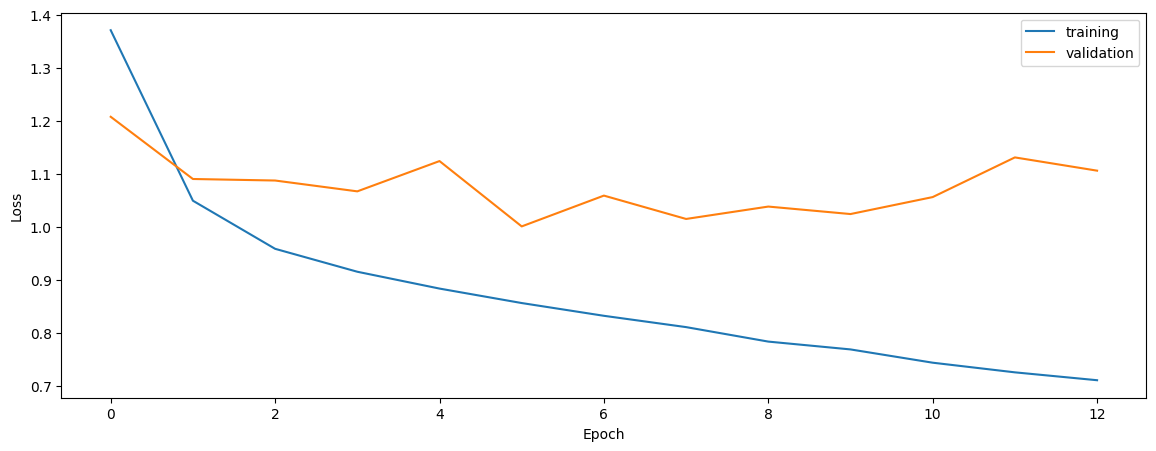

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6728961798504796
0.6207940664679634
0.629261333982812


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.601822191801658
0.6021003657487092
0.5478164128964705


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6021291439497687
0.5903839806359336
0.5573242372560167


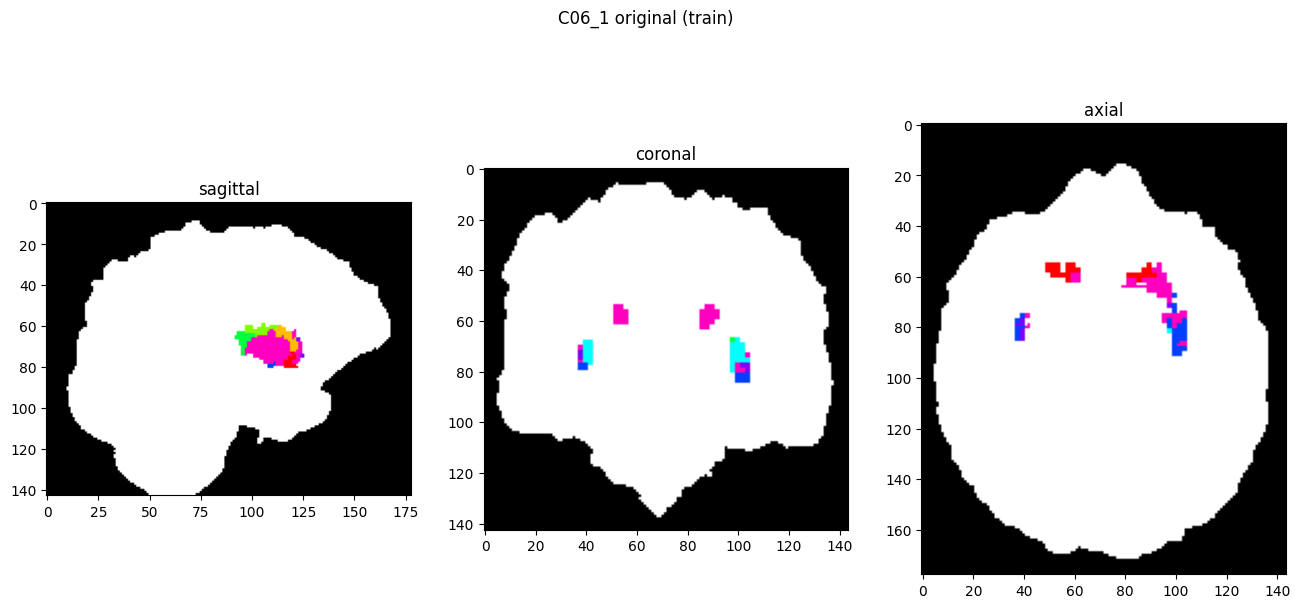

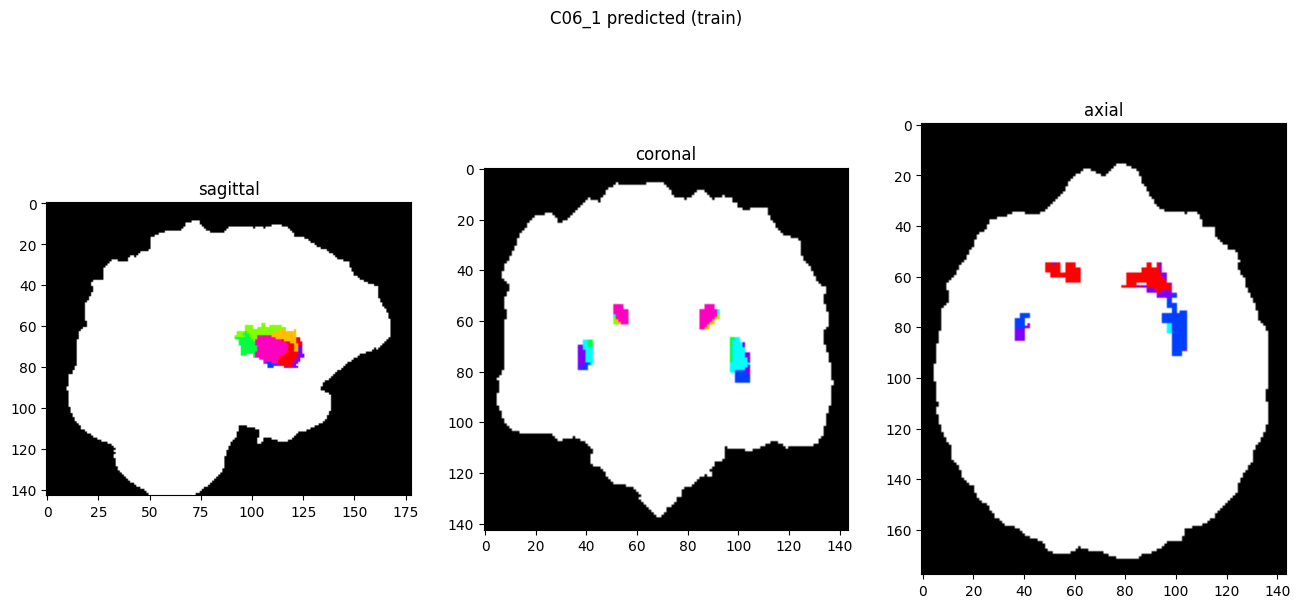

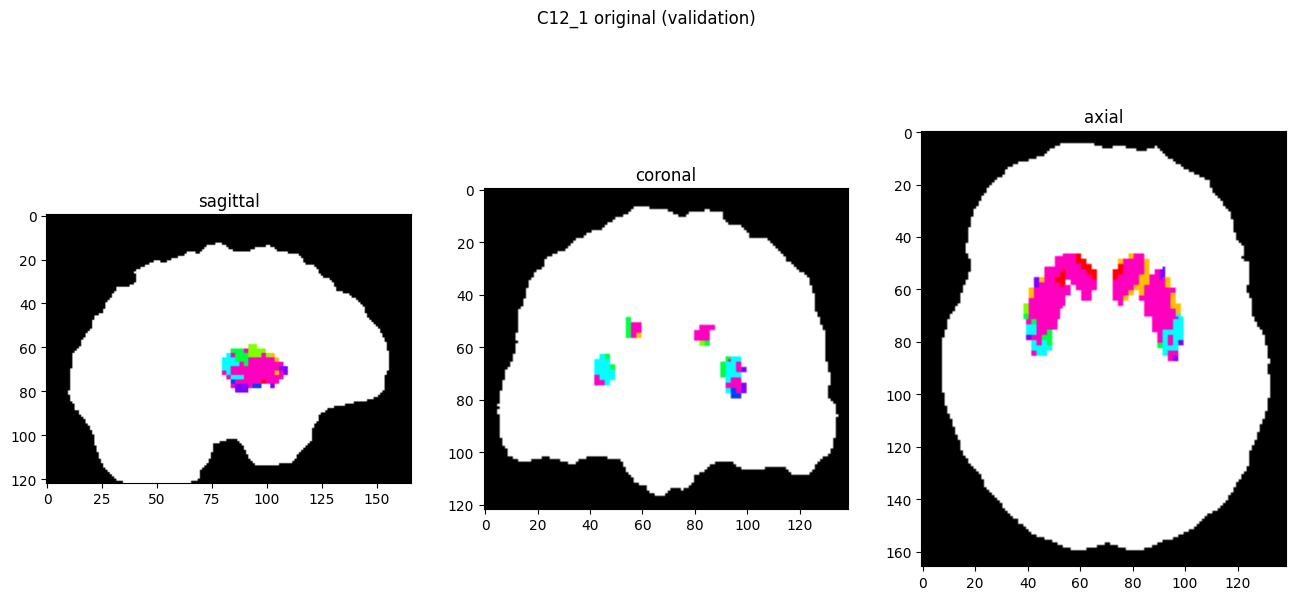

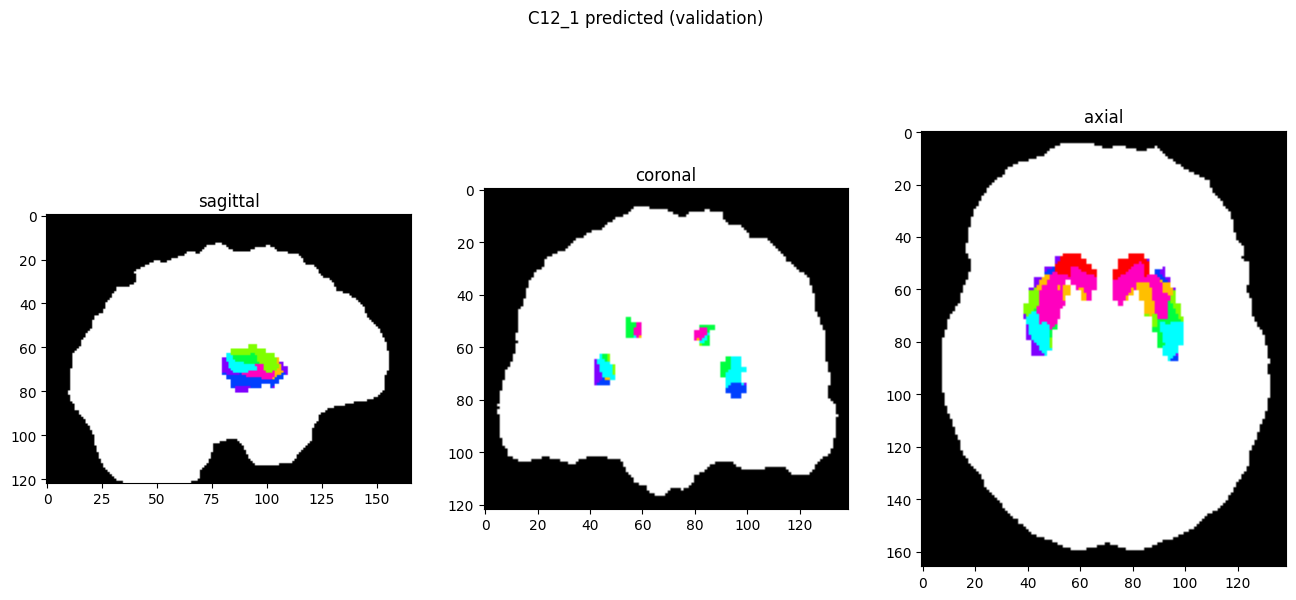

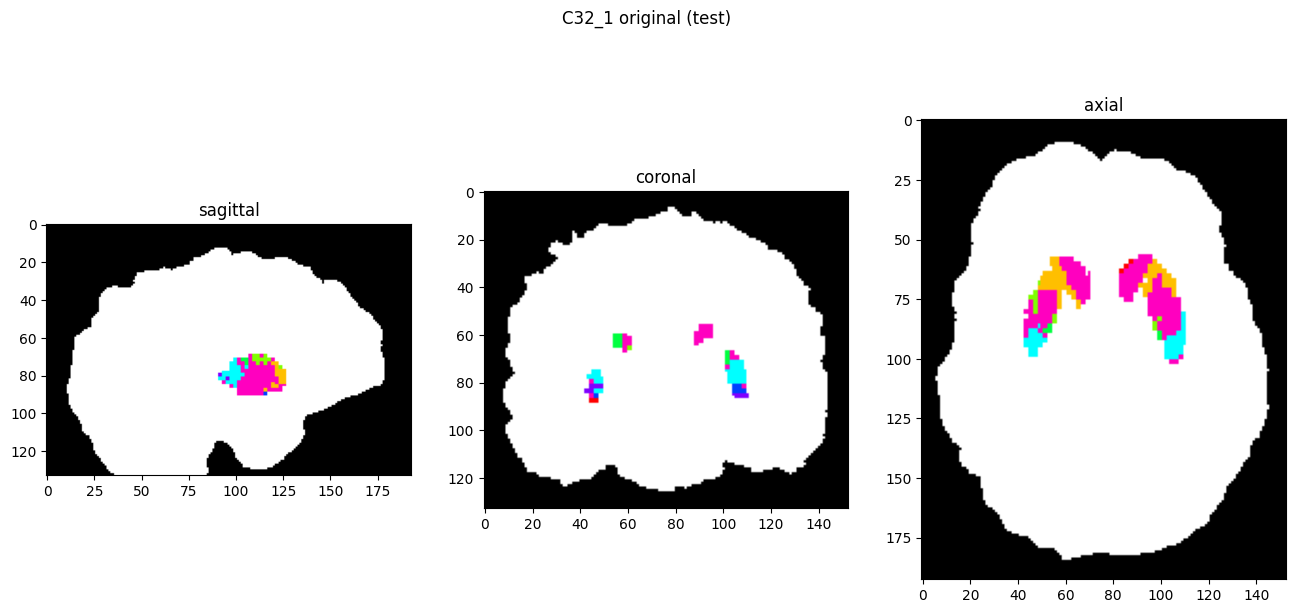

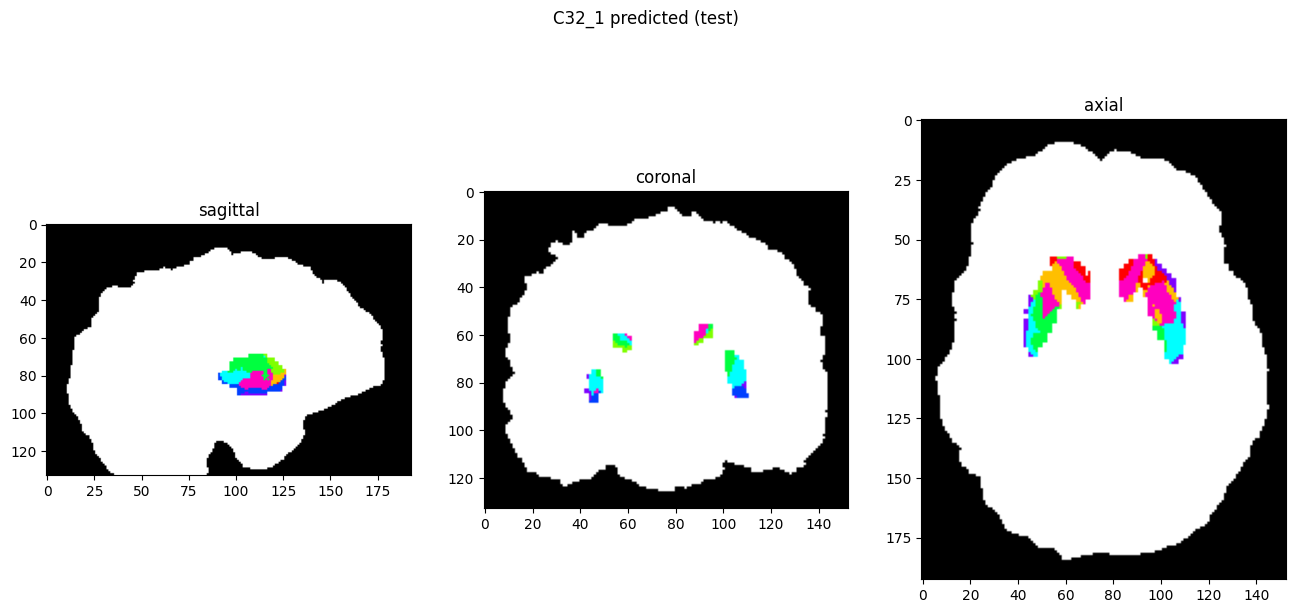

In [10]:
showResults(model, gen, threshold=0)